<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Denmark/VWSDE/VWSDE_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "VWS.DE"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close  Volume
Date                                                     
2009-01-02  42.00  44.48  41.75  43.55      23.44    4894
2009-01-05  47.09  47.44  45.43  47.10      25.35   11680
2009-01-06  47.20  48.11  45.71  46.75      25.16    9490
2009-01-07  46.99  46.99  43.60  44.13      23.75   12053
2009-01-08  42.60  46.00  39.90  44.81      24.11   18155
...           ...    ...    ...    ...        ...     ...
2018-12-19  68.64  68.64  66.22  67.10      60.78    3862
2018-12-20  66.04  66.96  65.38  65.98      59.77    2705
2018-12-21  66.00  67.10  65.84  67.10      60.78   12826
2018-12-27  68.08  68.14  63.50  64.72      58.62    7763
2018-12-28  66.32  66.34  65.78  66.10      59.87    3938

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close         Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000    2539.000000
mean     38.733226    39.209720    38.148440    38.664545    25.148050   27330.157148
std      22.182540    22.355704    21.993709    22.176315    17.622071   40036.726866
min       3.240000     3.280000     3.130000     3.200000     1.720000       0.000000
25%      20.725000    20.890000    20.315000    20.555000    11.060000    5333.500000
50%      38.900000    39.490000    38.010000    38.730000    20.850000   13183.000000
75%      57.005000    57.750000    55.930000    56.900000    40.080000   32537.000000
max      84.790000    84.790000    83.290000    84.170000    64.480000  468846.000000

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  32.92  33.14  32.40  32.93      17.72    4945   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  32.355886  33.819056 -34.790000  31.847584  32.795679  34.472152      32.500      32.195  34.790000  32.43750  32.280212  32.0320  32.290556  32.43750  32.643333  35.124497               35.484002                 32.43750               29.390998               37.007253                 32.43750               27.867747               38.530504                 32.43750               26.344496               40.053755                 32.43750               24.821245  32.795679  32.550614  34.711882               35.842181                32.795679               29.749177               37.365432                32.795679               28.225926               38.888683                32.795679               26.702675               40.411934                32.795679   
2009-03-16  32.92  34.00  32.40  34.00      18.30    3809   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  32.438092  33.784532  29.090000  32.534053  33.063306  34.466197      32.025      32.195  34.334000  32.31875  33.196307  32.1935  32.637778  32.31875  33.465000  34.784066               35.018591                 32.31875               29.618909               36.368512                 32.31875               28.268988               37.718433                 32.31875               26.919067               39.068354                 32.31875               25.569146  33.063306  33.551949  34.384593               35.763147                33.063306               30.363464               37.113068                33.063306               29.013544               38.462989                33.063306               27.663623               39.812909                33.063306   
2009-03-17  33.55  34.27  32.27  32.43      17.45

Open         High          Low        Close    Adj Close         Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000    2489.000000  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean     38.726826    39.196247    38.160422    38.662535    25.234166   27704.830856    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020    38.637982    38.527396     0.646521    38.661222    38.615009    38.618470    38.579385    38.576943    38.467381    38.614408    38.663754    38.614619    38.630677    38.614408    38.657591    38.525113               40.469138                38.614408               36.759678               41.396503                38.614408               35.832313               42.323868                38.614408               34.904948               43.251233                38.614408               33.977583    38.615009    38.654739    38.537440               40.469739                38.615009               36.760279               41.397104                38.615009               35.832914               42.324469   
std      22.396160    22.570988    22.206446    22.390632    17.784975   40343.417895     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    22.325405    22.175814    44.538569    22.403067    22.322226    22.243542    22.299210    22.288112    22.225304    22.337215    22.396488    22.343770    22.349657    22.337215    22.386862    22.234119               23.038647                22.337215               21.707312               23.414203                22.337215               21.421184               23.805287                22.337215               21.155330               24.211145                22.337215               20.910521    22.322226    22.376918    22.249339               23.022951                22.322226               21.693123               23.398187                22.322226               21.407432               23.788970   
min       3.240000     3.280000   

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2009-03-13  0.363948  0.366335  0.365145  0.367173   0.254939    4945   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.364933  0.384765  0.300300  0.354254  0.369412  0.394336    0.365133    0.362461  0.387705  0.363455  0.359427  0.358506  0.361941  0.363455  0.364521  0.399573                0.387356                 0.363455                0.331906                0.388225                 0.363455                0.316102                0.374463                 0.363455                0.300337                0.362626                 0.363455                0.284614  0.369412  0.363916  0.394126                0.391313                 0.369412                0.336108                0.398697                 0.369412                0.320768                0.387497                 0.369412                0.305493                0.374435                 0.369412   
2009-03-16  0.363948  0.376886  0.365145  0.380388   0.264181    3809   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.365967  0.384325  0.683964  0.362743  0.372774  0.394260    0.359186    0.362461  0.382121  0.361972  0.370744  0.360522  0.366277  0.361972  0.374726  0.395262                0.381719                 0.361972                0.334759                0.380804                 0.361972                0.321117                0.365738                 0.361972                0.307510                0.352779                 0.361972                0.293938  0.372774  0.376367  0.389987                0.390355                 0.372774                0.343830                0.395711                 0.372774                0.330648                0.382802                 0.372774                0.317522                0.368302                 0.372774   
2009-03-17  0.371674  0.380199  0.363523  0.360998   0.2

140825

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxz3k6s34
  JVM stdout: /tmp/tmpxz3k6s34/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxz3k6s34/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_ep0ca3
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_112845_mod...  0.602924  1.476134              0.409259  0.626719  0.392776
1  DeepLearning_grid_1_AutoML_20190825_112845_mod...  0.594412  0.987513              0.430799  0.577698  0.333735
2  DeepLearning_grid_1_AutoML_20190825_112845_mod...  0.572840  1.106175              0.485185  0.528166  0.278959
3  DeepLearning_grid_1_AutoML_20190825_112845_mod...  0.568421  1.451007              0.486550  0.578780  0.334986
4  DeepLearning_grid_1_AutoML_20190825_112845_mod...  0.561826  0.692870              0.455263  0.499871  0.249871
5              DeepLearning_1_AutoML_20190825_112845  0.539831  1.572532              0.476803  0.523640  0.274199
6  DeepLearning_grid_1_AutoML_20190825_112845_mod...  0.539831  3.576609              0.467349  0.665022  0.442255
7  DeepLearning_grid_1_AutoML_20190825_112845_mod...  0.516179  0.692999              0.488889  0.499925  0.249925
8  DeepLearning_grid_1_AutoML_20190825_112845_mod...  0.500000  0.704721              0.500000  0.505736  0.255769
9  DeepLearning_grid_1_AutoML_20190825_112845_mod...  0.500000  0.692697              0.500000  0.499775  0.249775

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.004584
1                          DIV             0.840359           0.840359    0.003852
2               CDLEVENINGSTAR             0.721539           0.721539    0.003307
3           CDLEVENINGDOJISTAR             0.685685           0.685685    0.003143
4              CDLLADDERBOTTOM             0.641746           0.641746    0.002942
...                        ...                  ...                ...         ...
1040   BBANDS_middleband_8_8_2             0.159183           0.159183    0.000730
1041                 MAVP_24_2             0.158417           0.158417    0.000726
1042   BBANDS_lowerband_30_1_3             0.157856           0.157856    0.000724
1043  BBANDS_middleband_24_6_5             0.157548           0.157548    0.000722
1044          CDLCOUNTERATTACK             0.148051           0.148051    0.000679

[1045 rows x 4 columns]

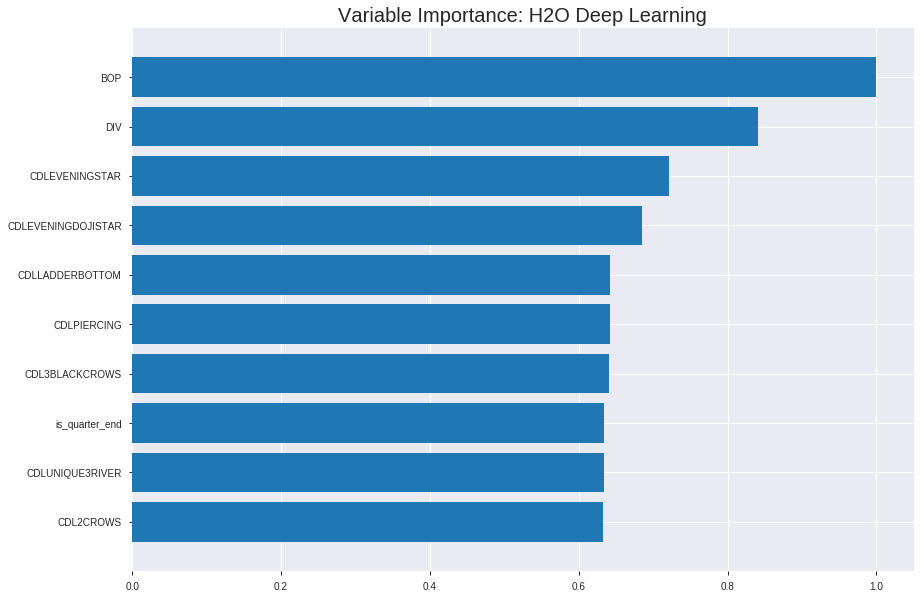

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_112845_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23618282788709258
RMSE: 0.48598644825457077
LogLoss: 0.7190200915346823
Mean Per-Class Error: 0.33860498021482555
AUC: 0.6998197028132168
pr_auc: 0.6560016097938887
Gini: 0.39963940562643363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39503956099958826: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      399  460   0.5355   (460.0/859.0)
1      140  742   0.1587   (140.0/882.0)
Total  539  1202  0.3446   (600.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39504      0.712092  256
max f2                       0.0521149    0.843906  382
max f0point5                 0.475939     0.66014   224
max accuracy                 0.433899     0.663412  241
max precision                0.975545     0.766234  12
max recall                   0.0150329    1         394
max specificity              0.999023     0.996508  0
max absolute_mcc             0.430609     0.339914  242
max min_per_class_accuracy   0.585662     0.650794  177
max mean_per_class_accuracy  0.433899     0.661395  241

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 56.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.993437           1.42561   1.42561            0.722222         0.997342   0.722222                    0.997342            0.0147392       0.0147392                  42.5611   42.5611
    2        0.0201034                   0.987457           1.27724   1.35355            0.647059         0.990417   0.685714                    0.993978            0.0124717       0.0272109                  27.7244   35.3547
    3        0.0304423                   0.982409           1.7546    1.48975            0.888889         0.984576   0.754717                    0.990785            0.0181406       0.0453515                  75.4598   48.9753
    4        0.0402068                   0.976993           1.50947   1.49454            0.764706         0.979889   0.757143                    0.988139            0.0147392       0.0600907                  50.947    49.4542
    5        0.0505457                   0.972627           1.31595   1.45801            0.666667         0.974217   0.738636                    0.985291            0.0136054       0.0736961                  31.5949   45.8011
    6        0.100517                    0.943013           1.27057   1.36483            0.643678         0.958761   0.691429                    0.972102            0.0634921       0.137188                   27.0571   36.4827
    7        0.150488                    0.907296           1.45208   1.3938             0.735632         0.925614   0.706107                    0.956665            0.0725624       0.209751                   45.2081   39.3801
    8        0.20046                     0.876087           1.36133   1.38571            0.689655         0.89163    0.702006                    0.940453            0.0680272       0.277778                   36.1326   38.5705
    9        0.300402                    0.790771           1.29326   1.35495            0.655172         0.834964   0.686424                    0.905357            0.129252        0.407029                   29.326    35.4949
    10       0.400345                    0.701771           1.17982   1.31123            0.597701         0.745079   0.664275                    0.865345            0.117914        0.524943                   17.9816   31.1229
    11       0.500287                    0.586073           1.24788   1.29857            0.632184         0.643909   0.657865                    0.821109            0.124717        0.64966                    24.7882   29.8574
    12       0.60023                     0.488125           1.04368   1.25613            0.528736         0.53644    0.636364                    0.773709            0.104308        0.753968                   4.36834   25.6133
    13       0.700172                    0.384695           0.896206  1.20476            0.454023         0.437601   0.610336                    0.725733            0.0895692       0.843537                   -10.3794  20.4757
    14       0.800115                    0.254886           0.680663  1.13929            0.344828         0.32015    0.577172                    0.675072            0.0680272       0.911565                   -31.9337  13.9292
    15       0.900057                    0.139007           0.612597  1.08081            0.310345         0.198368   0.547543                    0.622138            0.0612245       0.972789                   -38.7403  8.08078
    16       1                           1.37831e-05        0.272265  1                  0.137931         0.0692978  0.506605                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.42236643072535757
RMSE: 0.6498972462823316
LogLoss: 8.94500617577744
Mean Per-Class Error: 0.4310272469008265
AUC: 0.5572055785123967
pr_auc: 0.5711216363834647
Gini: 0.11441115702479343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 5.1761805009499836e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    242  1        (242.0/242.0)
1      0    256  0        (0.0/256.0)
Total  0    498  0.4859   (242.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       5.17618e-51  0.679045  267
max f2                       5.17618e-51  0.840999  267
max f0point5                 5.17618e-51  0.569395  267
max accuracy                 0.799253     0.566265  201
max precision                0.988606     0.725     39
max recall                   5.17618e-51  1         267
max specificity              0.999734     0.995868  0
max absolute_mcc             0.927387     0.147923  149
max min_per_class_accuracy   0.00141643   0.528926  249
max mean_per_class_accuracy  0.799253     0.568973  201

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 43.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.997028           0.389063  0.389063           0.2              0.998586     0.2                         0.998586            0.00390625      0.00390625                 -61.0937  -61.0937
    2        0.0200803                   0.995717           1.55625   0.972656           0.8              0.996448     0.5                         0.997517            0.015625        0.0195312                  55.625    -2.73437
    3        0.0301205                   0.994647           1.55625   1.16719            0.8              0.995303     0.6                         0.996779            0.015625        0.0351562                  55.625    16.7188
    4        0.0401606                   0.99378            1.55625   1.26445            0.8              0.994191     0.65                        0.996132            0.015625        0.0507812                  55.625    26.4453
    5        0.0502008                   0.993228           1.16719   1.245              0.6              0.993484     0.64                        0.995603            0.0117188       0.0625                     16.7188   24.5
    6        0.100402                    0.98522            1.40063   1.32281            0.72             0.989697     0.68                        0.99265             0.0703125       0.132812                   40.0625   32.2813
    7        0.150602                    0.978233           1.16719   1.27094            0.6              0.981707     0.653333                    0.989002            0.0585938       0.191406                   16.7188   27.0938
    8        0.200803                    0.968532           0.93375   1.18664            0.48             0.973009     0.61                        0.985004            0.046875        0.238281                   -6.625    18.6641
    9        0.301205                    0.927314           1.28391   1.21906            0.66             0.951659     0.626667                    0.973889            0.128906        0.367188                   28.3906   21.9063
    10       0.399598                    0.810236           0.952806  1.1535             0.489796         0.887583     0.592965                    0.952638            0.09375         0.460938                   -4.71939  15.3502
    11       0.5                         0.00141884         0.661406  1.05469            0.34             0.543803     0.542169                    0.870542            0.0664062       0.527344                   -33.8594  5.46875
    12       1                           0                  0.945313  1                  0.485944         9.93141e-06  0.514056                    0.435276            0.472656        1                          -5.46875  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 11:32:33  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 11:32:34  3 min 42.011 sec  326 obs/sec       0.218265  1             380        0.652938         3.78892             -0.705611      0.562647        0.433497           1.7546           0.493395                         0.694055           12.4236               -0.928373        0.498531          0.153849             0.957692           0.483936
    2019-08-25 11:32:47  3 min 55.489 sec  486 obs/sec       3.71798   17            6473       0.629406         2.98046             -0.584884      0.619918        0.53358            1.42561          0.395175                         0.68076            11.4704               -0.855204        0.505157          0.211781             0.953733           0.443775
    2019-08-25 11:33:01  4 min  9.288 sec  478 obs/sec       7.06318   32            12297      0.575123         1.86003             -0.323299      0.664843        0.60866            1.7546           0.415279                         0.663944           10.309                -0.764679        0.502978          0.25482              0.957576           0.463855
    2019-08-25 11:33:15  4 min 23.559 sec  489 obs/sec       10.842    49            18876      0.563311         1.4345              -0.269501      0.647264        0.547426           1.53527          0.415853                         0.651925           9.37673               -0.701368        0.554526          0.569751             1.55625            0.485944
    2019-08-25 11:33:30  4 min 37.656 sec  495 obs/sec       14.6129   66            25441      0.455706         0.614062            0.169183       0.74753         0.724363           1.7546           0.332567                         0.625114           9.28477               -0.564305        0.501969          0.277204             0.952806           0.459839
    2019-08-25 11:33:43  4 min 51.185 sec  505 obs/sec       18.4394   83            32103      0.457996         0.614562            0.160812       0.741127        0.708884           1.42561          0.335439                         0.630897           9.37442               -0.593382        0.508862          0.275159             0.952806           0.445783
    2019-08-25 11:33:57  5 min  4.662 sec  511 obs/sec       22.2366   100           38714      0.532074         0.862171            -0.13261       0.624362        0.634441           1.53527          0.484204                         0.692181           9.57981               -0.917976        0.503583          0.277726             0.952806           0.439759
    2019-08-25 11:34:11  5 min 19.114 sec  515 obs/sec       26.2435   118           45690      0.459356         0.614253            0.155822       0.735108        0.702765           1.64494          0.326249                         0.617331           9.02514               -0.525594        0.558077          0.570254             0.778125           0.485944
    2019-08-25 11:34:26

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0045838089382565055
DIV                       0.8403588533401489     0.8403588533401489   0.0038520444232835625
CDLEVENINGSTAR            0.7215392589569092     0.7215392589569092   0.0033073981045096557
CDLEVENINGDOJISTAR        0.6856853365898132     0.6856853365898132   0.0031430505746918064
CDLLADDERBOTTOM           0.6417463421821594     0.6417463421821594   0.002941642619388
---                       ---                    ---                  ---
BBANDS_middleband_8_8_2   0.1591828167438507     0.1591828167438507   0.0007296636182073102
MAVP_24_2                 0.15841659903526306    0.15841659903526306  0.0007261514226260357
BBANDS_lowerband_30_1_3   0.1578560471534729     0.1578560471534729   0.0007235819598999294
BBANDS_middleband_24_6_5  0.1575479805469513     0.1575479805469513   0.0007221698414353774
CDLCOUNTERATTACK          0.14805133640766144    0.14805133640766144  0.0006786390391462592


See the whole table with table.as_data_frame()


('accuracy', 0.6024096385542169)

('F1', 0.6397306397306398)

('auc', 0.6029239766081871)

('logloss', 1.4761335009031942)

('mean_per_class_error', 0.4092592592592592)

('rmse', 0.6267187792007564)

('mse', 0.3927764282028864)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


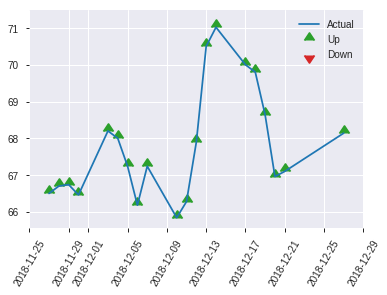


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3927764282028864
RMSE: 0.6267187792007564
LogLoss: 1.4761335009031942
Mean Per-Class Error: 0.4092592592592592
AUC: 0.6029239766081871
pr_auc: 0.5396266693956872
Gini: 0.20584795321637417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7612985054502664: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      47   88   0.6519   (88.0/135.0)
1      19   95   0.1667   (19.0/114.0)
Total  66   183  0.4297   (107.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.761299     0.639731  182
max f2                       3.01866e-14  0.810811  246
max f0point5                 0.761299     0.561466  182
max accuracy                 0.964427     0.60241   74
max precision                0.994581     0.692308  12
max recall                   3.01866e-14  1         246
max specificity              0.999829     0.992593  0
max absolute_mcc             0.761299     0.204859  182
max min_per_class_accuracy   0.91305      0.570175  122
max mean_per_class_accuracy  0.761299     0.590741  182

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 81.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.99798            1.45614   1.45614            0.666667         0.999121  0.666667                    0.999121            0.0175439       0.0175439                  45.614    45.614
    2        0.0200803                   0.996047           0         0.873684           0                0.997211  0.4                         0.998357            0               0.0175439                  -100      -12.6316
    3        0.0321285                   0.995879           2.18421   1.36513            1                0.995971  0.625                       0.997462            0.0263158       0.0438596                  118.421   36.5132
    4        0.0401606                   0.994925           1.09211   1.31053            0.5              0.995654  0.6                         0.997101            0.00877193      0.0526316                  9.21053   31.0526
    5        0.0522088                   0.99455            2.18421   1.51215            1                0.994698  0.692308                    0.996546            0.0263158       0.0789474                  118.421   51.2146
    6        0.100402                    0.990088           1.27412   1.39789            0.583333         0.992568  0.64                        0.994637            0.0614035       0.140351                   27.4123   39.7895
    7        0.15261                     0.987439           1.17611   1.32202            0.538462         0.988851  0.605263                    0.992657            0.0614035       0.201754                   17.6113   32.2022
    8        0.200803                    0.978465           1.09211   1.26684            0.5              0.982545  0.58                        0.99023             0.0526316       0.254386                   9.21053   26.6842
    9        0.301205                    0.964089           1.39789   1.31053            0.64             0.971721  0.6                         0.98406             0.140351        0.394737                   39.7895   31.0526
    10       0.401606                    0.936737           0.524211  1.11395            0.24             0.951419  0.51                        0.9759              0.0526316       0.447368                   -47.5789  11.3947
    11       0.502008                    0.912551           1.31053   1.15326            0.6              0.923458  0.528                       0.965412            0.131579        0.578947                   31.0526   15.3263
    12       0.598394                    0.882491           1.09211   1.14341            0.5              0.894468  0.52349                     0.953985            0.105263        0.684211                   9.21053   14.3412
    13       0.698795                    0.807085           0.873684  1.10466            0.4              0.846204  0.505747                    0.938499            0.0877193       0.77193                    -12.6316  10.4658
    14       0.799197                    0.676194           0.961053  1.08662            0.44             0.741852  0.497487                    0.913794            0.0964912       0.868421                   -3.89474  8.66173
    15       0.899598                    0.519358           0.698947  1.04335            0.32             0.60899   0.477679                    0.879776            0.0701754       0.938596                   -30.1053  4.33506
    16       1                           2.86542e-28        0.611579  1                  0.28             0.275009  0.457831                    0.819057         

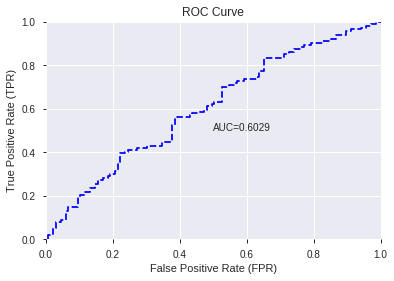

This function is available for GLM models only


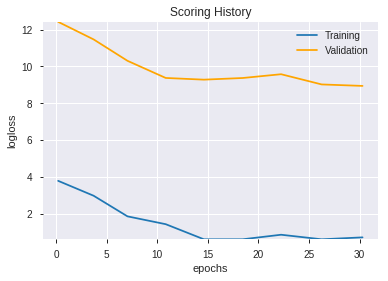

--2019-08-25 11:56:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  14.1MB/s    in 27s     

2019-08-25 11:56:52 (13.1 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_112845_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_112845_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_115707_model_6  0.680247  0.660708              0.377193  0.480972  0.231334
1  DeepLearning_grid_1_AutoML_20190825_115707_model_9  0.662378  0.665252              0.377583  0.480155  0.230549
2  DeepLearning_grid_1_AutoML_20190825_115707_model_8  0.649383  0.733173              0.399415  0.496922  0.246932
3  DeepLearning_grid_1_AutoML_20190825_115707_model_1  0.642528  1.340484              0.393470  0.516658  0.266936
4               DeepLearning_1_AutoML_20190825_115707  0.641650  1.181386              0.422027  0.504396  0.254416
5  DeepLearning_grid_1_AutoML_20190825_115707_model_5  0.632716  0.931260              0.389474  0.502818  0.252826
6  DeepLearning_grid_1_AutoML_20190825_115707_model_4  0.624691  1.084013              0.387427  0.536946  0.288311
7  DeepLearning_grid_1_AutoML_20190825_115707_model_2  0.624529  1.596141              0.402144  0.517836  0.268154
8  DeepLearning_grid_1_AutoML_20190825_115707_model_3  0.608057  1.457373              0.486550  0.515764  0.266012
9  DeepLearning_grid_1_AutoML_20190825_115707_model_7  0.603509  1.244995              0.445517  0.532479  0.283534

variable  relative_importance  scaled_importance  percentage
0                   DIV             1.000000           1.000000    0.045247
1                   BOP             0.958097           0.958097    0.043351
2                Volume             0.619246           0.619246    0.028019
3                   SUB             0.613733           0.613733    0.027770
4           CDLLONGLINE             0.612418           0.612418    0.027710
5          CDLENGULFING             0.608149           0.608149    0.027517
6    CDLCLOSINGMARUBOZU             0.585045           0.585045    0.026472
7          HT_TRENDMODE             0.517521           0.517521    0.023417
8    CDLEVENINGDOJISTAR             0.468174           0.468174    0.021184
9                  SINH             0.455433           0.455433    0.020607
10                 TANH             0.450283           0.450283    0.020374
11   CDLMORNINGDOJISTAR             0.438620           0.438620    0.019846
12     CDLSTICKSANDWICH             0.435771           0.435771    0.019718
13    CDL3WHITESOLDIERS             0.427163           0.427163    0.019328
14          CDLPIERCING             0.422554           0.422554    0.019120
15            CDLINNECK             0.420709           0.420709    0.019036
16            CDL2CROWS             0.415340           0.415340    0.018793
17                  SIN             0.415220           0.415220    0.018788
18  CDLGAPSIDESIDEWHITE             0.412104           0.412104    0.018647
19                 COSH             0.411060           0.411060    0.018599
20                 ATAN             0.410615           0.410615    0.018579
21                  EXP             0.407172           0.407172    0.018424
22       CDLMORNINGSTAR             0.407147           0.407147    0.018422
23       CDLEVENINGSTAR             0.405937           0.405937    0.018368
24       CDL3BLACKCROWS             0.404687           0.404687    0.018311
25      CDLLADDERBOTTOM             0.403353           0.403353    0.018251
26      CDLUNIQUE3RIVER             0.402347           0.402347    0.018205
27   CDLUPSIDEGAP2CROWS             0.399830           0.399830    0.018091
28            CDLONNECK             0.398717           0.398717    0.018041
29   CDLSEPARATINGLINES             0.393985           0.393985    0.017827
30      CDLADVANCEBLOCK             0.392268           0.392268    0.017749
31       CDL3LINESTRIKE             0.391010           0.391010    0.017692
32     CDLABANDONEDBABY             0.390675           0.390675    0.017677
33       is_month_start             0.389194           0.389194    0.017610
34      CDLSHOOTINGSTAR             0.387445           0.387445    0.017531
35   CDLIDENTICAL3CROWS             0.386263           0.386263    0.017477
36         is_month_end             0.384869           0.384869    0.017414
37        CDLHIKKAKEMOD             0.381152           0.381152    0.017246
38           CDL3INSIDE             0.375655           0.375655    0.016997
39            CDLHAMMER             0.375626           0.375626    0.016996
40            CDLTAKURI             0.371209           0.371209    0.016796
41      CDLHOMINGPIGEON             0.366334           0.366334    0.016576
42         CDLTHRUSTING             0.364754           0.364754    0.016504
43        CDLHANGINGMAN             0.361503           0.361503    0.016357
44    CDLGRAVESTONEDOJI             0.355348           0.355348    0.016079
45    CDLINVERTEDHAMMER             0.349009           0.349009    0.015792
46       is_quarter_end             0.345497           0.345497    0.015633
47    CDLDARKCLOUDCOVER             0.341383           0.341383    0.015447
48       CDLMATCHINGLOW             0.335805           0.335805    0.015194
49     is_quarter_start             0.335241           0.335241    0.015169

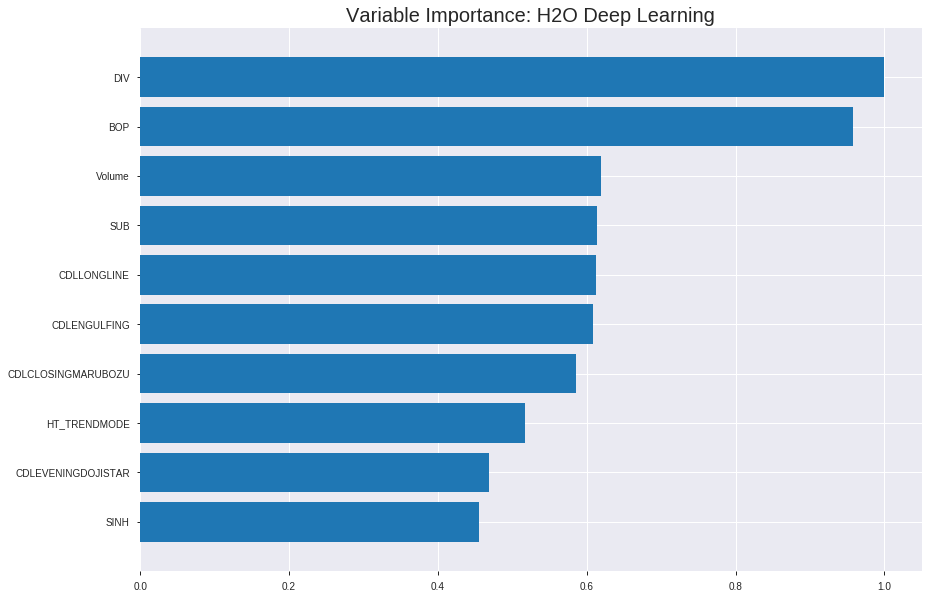

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_115707_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20731466900438064
RMSE: 0.4553182063177143
LogLoss: 0.5983339279471447
Mean Per-Class Error: 0.32806762596385086
AUC: 0.7340814478682431
pr_auc: 0.7219583175678883
Gini: 0.4681628957364863
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46043628880625836: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      398  461   0.5367   (461.0/859.0)
1      123  759   0.1395   (123.0/882.0)
Total  521  1220  0.3354   (584.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460436     0.722169  239
max f2                       0.109245     0.850136  365
max f0point5                 0.548273     0.676072  190
max accuracy                 0.548273     0.672028  190
max precision                0.994698     1         0
max recall                   0.0527704    1         384
max specificity              0.994698     1         0
max absolute_mcc             0.460436     0.353596  239
max min_per_class_accuracy   0.5496       0.667055  189
max mean_per_class_accuracy  0.548273     0.671932  190

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 51.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.946779           1.7546    1.7546             0.888889         0.970491   0.888889                    0.970491            0.0181406       0.0181406                  75.4598   75.4598
    2        0.0201034                   0.911926           1.7417    1.74833            0.882353         0.925403   0.885714                    0.948591            0.0170068       0.0351474                  74.1697   74.8332
    3        0.0304423                   0.886942           1.86426   1.7877             0.944444         0.900118   0.90566                     0.932128            0.0192744       0.0544218                  86.4261   78.7704
    4        0.0402068                   0.86213            1.62558   1.74833            0.823529         0.87367    0.885714                    0.917932            0.015873        0.0702948                  62.5584   74.8332
    5        0.0505457                   0.851767           1.7546    1.74961            0.888889         0.856669   0.886364                    0.905401            0.0181406       0.0884354                  75.4598   74.9613
    6        0.100517                    0.795537           1.54284   1.64682            0.781609         0.820939   0.834286                    0.863411            0.0770975       0.165533                   54.2836   64.6816
    7        0.150488                    0.733517           1.45208   1.58215            0.735632         0.766947   0.801527                    0.831379            0.0725624       0.238095                   45.2081   58.2152
    8        0.20046                     0.679322           1.31595   1.51579            0.666667         0.702162   0.767908                    0.799168            0.0657596       0.303855                   31.5949   51.5792
    9        0.300402                    0.625118           1.29326   1.44176            0.655172         0.650813   0.730402                    0.749811            0.129252        0.433107                   29.326    44.1756
    10       0.400345                    0.590731           1.22519   1.38769            0.62069          0.607907   0.703013                    0.714385            0.122449        0.555556                   22.5194   38.7693
    11       0.500287                    0.550246           1.11175   1.33257            0.563218         0.570851   0.675086                    0.685712            0.111111        0.666667                   11.175    33.2568
    12       0.60023                     0.507458           0.896206  1.25991            0.454023         0.530935   0.638278                    0.65994             0.0895692       0.756236                   -10.3794  25.9911
    13       0.700172                    0.460477           1.03234   1.22743            0.522989         0.48835    0.621821                    0.635447            0.103175        0.85941                    3.2339    22.7427
    14       0.800115                    0.346438           0.692007  1.16055            0.350575         0.407538   0.58794                     0.606979            0.069161        0.928571                   -30.7993  16.0548
    15       0.900057                    0.16125            0.510497  1.08837            0.258621         0.252567   0.551372                    0.567625            0.0510204       0.979592                   -48.9503  8.83659
    16       1                           0.0103591          0.204199  1                  0.103448         0.0890247  0.506605                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.35388119573509447
RMSE: 0.5948791438057771
LogLoss: 7.822917441450515
Mean Per-Class Error: 0.41554752066115697
AUC: 0.5693278667355371
pr_auc: 0.5955997240661407
Gini: 0.1386557334710743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.942282069943338e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    242  1        (242.0/242.0)
1      0    256  0        (0.0/256.0)
Total  0    498  0.4859   (242.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       7.94228e-49  0.679045  298
max f2                       7.94228e-49  0.840999  298
max f0point5                 0.457379     0.583333  190
max accuracy                 0.483448     0.580321  176
max precision                0.967942     1         0
max recall                   7.94228e-49  1         298
max specificity              0.967942     1         0
max absolute_mcc             0.61416      0.185134  69
max min_per_class_accuracy   0.148971     0.535156  243
max mean_per_class_accuracy  0.483448     0.584452  176

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 26.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.844759           1.55625   1.55625            0.8              0.907812     0.8                         0.907812            0.015625        0.015625                   55.625    55.625
    2        0.0200803                   0.827207           0.778125  1.16719            0.4              0.837516     0.6                         0.872664            0.0078125       0.0234375                  -22.1875  16.7188
    3        0.0301205                   0.752596           1.55625   1.29688            0.8              0.783394     0.666667                    0.842907            0.015625        0.0390625                  55.625    29.6875
    4        0.0401606                   0.726019           1.94531   1.45898            1                0.74426      0.75                        0.818245            0.0195312       0.0585938                  94.5313   45.8984
    5        0.0502008                   0.708741           1.16719   1.40063            0.6              0.716133     0.72                        0.797823            0.0117188       0.0703125                  16.7188   40.0625
    6        0.100402                    0.641365           1.08938   1.245              0.56             0.670423     0.64                        0.734123            0.0546875       0.125                      8.9375    24.5
    7        0.150602                    0.605454           1.71188   1.40063            0.88             0.623009     0.72                        0.697085            0.0859375       0.210938                   71.1875   40.0625
    8        0.200803                    0.581822           0.93375   1.28391            0.48             0.59446      0.66                        0.671429            0.046875        0.257812                   -6.625    28.3906
    9        0.301205                    0.528539           1.12828   1.23203            0.58             0.553141     0.633333                    0.631999            0.113281        0.371094                   12.8281   23.2031
    10       0.399598                    0.433119           1.07191   1.1926             0.55102          0.488344     0.613065                    0.596627            0.105469        0.476562                   7.19069   19.2604
    11       0.5                         0.0766815          0.583594  1.07031            0.3              0.289599     0.550201                    0.534975            0.0585938       0.535156                   -41.6406  7.03125
    12       0.600402                    1.04684e-46        0.855938  1.03446            0.44             0.0101332    0.531773                    0.447209            0.0859375       0.621094                   -14.4062  3.44638
    13       1                           0                  0.948218  1                  0.487437         1.86691e-49  0.514056                    0.268505            0.378906        1                          -5.17823  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:01:16  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:01:19  2 min 21.563 sec  888 obs/sec       1.38254   1             2407       0.512886         0.80987             -0.0523935     0.70154         0.673487           1.53527          0.359563                         0.632251           8.79811               -0.60023         0.557141          0.581823             1.16719            0.485944
    2019-08-25 12:01:27  2 min 29.733 sec  1911 obs/sec      11.1045   8             19333      0.460585         0.609487            0.151297       0.723196        0.709939           1.97392          0.360138                         0.601031           8.47067               -0.446097        0.561225          0.59287              1.55625            0.485944
    2019-08-25 12:01:35  2 min 37.482 sec  2268 obs/sec      22.2275   16            38698      0.455318         0.598334            0.170597       0.734081        0.721958           1.7546           0.335439                         0.594879           7.82292               -0.416644        0.569328          0.5956               1.55625            0.485944
    2019-08-25 12:01:43  2 min 45.997 sec  2441 obs/sec      34.7507   25            60501      0.45252          0.592616            0.180759       0.743808        0.733318           1.97392          0.351522                         0.614873           9.25918               -0.513472        0.505464          0.276647             0.952806           0.437751
    2019-08-25 12:01:52  2 min 54.154 sec  2554 obs/sec      47.251    34            82264      0.451962         0.592483            0.182779       0.741425        0.729258           1.97392          0.337163                         0.612872           9.21096               -0.503638        0.508781          0.27977              0.952806           0.453815
    2019-08-25 12:01:59  3 min  2.029 sec  2646 obs/sec      59.7668   43            104054     0.44585          0.578998            0.204733       0.758924        0.750365           1.86426          0.350948                         0.614917           9.35168               -0.513688        0.506666          0.272973             0.94128            0.441767
    2019-08-25 12:02:00  3 min  2.825 sec  2644 obs/sec      59.7668   43            104054     0.455318         0.598334            0.170597       0.734081        0.721958           1.7546           0.335439                         0.594879           7.82292               -0.416644        0.569328          0.5956               1.55625            0.485944

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
DIV                1.0                    1.0                  0.04524749273033898
BOP                0.9580971002578735     0.9580971002578735   0.04335149157887699
Volume             0.6192456483840942     0.6192456483840942   0.02801931297355335
SUB                0.6137328147888184     0.6137328147888184   0.027769871075527537
CDLLONGLINE        0.6124180555343628     0.6124180555343628   0.027710381515719414
---                ---                    ---                  ---
CDLINVERTEDHAMMER  0.3490087389945984     0.3490087389945984   0.015791770380482864
is_quarter_end     0.3454972505569458     0.3454972505569458   0.015632884332927508
CDLDARKCLOUDCOVER  0.34138330817222595    0.34138330817222595  0.015446738754781865
CDLMATCHINGLOW     0.3358054459095001     0.3358054459095001   0.015194354472598346
is_quarter_start   0.33524149656295776    0.33524149656295776  0.015168837178640392


See the whole table with table.as_data_frame()


('accuracy', 0.6506024096385542)

('F1', 0.6753246753246752)

('auc', 0.6802469135802469)

('logloss', 0.6607078017088776)

('mean_per_class_error', 0.35175438596491226)

('rmse', 0.4809720594238135)

('mse', 0.2313341219463844)

deeplearning prediction progress: |███████████████████████████████████████| 100%


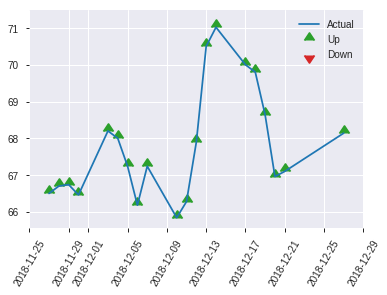


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2313341219463844
RMSE: 0.4809720594238135
LogLoss: 0.6607078017088776
Mean Per-Class Error: 0.35175438596491226
AUC: 0.6802469135802469
pr_auc: 0.605424318260853
Gini: 0.36049382716049383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41289551378581435: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      45   90   0.6667   (90.0/135.0)
1      10   104  0.0877   (10.0/114.0)
Total  55   194  0.4016   (100.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412896     0.675325  193
max f2                       0.120112     0.81295   238
max f0point5                 0.595577     0.616883  86
max accuracy                 0.595577     0.650602  86
max precision                0.874328     0.833333  5
max recall                   0.0430722    1         245
max specificity              0.951369     0.992593  0
max absolute_mcc             0.492474     0.301834  149
max min_per_class_accuracy   0.542021     0.640351  120
max mean_per_class_accuracy  0.492474     0.648246  149

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 51.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.894373           1.45614   1.45614            0.666667         0.928702  0.666667                    0.928702            0.0175439       0.0175439                  45.614    45.614
    2        0.0200803                   0.874763           2.18421   1.74737            1                0.887098  0.8                         0.91206             0.0175439       0.0350877                  118.421   74.7368
    3        0.0321285                   0.843199           1.45614   1.63816            0.666667         0.857743  0.75                        0.891691            0.0175439       0.0526316                  45.614    63.8158
    4        0.0401606                   0.821908           1.09211   1.52895            0.5              0.835648  0.7                         0.880482            0.00877193      0.0614035                  9.21053   52.8947
    5        0.0522088                   0.818263           2.18421   1.68016            1                0.819859  0.769231                    0.866492            0.0263158       0.0877193                  118.421   68.0162
    6        0.100402                    0.763408           1.09211   1.39789            0.5              0.79215   0.64                        0.830808            0.0526316       0.140351                   9.21053   39.7895
    7        0.15261                     0.691611           1.34413   1.3795             0.615385         0.721365  0.631579                    0.793367            0.0701754       0.210526                   34.413    37.9501
    8        0.200803                    0.648363           1.45614   1.39789            0.666667         0.663594  0.64                        0.762222            0.0701754       0.280702                   45.614    39.7895
    9        0.301205                    0.608914           1.31053   1.36877            0.6              0.625502  0.626667                    0.716648            0.131579        0.412281                   31.0526   36.8772
    10       0.401606                    0.578141           1.13579   1.31053            0.52             0.592668  0.6                         0.685653            0.114035        0.526316                   13.5789   31.0526
    11       0.502008                    0.539064           1.13579   1.27558            0.52             0.55748   0.584                       0.660018            0.114035        0.640351                   13.5789   27.5579
    12       0.598394                    0.493326           1.18311   1.26069            0.541667         0.517273  0.577181                    0.637026            0.114035        0.754386                   18.3114   26.0685
    13       0.698795                    0.465021           0.786316  1.19253            0.36             0.483003  0.545977                    0.614896            0.0789474       0.833333                   -21.3684  19.2529
    14       0.799197                    0.370129           0.786316  1.1415             0.36             0.422516  0.522613                    0.590728            0.0789474       0.912281                   -21.3684  14.1497
    15       0.899598                    0.240396           0.349474  1.0531             0.16             0.315376  0.482143                    0.559997            0.0350877       0.947368                   -65.0526  5.31015
    16       1                           0.00296241         0.524211  1                  0.24             0.130035  0.457831                    0.516828          

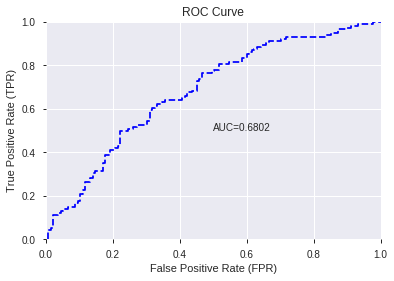

This function is available for GLM models only


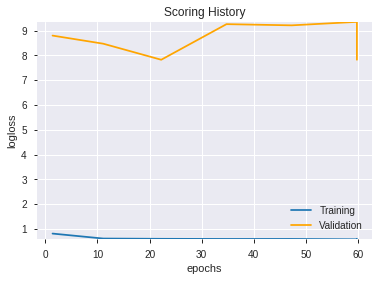

--2019-08-25 12:07:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_115707_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_115707_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['DIV',
 'BOP',
 'Volume',
 'SUB',
 'CDLLONGLINE',
 'CDLENGULFING',
 'CDLCLOSINGMARUBOZU',
 'HT_TRENDMODE',
 'CDLEVENINGDOJISTAR',
 'SINH',
 'TANH',
 'CDLMORNINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CDL3WHITESOLDIERS',
 'CDLPIERCING',
 'CDLINNECK',
 'CDL2CROWS',
 'SIN',
 'CDLGAPSIDESIDEWHITE',
 'COSH',
 'ATAN',
 'EXP',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'CDL3BLACKCROWS',
 'CDLLADDERBOTTOM',
 'CDLUNIQUE3RIVER',
 'CDLUPSIDEGAP2CROWS',
 'CDLONNECK',
 'CDLSEPARATINGLINES',
 'CDLADVANCEBLOCK',
 'CDL3LINESTRIKE',
 'CDLABANDONEDBABY',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLIDENTICAL3CROWS',
 'is_month_end',
 'CDLHIKKAKEMOD',
 'CDL3INSIDE',
 'CDLHAMMER',
 'CDLTAKURI',
 'CDLHOMINGPIGEON',
 'CDLTHRUSTING',
 'CDLHANGINGMAN',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'is_quarter_end',
 'CDLDARKCLOUDCOVER',
 'CDLMATCHINGLOW',
 'is_quarter_start']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_120738_model_1  0.656205  0.708933              0.391033  0.503906  0.253921

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.009657           1.000000    0.132581
1           CDLLONGLINE             0.007022           0.727201    0.096413
2    CDLCLOSINGMARUBOZU             0.006814           0.705632    0.093554
3                   DIV             0.005768           0.597334    0.079195
4          CDLENGULFING             0.004938           0.511319    0.067791
5                   SUB             0.003516           0.364082    0.048270
6                Volume             0.002703           0.279946    0.037116
7        CDLEVENINGSTAR             0.002210           0.228877    0.030345
8     CDLDARKCLOUDCOVER             0.001939           0.200779    0.026619
9    CDLEVENINGDOJISTAR             0.001463           0.151516    0.020088
10      CDLSHOOTINGSTAR             0.001356           0.140379    0.018612
11       CDL3BLACKCROWS             0.001296           0.134181    0.017790
12          CDLPIERCING             0.001261           0.130589    0.017314
13        CDLHANGINGMAN             0.001172           0.121382    0.016093
14      CDLADVANCEBLOCK             0.001035           0.107157    0.014207
15            CDL2CROWS             0.001032           0.106921    0.014176
16      CDLLADDERBOTTOM             0.000967           0.100129    0.013275
17           CDL3INSIDE             0.000963           0.099755    0.013226
18     is_quarter_start             0.000941           0.097401    0.012914
19       is_month_start             0.000917           0.094934    0.012586
20         is_month_end             0.000864           0.089472    0.011862
21       CDLMORNINGSTAR             0.000850           0.087972    0.011663
22            CDLTAKURI             0.000806           0.083512    0.011072
23            CDLHAMMER             0.000763           0.078965    0.010469
24   CDLUPSIDEGAP2CROWS             0.000752           0.077908    0.010329
25            CDLONNECK             0.000752           0.077896    0.010328
26        CDLHIKKAKEMOD             0.000746           0.077297    0.010248
27   CDLIDENTICAL3CROWS             0.000738           0.076452    0.010136
28     CDLABANDONEDBABY             0.000730           0.075628    0.010027
29       is_quarter_end             0.000701           0.072633    0.009630
30                 TANH             0.000694           0.071914    0.009534
31   CDLSEPARATINGLINES             0.000646           0.066868    0.008865
32  CDLGAPSIDESIDEWHITE             0.000628           0.064985    0.008616
33         CDLTHRUSTING             0.000561           0.058091    0.007702
34                  SIN             0.000496           0.051317    0.006804
35                 COSH             0.000493           0.051071    0.006771
36                  EXP             0.000486           0.050277    0.006666
37                 SINH             0.000479           0.049557    0.006570
38    CDL3WHITESOLDIERS             0.000458           0.047398    0.006284
39            CDLINNECK             0.000453           0.046906    0.006219
40    CDLGRAVESTONEDOJI             0.000435           0.045056    0.005974
41     CDLSTICKSANDWICH             0.000424           0.043948    0.005827
42       CDL3LINESTRIKE             0.000401           0.041515    0.005504
43   CDLMORNINGDOJISTAR             0.000375           0.038788    0.005143
44      CDLUNIQUE3RIVER             0.000297           0.030794    0.004083
45                 ATAN             0.000257           0.026640    0.003532
46    CDLINVERTEDHAMMER             0.000193           0.020028    0.002655
47       CDLMATCHINGLOW             0.000187           0.019374    0.002569
48         HT_TRENDMODE             0.000148           0.015322    0.002031
49      CDLHOMINGPIGEON             0.000053           0.005448    0.000722

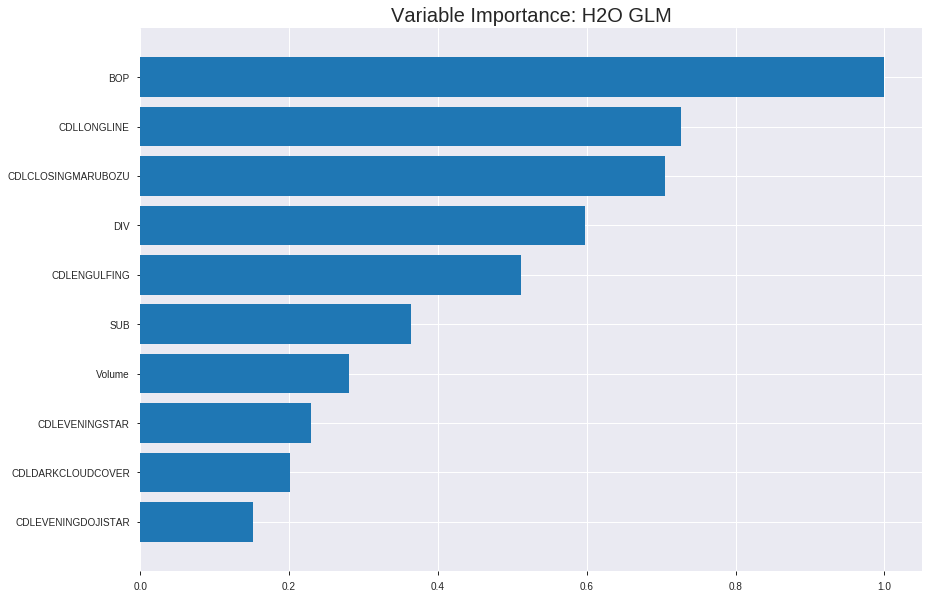

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_120738_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.247546339064974
RMSE: 0.4975402888862107
LogLoss: 0.6882385017083832
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2413.2346255079065
Residual deviance: 2396.44646294859
AIC: 2498.44646294859
AUC: 0.7147470163851337
pr_auc: 0.6889147210697
Gini: 0.42949403277026743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5036637710580602: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      321  538   0.6263   (538.0/859.0)
1      94   788   0.1066   (94.0/882.0)
Total  415  1326  0.363    (632.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503664     0.713768  248
max f2                       0.492416     0.842934  361
max f0point5                 0.507402     0.672515  185
max accuracy                 0.507402     0.668581  185
max precision                0.529213     1         0
max recall                   0.489534     1         380
max specificity              0.529213     1         0
max absolute_mcc             0.505603     0.338396  219
max min_per_class_accuracy   0.507494     0.666667  183
max mean_per_class_accuracy  0.507402     0.668455  185

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.520739           1.31595   1.31595            0.666667         0.522866  0.666667                    0.522866            0.0136054       0.0136054                  31.5949   31.5949
    2        0.0201034                   0.520215           1.7417    1.52274            0.882353         0.520496  0.771429                    0.521715            0.0170068       0.0306122                  74.1697   52.2741
    3        0.0304423                   0.519343           1.20629   1.41527            0.611111         0.519874  0.716981                    0.52109             0.0124717       0.0430839                  20.6286   41.5265
    4        0.0402068                   0.51854            1.85781   1.52274            0.941176         0.518905  0.771429                    0.520559            0.0181406       0.0612245                  85.781    52.2741
    5        0.0505457                   0.517452           1.64494   1.54774            0.833333         0.517891  0.784091                    0.520013            0.0170068       0.0782313                  64.4936   54.7735
    6        0.100517                    0.513448           1.63359   1.59042            0.827586         0.51515   0.805714                    0.517596            0.0816327       0.159864                   63.3591   59.0418
    7        0.150488                    0.512092           1.42939   1.53695            0.724138         0.512687  0.778626                    0.515966            0.0714286       0.231293                   42.9392   53.6948
    8        0.20046                     0.511329           1.17982   1.44792            0.597701         0.511694  0.733524                    0.514901            0.0589569       0.290249                   17.9816   44.7921
    9        0.300402                    0.509733           1.32729   1.40779            0.672414         0.510504  0.713193                    0.513438            0.132653        0.422902                   32.7293   40.7788
    10       0.400345                    0.508656           1.2025    1.35654            0.609195         0.509177  0.687231                    0.512374            0.120181        0.543084                   20.2505   35.6541
    11       0.500287                    0.507493           1.2025    1.32577            0.609195         0.508054  0.671642                    0.511511            0.120181        0.663265                   20.2505   32.5769
    12       0.60023                     0.506337           0.93024   1.25991            0.471264         0.506932  0.638278                    0.510749            0.0929705       0.756236                   -6.97605  25.9911
    13       0.700172                    0.504974           0.896206  1.208              0.454023         0.505732  0.611977                    0.510033            0.0895692       0.845805                   -10.3794  20.7995
    14       0.800115                    0.502067           0.657974  1.13929            0.333333         0.503767  0.577172                    0.50925             0.0657596       0.911565                   -34.2026  13.9292
    15       0.900057                    0.496415           0.578564  1.07703            0.293103         0.499206  0.545629                    0.508135            0.0578231       0.969388                   -42.1436  7.70288
    16       1                           0.475936           0.306298  1                  0.155172         0.492833  0.506605                    0.506605         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.37644619364566567
RMSE: 0.6135521115974304
LogLoss: 7.978039257624659
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 690.0915890932606
Residual deviance: 149456.23194943828
AIC: 149558.23194943828
AUC: 0.5142206869834711
pr_auc: 0.3104541214375054
Gini: 0.02844137396694224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5049834704004763: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      39   203  0.8388   (203.0/242.0)
1      13   243  0.0508   (13.0/256.0)
Total  52   446  0.4337   (216.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504983     0.692308  236
max f2                       0.497987     0.842771  267
max f0point5                 0.504983     0.595588  236
max accuracy                 0.504983     0.566265  236
max precision                0.509169     0.550409  157
max recall                   0.485013     1         286
max specificity              1            0.561983  0
max absolute_mcc             0.504983     0.180398  236
max min_per_class_accuracy   0.618172     0.471074  39
max mean_per_class_accuracy  0.508072     0.556399  179

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 74.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.411647                    1                  0.948933  0.948933           0.487805         1         0.487805                    1                   0.390625        0.390625                   -5.10671  -5.10671
    2        0.5                         0.613377           0.928445  0.945313           0.477273         0.94051   0.485944                    0.989488            0.0820312       0.472656                   -7.15554  -5.46875
    3        0.600402                    0.513525           1.28391   1.00193            0.66             0.526672  0.51505                     0.912094            0.128906        0.601562                   28.3906   0.193353
    4        0.698795                    0.510098           1.31011   1.04533            0.673469         0.511641  0.537356                    0.855708            0.128906        0.730469                   31.0108   4.5326
    5        0.799197                    0.507784           1.16719   1.06064            0.6              0.508898  0.545226                    0.812139            0.117188        0.847656                   16.7188   6.06352
    6        0.899598                    0.504891           1.01156   1.05516            0.52             0.506618  0.542411                    0.778041            0.101562        0.949219                   1.15625   5.51583
    7        1                           0.484568           0.505781  1                  0.26             0.498155  0.514056                    0.74994             0.0507812       1                          -49.4219  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:07:38  0.000 sec   2            16        51            1.37648           300.113
    2019-08-25 12:07:38  0.027 sec   4            9.8       51            1.3711            300.47
    2019-08-25 12:07:38  0.046 sec   6            6.1       51            1.36316           303.663
    2019-08-25 12:07:38  0.070 sec   8            3.8       51            1.35191           320.361
    2019-08-25 12:07:38  0.089 sec   10           2.4       51            1.337             331.409

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6506024096385542)

('F1', 0.6600660066006602)

('auc', 0.6562053281351528)

('logloss', 0.7089325618443629)

('mean_per_class_error', 0.34883040935672516)

('rmse', 0.5039059055664059)

('mse', 0.2539211616646996)

glm prediction progress: |████████████████████████████████████████████████| 100%


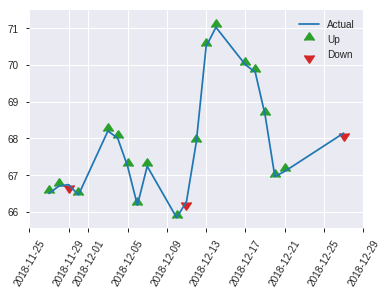


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2539211616646996
RMSE: 0.5039059055664059
LogLoss: 0.7089325618443629
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 345.78564229926025
Residual deviance: 353.0484157984927
AIC: 455.0484157984927
AUC: 0.6562053281351528
pr_auc: 0.5525560070281623
Gini: 0.3124106562703055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5044599425886203: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      46   89   0.6593   (89.0/135.0)
1      14   100  0.1228   (14.0/114.0)
Total  60   189  0.4137   (103.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50446      0.660066  188
max f2                       0.491757     0.811966  245
max f0point5                 0.508685     0.618812  122
max accuracy                 0.508685     0.650602  122
max precision                0.514664     0.634146  40
max recall                   0.491757     1         245
max specificity              0.965713     0.992593  0
max absolute_mcc             0.508685     0.301284  122
max min_per_class_accuracy   0.508727     0.644444  121
max mean_per_class_accuracy  0.508685     0.65117   122

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.76919            0.72807   0.72807            0.333333         0.918301  0.333333                    0.918301            0.00877193      0.00877193                 -27.193   -27.193
    2        0.0200803                   0.589425           1.09211   0.873684           0.5              0.665825  0.4                         0.81731             0.00877193      0.0175439                  9.21053   -12.6316
    3        0.0321285                   0.569781           0.72807   0.819079           0.333333         0.581053  0.375                       0.728714            0.00877193      0.0263158                  -27.193   -18.0921
    4        0.0401606                   0.541064           1.09211   0.873684           0.5              0.561321  0.4                         0.695235            0.00877193      0.0350877                  9.21053   -12.6316
    5        0.0522088                   0.533758           0.72807   0.840081           0.333333         0.53631   0.384615                    0.65856             0.00877193      0.0438596                  -27.193   -15.9919
    6        0.100402                    0.518994           1.63816   1.22316            0.75             0.523841  0.56                        0.593895            0.0789474       0.122807                   63.8158   22.3158
    7        0.15261                     0.515007           1.51215   1.32202            0.692308         0.517343  0.605263                    0.567706            0.0789474       0.201754                   51.2146   32.2022
    8        0.200803                    0.512607           1.09211   1.26684            0.5              0.513713  0.58                        0.554748            0.0526316       0.254386                   9.21053   26.6842
    9        0.301205                    0.510748           1.39789   1.31053            0.64             0.511552  0.6                         0.540349            0.140351        0.394737                   39.7895   31.0526
    10       0.401606                    0.509536           1.39789   1.33237            0.64             0.510207  0.61                        0.532814            0.140351        0.535088                   39.7895   33.2368
    11       0.502008                    0.508504           1.22316   1.31053            0.56             0.509019  0.6                         0.528055            0.122807        0.657895                   22.3158   31.0526
    12       0.598394                    0.506777           0.637061  1.20205            0.291667         0.50763   0.550336                    0.524765            0.0614035       0.719298                   -36.2939  20.2049
    13       0.698795                    0.50565            0.961053  1.16742            0.44             0.506167  0.534483                    0.522093            0.0964912       0.815789                   -3.89474  16.7423
    14       0.799197                    0.503022           0.698947  1.10857            0.32             0.504551  0.507538                    0.519889            0.0701754       0.885965                   -30.1053  10.8569
    15       0.899598                    0.498321           0.611579  1.0531             0.28             0.500805  0.482143                    0.517759            0.0614035       0.947368                   -38.8421  5.31015
    16       1                           0.483366           0.524211  1                  0.24             0.494298  0.457831                    0.515404     

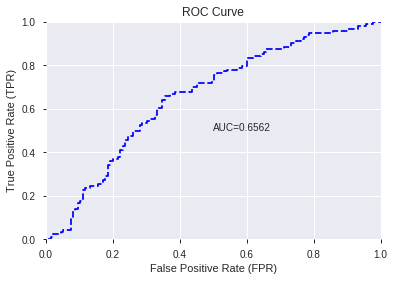

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


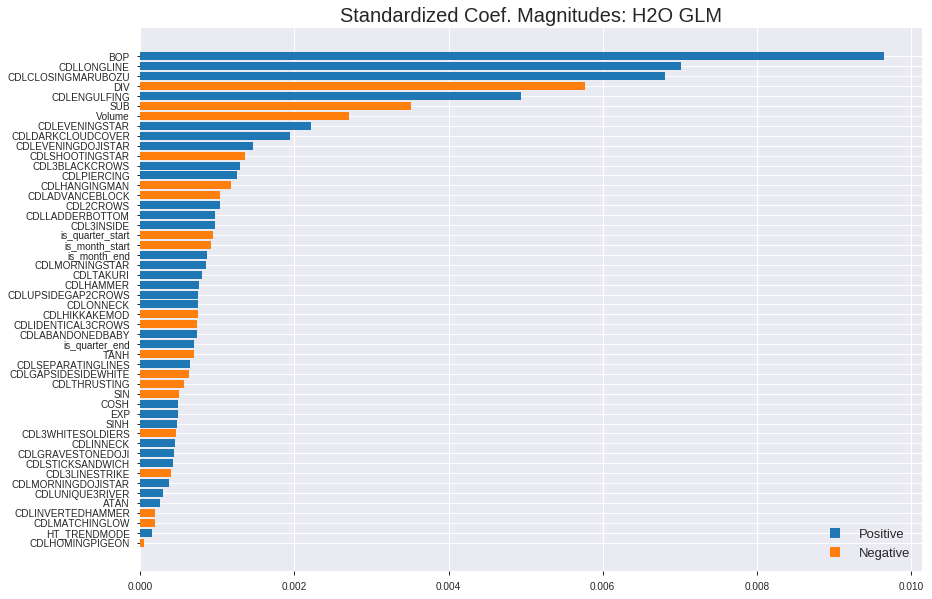

'log_likelihood'
--2019-08-25 12:07:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_120738_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_120738_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'CDLENGULFING',
 'SUB',
 'Volume',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDL3BLACKCROWS',
 'CDLPIERCING',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'CDL2CROWS',
 'CDLLADDERBOTTOM',
 'CDL3INSIDE',
 'is_quarter_start',
 'is_month_start',
 'is_month_end',
 'CDLMORNINGSTAR',
 'CDLTAKURI',
 'CDLHAMMER',
 'CDLUPSIDEGAP2CROWS',
 'CDLONNECK',
 'CDLHIKKAKEMOD',
 'CDLIDENTICAL3CROWS',
 'CDLABANDONEDBABY',
 'is_quarter_end',
 'TANH',
 'CDLSEPARATINGLINES',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'SIN',
 'COSH',
 'EXP',
 'SINH',
 'CDL3WHITESOLDIERS',
 'CDLINNECK',
 'CDLGRAVESTONEDOJI',
 'CDLSTICKSANDWICH',
 'CDL3LINESTRIKE',
 'CDLMORNINGDOJISTAR',
 'CDLUNIQUE3RIVER',
 'ATAN',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW',
 'HT_TRENDMODE',
 'CDLHOMINGPIGEON']

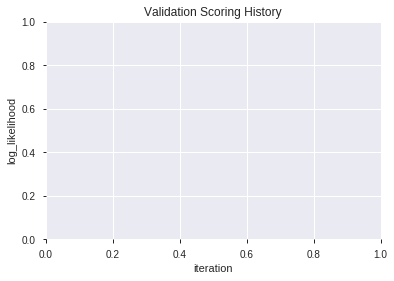

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_120757_model_4  0.668876  0.652154              0.378850  0.480138  0.230532
1               XGBoost_3_AutoML_20190825_120757  0.668421  0.650812              0.366764  0.479639  0.230054
2  XGBoost_grid_1_AutoML_20190825_120757_model_3  0.662768  0.647661              0.372807  0.478405  0.228871
3               XGBoost_2_AutoML_20190825_120757  0.657440  0.653869              0.374854  0.481023  0.231384
4  XGBoost_grid_1_AutoML_20190825_120757_model_2  0.657245  0.654463              0.401072  0.481024  0.231384
5  XGBoost_grid_1_AutoML_20190825_120757_model_7  0.654321  0.656396              0.376803  0.482605  0.232908
6  XGBoost_grid_1_AutoML_20190825_120757_model_6  0.649643  0.659680              0.377193  0.484389  0.234633
7               XGBoost_1_AutoML_20190825_120757  0.647238  0.661329              0.377875  0.484896  0.235124
8  XGBoost_grid_1_AutoML_20190825_120757_model_1  0.642982  0.662448              0.390643  0.485446  0.235658
9  XGBoost_grid_1_AutoML_20190825_120757_model_5  0.613190  0.705817              0.394055  0.501888  0.251891

variable  relative_importance  scaled_importance  percentage
0                 BOP          1559.799438           1.000000    0.467260
1                 DIV           893.491333           0.572824    0.267658
2              Volume           258.674255           0.165838    0.077490
3                 SIN           206.941086           0.132672    0.061992
4                 SUB           202.242584           0.129659    0.060585
5                ATAN           183.131180           0.117407    0.054860
6                TANH            15.778321           0.010116    0.004727
7         CDLLONGLINE            12.555369           0.008049    0.003761
8        HT_TRENDMODE             2.893334           0.001855    0.000867
9  CDLCLOSINGMARUBOZU             2.677421           0.001717    0.000802

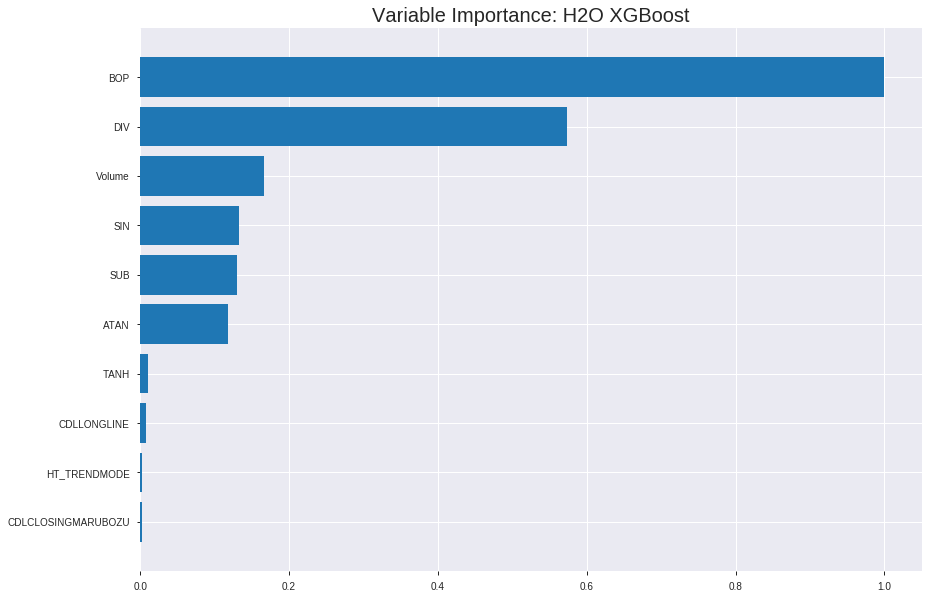

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_120757_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20213768650268907
RMSE: 0.4495972492161057
LogLoss: 0.5904568427922453
Mean Per-Class Error: 0.30726481512278947
AUC: 0.7556233979816218
pr_auc: 0.7385893391585401
Gini: 0.5112467959632436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3836858034133911: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      374  485   0.5646   (485.0/859.0)
1      85   797   0.0964   (85.0/882.0)
Total  459  1282  0.3274   (570.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383686     0.736599  268
max f2                       0.196221     0.849312  369
max f0point5                 0.543624     0.697435  166
max accuracy                 0.543624     0.692705  166
max precision                0.781565     1         0
max recall                   0.144299     1         392
max specificity              0.781565     1         0
max absolute_mcc             0.484401     0.386837  208
max min_per_class_accuracy   0.54209      0.691502  167
max mean_per_class_accuracy  0.543624     0.692735  166

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.761455           1.64494   1.64494            0.833333         0.768219  0.833333                    0.768219            0.0170068       0.0170068                  64.4936   64.4936
    2        0.0201034                   0.754354           1.7417    1.69193            0.882353         0.757577  0.857143                    0.76305             0.0170068       0.0340136                  74.1697   69.1934
    3        0.0304423                   0.746205           1.7546    1.71322            0.888889         0.750267  0.867925                    0.758709            0.0181406       0.0521542                  75.4598   71.3216
    4        0.0402068                   0.74057            1.97392   1.77653            1                0.743113  0.9                         0.754921            0.0192744       0.0714286                  97.3923   77.6531
    5        0.0505457                   0.735013           1.53527   1.72718            0.777778         0.737983  0.875                       0.751456            0.015873        0.0873016                  53.5273   72.7183
    6        0.100517                    0.712813           1.76972   1.74833            0.896552         0.724196  0.885714                    0.737904            0.0884354       0.175737                   76.9724   74.8332
    7        0.150488                    0.693298           1.4067    1.63489            0.712644         0.703699  0.828244                    0.726546            0.0702948       0.246032                   40.6704   63.489
    8        0.20046                     0.665              1.17982   1.52145            0.597701         0.680488  0.770774                    0.715065            0.0589569       0.304989                   17.9816   52.1448
    9        0.300402                    0.621723           1.39536   1.4795             0.706897         0.642803  0.749522                    0.691024            0.139456        0.444444                   39.5359   47.9499
    10       0.400345                    0.586835           1.21385   1.41318            0.614943         0.605103  0.715925                    0.669574            0.121315        0.56576                    21.3849   41.3182
    11       0.500287                    0.543323           1.24788   1.38016            0.632184         0.564859  0.699196                    0.648655            0.124717        0.690476                   24.7882   38.016
    12       0.60023                     0.48661            0.93024   1.30524            0.471264         0.516818  0.661244                    0.626703            0.0929705       0.783447                   -6.97605  30.5245
    13       0.700172                    0.409271           0.850829  1.24038            0.431034         0.450523  0.628384                    0.601555            0.085034        0.868481                   -14.9171  24.0381
    14       0.800115                    0.324998           0.714696  1.17472            0.362069         0.368972  0.595118                    0.572503            0.0714286       0.939909                   -28.5304  17.4718
    15       0.900057                    0.222305           0.374365  1.08585            0.189655         0.271262  0.550096                    0.539053            0.037415        0.977324                   -62.5635  8.58465
    16       1                           0.122997           0.226888  1                  0.114943         0.179654  0.506605                    0.503134           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22184259491225503
RMSE: 0.47100169310975415
LogLoss: 0.6344987238906518
Mean Per-Class Error: 0.33203125
AUC: 0.711236118285124
pr_auc: 0.6923385064471395
Gini: 0.422472236570248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5195094347000122: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  129  0.5331   (129.0/242.0)
1      35   221  0.1367   (35.0/256.0)
Total  148  350  0.3293   (164.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519509     0.729373  267
max f2                       0.237364     0.845491  386
max f0point5                 0.583833     0.673653  201
max accuracy                 0.532317     0.672691  253
max precision                0.767413     1         0
max recall                   0.218169     1         391
max specificity              0.767413     1         0
max absolute_mcc             0.519509     0.361136  267
max min_per_class_accuracy   0.594943     0.652893  186
max mean_per_class_accuracy  0.532317     0.667969  253

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 56.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.739122           1.55625   1.55625            0.8              0.754054  0.8                         0.754054            0.015625        0.015625                   55.625    55.625
    2        0.0200803                   0.735447           1.94531   1.75078            1                0.737596  0.9                         0.745825            0.0195312       0.0351562                  94.5313   75.0781
    3        0.0301205                   0.731521           1.94531   1.81563            1                0.733592  0.933333                    0.741747            0.0195312       0.0546875                  94.5313   81.5625
    4        0.0401606                   0.726804           1.55625   1.75078            0.8              0.729324  0.9                         0.738642            0.015625        0.0703125                  55.625    75.0781
    5        0.0502008                   0.72519            1.16719   1.63406            0.6              0.726202  0.84                        0.736154            0.0117188       0.0820312                  16.7188   63.4063
    6        0.100402                    0.713529           1.32281   1.47844            0.68             0.718964  0.76                        0.727559            0.0664062       0.148438                   32.2813   47.8438
    7        0.150602                    0.703874           1.40063   1.4525             0.72             0.708742  0.746667                    0.721287            0.0703125       0.21875                    40.0625   45.25
    8        0.200803                    0.687106           1.16719   1.38117            0.6              0.695535  0.71                        0.714849            0.0585938       0.277344                   16.7188   38.1172
    9        0.301205                    0.641982           1.36172   1.37469            0.7              0.661165  0.706667                    0.696954            0.136719        0.414062                   36.1719   37.4688
    10       0.399598                    0.622086           1.34981   1.36856            0.693878         0.630905  0.703518                    0.680691            0.132812        0.546875                   34.9809   36.8562
    11       0.5                         0.595248           1.01156   1.29688            0.52             0.608982  0.666667                    0.666291            0.101562        0.648438                   1.15625   29.6875
    12       0.600402                    0.567703           1.12828   1.26868            0.58             0.581212  0.652174                    0.652064            0.113281        0.761719                   12.8281   26.8682
    13       0.698795                    0.521055           0.952806  1.22421            0.489796         0.545194  0.62931                     0.637016            0.09375         0.855469                   -4.71939  22.4205
    14       0.799197                    0.460509           0.6225    1.14861            0.32             0.490908  0.590452                    0.618661            0.0625          0.917969                   -37.75    14.8614
    15       0.899598                    0.35162            0.350156  1.0595             0.18             0.407429  0.544643                    0.595086            0.0351562       0.953125                   -64.9844  5.95006
    16       1                           0.130131           0.466875  1                  0.24             0.267409  0.514056                    0.562187            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:08:14  2.889 sec   0                  0.5              0.693147            0.5             0                  1                0.493395                         0.5                0.693147              0.5               0                    1                  0.485944
    2019-08-25 12:08:14  2.955 sec   5                  0.48434          0.662174            0.730532        0.698762           1.71645          0.336588                         0.488835           0.670999              0.710098          0.686459             1.5032             0.341365
    2019-08-25 12:08:14  2.993 sec   10                 0.474453         0.642657            0.736444        0.7185             1.76972          0.334865                         0.48286            0.659171              0.707491          0.669514             1.21582            0.333333
    2019-08-25 12:08:14  3.049 sec   15                 0.467255         0.628216            0.739627        0.717256           1.86426          0.337737                         0.480316           0.653977              0.70478           0.685709             1.55625            0.327309
    2019-08-25 12:08:14  3.106 sec   20                 0.462528         0.618429            0.740468        0.718952           1.64494          0.334291                         0.477822           0.648828              0.706386          0.684963             1.55625            0.345382
    2019-08-25 12:08:14  3.154 sec   25                 0.459323         0.611652            0.741942        0.720472           1.66225          0.336014                         0.475715           0.644491              0.705869          0.684391             1.55625            0.339357
    2019-08-25 12:08:14  3.202 sec   30                 0.457112         0.60691             0.744464        0.726278           1.66225          0.336014                         0.473935           0.640798              0.70599           0.684623             1.55625            0.34739
    2019-08-25 12:08:14  3.250 sec   35                 0.455239         0.6028              0.746704        0.729558           1.64494          0.329696                         0.473462           0.639623              0.707628          0.686514             1.29688            0.343373
    2019-08-25 12:08:14  3.310 sec   40                 0.453714         0.599421            0.748691        0.731413           1.53527          0.33027                          0.472742           0.638071              0.709824          0.685771             1.16719            0.337349
    2019-08-25 12:08:14  3.376 sec   45                 0.452303         0.59626             0.750461        0.733296           1.53527          0.333716                         0.472145           0.636829              0.710445          0.688399             1.16719            0.335341
    2019-08-25 12:08:14  3.439 sec   50                 0.450755         0.592982            0.753955        0.736942           1.53527          0.326249                         0.471206           0.634999              0.710542          0.688585             1.55625            0.341365
    2019-08-25 12:08:14  3.505 sec   55                 0.449597         0.590457            0.755623        0.738589           1.64494          0.327398                         0.471002           0.634499              0.711236          0.

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 1559.8                 1                    0.46726
DIV                 893.491                0.572824             0.267658
Volume              258.674                0.165838             0.0774895
SIN                 206.941                0.132672             0.0619921
SUB                 202.243                0.129659             0.0605846
ATAN                183.131                0.117407             0.0548595
TANH                15.7783                0.0101156            0.00472662
CDLLONGLINE         12.5554                0.00804935           0.00376114
HT_TRENDMODE        2.89333                0.00185494           0.000866739
CDLCLOSINGMARUBOZU  2.67742                0.00171652           0.000802059

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.642570281124498)

('F1', 0.6793650793650793)

('auc', 0.6688758934372969)

('logloss', 0.6521541749575992)

('mean_per_class_error', 0.35350877192982455)

('rmse', 0.4801376416009718)

('mse', 0.23053215488214324)

xgboost prediction progress: |████████████████████████████████████████████| 100%


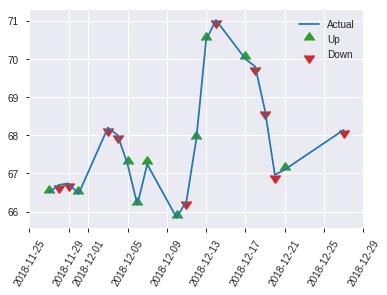


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23053215488214324
RMSE: 0.4801376416009718
LogLoss: 0.6521541749575992
Mean Per-Class Error: 0.35350877192982455
AUC: 0.6688758934372969
pr_auc: 0.5921753222300846
Gini: 0.33775178687459384
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3480125367641449: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      41   94   0.6963   (94.0/135.0)
1      7    107  0.0614   (7.0/114.0)
Total  48   201  0.4056   (101.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348013     0.679365  197
max f2                       0.300785     0.823442  214
max f0point5                 0.543361     0.611455  130
max accuracy                 0.543361     0.64257   130
max precision                0.765921     1         0
max recall                   0.179303     1         240
max specificity              0.765921     1         0
max absolute_mcc             0.348013     0.306023  197
max min_per_class_accuracy   0.564951     0.622807  118
max mean_per_class_accuracy  0.543361     0.646491  130

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.742132           2.18421   2.18421            1                0.754152  1                           0.754152            0.0263158       0.0263158                  118.421   118.421
    2        0.0200803                   0.734517           1.09211   1.74737            0.5              0.738266  0.8                         0.747797            0.00877193      0.0350877                  9.21053   74.7368
    3        0.0321285                   0.73012            0.72807   1.36513            0.333333         0.732258  0.625                       0.74197             0.00877193      0.0438596                  -27.193   36.5132
    4        0.0401606                   0.72821            1.09211   1.31053            0.5              0.730048  0.6                         0.739586            0.00877193      0.0526316                  9.21053   31.0526
    5        0.0522088                   0.727099           1.45614   1.34413            0.666667         0.727506  0.615385                    0.736798            0.0175439       0.0701754                  45.614    34.413
    6        0.100402                    0.714321           1.82018   1.57263            0.833333         0.721117  0.72                        0.729271            0.0877193       0.157895                   82.0175   57.2632
    7        0.15261                     0.699887           1.17611   1.43698            0.538462         0.707407  0.657895                    0.721791            0.0614035       0.219298                   17.6113   43.6981
    8        0.200803                    0.672392           1.27412   1.39789            0.583333         0.689349  0.64                        0.714005            0.0614035       0.280702                   27.4123   39.7895
    9        0.301205                    0.624865           1.04842   1.2814             0.48             0.645016  0.586667                    0.691009            0.105263        0.385965                   4.84211   28.1404
    10       0.401606                    0.590614           1.39789   1.31053            0.64             0.605806  0.6                         0.669708            0.140351        0.526316                   39.7895   31.0526
    11       0.502008                    0.556972           1.13579   1.27558            0.52             0.575998  0.584                       0.650966            0.114035        0.640351                   13.5789   27.5579
    12       0.598394                    0.505885           0.910088  1.21671            0.416667         0.532904  0.557047                    0.631949            0.0877193       0.72807                    -8.99123  21.6708
    13       0.698795                    0.430837           0.786316  1.15487            0.36             0.469147  0.528736                    0.608558            0.0789474       0.807018                   -21.3684  15.487
    14       0.799197                    0.350808           1.13579   1.15247            0.52             0.392757  0.527638                    0.581448            0.114035        0.921053                   13.5789   15.2473
    15       0.899598                    0.285561           0.524211  1.08235            0.24             0.319833  0.495536                    0.55225             0.0526316       0.973684                   -47.5789  8.23543
    16       1                           0.141753           0.262105  1                  0.12             0.228198  0.457831                    0.519714           

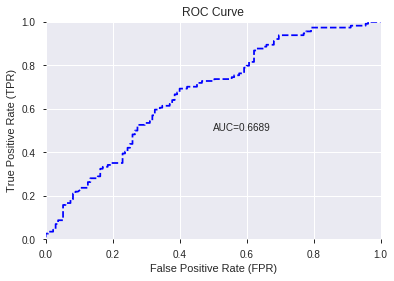

This function is available for GLM models only


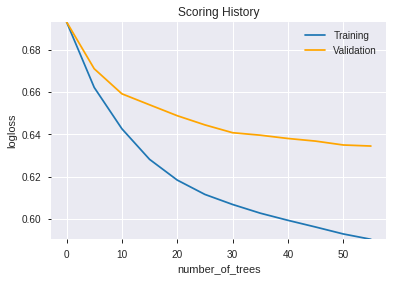

--2019-08-25 12:08:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_120757_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_120757_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'Volume',
 'SIN',
 'SUB',
 'ATAN',
 'TANH',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_120843_model_1  0.55666  0.702685              0.485867  0.503206  0.253217

variable  relative_importance  scaled_importance  percentage
0                          BOP             0.008956           1.000000    0.028125
1                  CDLLONGLINE             0.006490           0.724623    0.020380
2           CDLCLOSINGMARUBOZU             0.006403           0.714972    0.020108
3                  CDLBELTHOLD             0.005995           0.669410    0.018827
4                 STOCHF_fastk             0.005562           0.621061    0.017467
...                        ...                  ...                ...         ...
1040  BBANDS_middleband_30_2_3             0.000000           0.000000    0.000000
1041  BBANDS_middleband_30_2_4             0.000000           0.000000    0.000000
1042  BBANDS_middleband_30_2_5             0.000000           0.000000    0.000000
1043              CDLTASUKIGAP             0.000000           0.000000    0.000000
1044                    SUM_24             0.000000           0.000000    0.000000

[1045 rows x 4 columns]

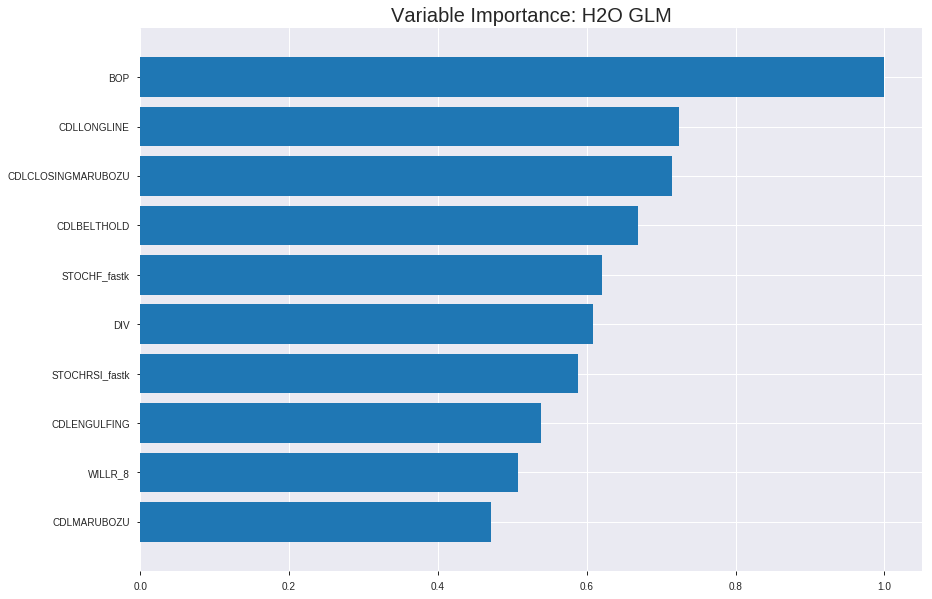

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_120843_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24333338571358065
RMSE: 0.4932883393245584
LogLoss: 0.6797680681322791
Null degrees of freedom: 1740
Residual degrees of freedom: 703
Null deviance: 2413.2346255079065
Residual deviance: 2366.952413236596
AIC: 4442.952413236596
AUC: 0.6300462753980133
pr_auc: 0.6169044525661326
Gini: 0.26009255079602656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4692205301157328: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      187  672   0.7823   (672.0/859.0)
1      71   811   0.0805   (71.0/882.0)
Total  258  1483  0.4268   (743.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469221     0.685835  317
max f2                       0.428806     0.837925  395
max f0point5                 0.497654     0.606682  229
max accuracy                 0.497654     0.598507  229
max precision                0.574646     0.785714  8
max recall                   0.428806     1         395
max specificity              0.592754     0.998836  0
max absolute_mcc             0.497654     0.198888  229
max min_per_class_accuracy   0.507007     0.585034  196
max mean_per_class_accuracy  0.497654     0.597093  229

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.573332           1.42561   1.42561            0.722222         0.5784    0.722222                    0.5784              0.0147392       0.0147392                  42.5611   42.5611
    2        0.0201034                   0.569082           1.39336   1.40994            0.705882         0.571426  0.714286                    0.575012            0.0136054       0.0283447                  39.3357   40.9945
    3        0.0304423                   0.564341           0.986961  1.26629            0.5              0.566111  0.641509                    0.571989            0.0102041       0.0385488                  -1.30385  26.629
    4        0.0402068                   0.561563           1.50947   1.32535            0.764706         0.562721  0.671429                    0.569738            0.0147392       0.053288                   50.947    32.5348
    5        0.0505457                   0.559858           1.20629   1.30099            0.611111         0.560739  0.659091                    0.567898            0.0124717       0.0657596                  20.6286   30.0995
    6        0.100517                    0.551873           1.58821   1.44378            0.804598         0.555932  0.731429                    0.561949            0.0793651       0.145125                   58.8214   44.3784
    7        0.150488                    0.544351           1.29326   1.3938             0.655172         0.547908  0.706107                    0.557286            0.0646259       0.209751                   29.326    39.3801
    8        0.20046                     0.538215           1.06637   1.31218            0.54023          0.541219  0.664756                    0.553281            0.053288        0.263039                   6.63721   31.2178
    9        0.300402                    0.526669           1.13444   1.25304            0.574713         0.532511  0.634799                    0.546371            0.113379        0.376417                   13.4438   25.3045
    10       0.400345                    0.51643            1.04368   1.20078            0.528736         0.521533  0.608321                    0.54017             0.104308        0.480726                   4.36834   20.0779
    11       0.500287                    0.506956           1.04368   1.1694             0.528736         0.511207  0.592423                    0.534384            0.104308        0.585034                   4.36834   16.9396
    12       0.60023                     0.49811            1.08906   1.15602            0.551724         0.50233   0.585646                    0.529047            0.108844        0.693878                   8.90609   15.602
    13       0.700172                    0.488639           0.839484  1.11084            0.425287         0.493534  0.562756                    0.523978            0.0839002       0.777778                   -16.0516  11.0838
    14       0.800115                    0.475459           0.896206  1.08403            0.454023         0.481911  0.549174                    0.518723            0.0895692       0.867347                   -10.3794  8.4028
    15       0.900057                    0.459662           0.805451  1.05309            0.408046         0.468456  0.533504                    0.513142            0.0804989       0.947846                   -19.4549  5.30948
    16       1                           0.417884           0.521842  1                  0.264368         0.447742  0.506605                    0.506605            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.37349246202456104
RMSE: 0.6111402965150973
LogLoss: 7.83026457040619
Null degrees of freedom: 497
Residual degrees of freedom: -540
Null deviance: 690.0915890932606
Residual deviance: 145268.912262133
AIC: 147344.912262133
AUC: 0.49386621900826444
pr_auc: 0.3079026627135361
Gini: -0.01226756198347112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44308041228505635: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   232  0.9587   (232.0/242.0)
1      3    253  0.0117   (3.0/256.0)
Total  13   485  0.4719   (235.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.44308      0.682861   278
max f2                       0.422961     0.843215   287
max f0point5                 0.487288     0.580534   235
max accuracy                 0.49928      0.544177   218
max precision                0.49928      0.534118   218
max recall                   0.422961     1          287
max specificity              1            0.566116   0
max absolute_mcc             0.487288     0.0990319  235
max min_per_class_accuracy   0.609315     0.475207   42
max mean_per_class_accuracy  0.49928      0.534268   218

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 74.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.401606                    1                  0.953203  0.953203           0.49             1         0.49                        1                   0.382812        0.382812                   -4.67969   -4.67969
    2        0.5                         0.609117           0.952806  0.953125           0.489796         0.922865  0.48996                     0.984821            0.09375         0.476562                   -4.71939   -4.6875
    3        0.600402                    0.543879           1.28391   1.00844            0.66             0.556943  0.518395                    0.913269            0.128906        0.605469                   28.3906    0.843959
    4        0.698795                    0.527733           0.992506  1.0062             0.510204         0.534288  0.517241                    0.859907            0.0976562       0.703125                   -0.749362  0.619612
    5        0.799197                    0.509941           1.12828   1.02153            0.58             0.519312  0.525126                    0.817119            0.113281        0.816406                   12.8281    2.15334
    6        0.899598                    0.485414           1.01156   1.02042            0.52             0.499078  0.524554                    0.781623            0.101562        0.917969                   1.15625    2.04206
    7        1                           0.407584           0.817031  1                  0.42             0.459612  0.514056                    0.749293            0.0820312       1                          -18.2969   0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:08:46  0.000 sec   2            16        1038          1.35954           291.705
    2019-08-25 12:08:48  1.991 sec   4            12        1045          1.35343           297.277
    2019-08-25 12:08:50  3.955 sec   6            8.4       1045          1.3462            300.161
    2019-08-25 12:08:52  5.942 sec   8            6.1       1046          1.33769           300.35
    2019-08-25 12:08:54  7.951 sec   10           4.4       1046          1.32782           300.578

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5783132530120482)

('F1', 0.6330532212885154)

('auc', 0.5566601689408708)

('logloss', 0.7026846520592197)

('mean_per_class_error', 0.4447368421052631)

('rmse', 0.5032062268587776)

('mse', 0.2532165067494475)

glm prediction progress: |████████████████████████████████████████████████| 100%


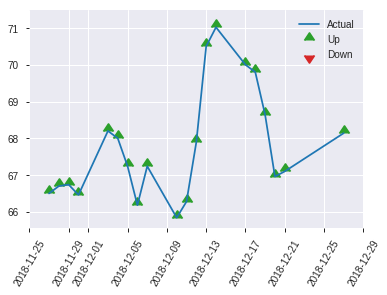


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2532165067494475
RMSE: 0.5032062268587776
LogLoss: 0.7026846520592197
Null degrees of freedom: 248
Residual degrees of freedom: -789
Null deviance: 345.78564229926025
Residual deviance: 349.9369567254914
AIC: 2425.9369567254917
AUC: 0.5566601689408708
pr_auc: 0.49772170175949426
Gini: 0.11332033788174156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4730862136729849: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    130  0.963    (130.0/135.0)
1      1    113  0.0088   (1.0/114.0)
Total  6    243  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473086     0.633053  242
max f2                       0.470664     0.810811  246
max f0point5                 0.504871     0.531496  161
max accuracy                 0.54298      0.578313  46
max precision                0.557166     0.636364  21
max recall                   0.470664     1         246
max specificity              0.906914     0.992593  0
max absolute_mcc             0.54298      0.133524  46
max min_per_class_accuracy   0.5155       0.548148  123
max mean_per_class_accuracy  0.504871     0.555263  161

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 52.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.718982           0.72807   0.72807            0.333333         0.849913  0.333333                    0.849913            0.00877193      0.00877193                 -27.193   -27.193
    2        0.0200803                   0.597751           1.09211   0.873684           0.5              0.638175  0.4                         0.765218            0.00877193      0.0175439                  9.21053   -12.6316
    3        0.0321285                   0.58422            0         0.546053           0                0.59079   0.25                        0.699808            0               0.0175439                  -100      -45.3947
    4        0.0401606                   0.576242           2.18421   0.873684           1                0.579889  0.4                         0.675824            0.0175439       0.0350877                  118.421   -12.6316
    5        0.0522088                   0.56413            0.72807   0.840081           0.333333         0.568476  0.384615                    0.651051            0.00877193      0.0438596                  -27.193   -15.9919
    6        0.100402                    0.554296           1.82018   1.31053            0.833333         0.558629  0.6                         0.606688            0.0877193       0.131579                   82.0175   31.0526
    7        0.15261                     0.546744           1.0081    1.20706            0.461538         0.550394  0.552632                    0.58743             0.0526316       0.184211                   0.809717  20.7064
    8        0.200803                    0.54208            1.45614   1.26684            0.666667         0.544117  0.58                        0.577035            0.0701754       0.254386                   45.614    26.6842
    9        0.301205                    0.529006           0.698947  1.07754            0.32             0.534858  0.493333                    0.562976            0.0701754       0.324561                   -30.1053  7.75439
    10       0.401606                    0.522782           1.04842   1.07026            0.48             0.525886  0.49                        0.553704            0.105263        0.429825                   4.84211   7.02632
    11       0.502008                    0.515036           1.31053   1.11832            0.6              0.519335  0.512                       0.54683             0.131579        0.561404                   31.0526   11.8316
    12       0.598394                    0.50747            0.819079  1.07012            0.375            0.511645  0.489933                    0.541162            0.0789474       0.640351                   -18.0921  7.01166
    13       0.698795                    0.501453           0.873684  1.04189            0.4              0.504707  0.477011                    0.535925            0.0877193       0.72807                    -12.6316  4.18935
    14       0.799197                    0.493763           0.873684  1.02076            0.4              0.49789   0.467337                    0.531146            0.0877193       0.815789                   -12.6316  2.07617
    15       0.899598                    0.484908           0.961053  1.0141             0.44             0.489062  0.464286                    0.526449            0.0964912       0.912281                   -3.89474  1.40977
    16       1                           0.45996            0.873684  1                  0.4              0.477197  0.457831                    0.521504     

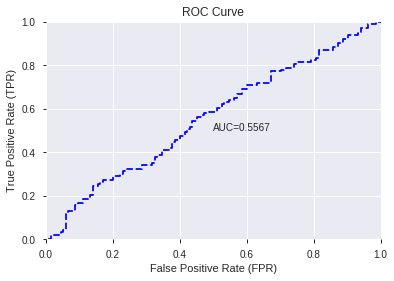

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


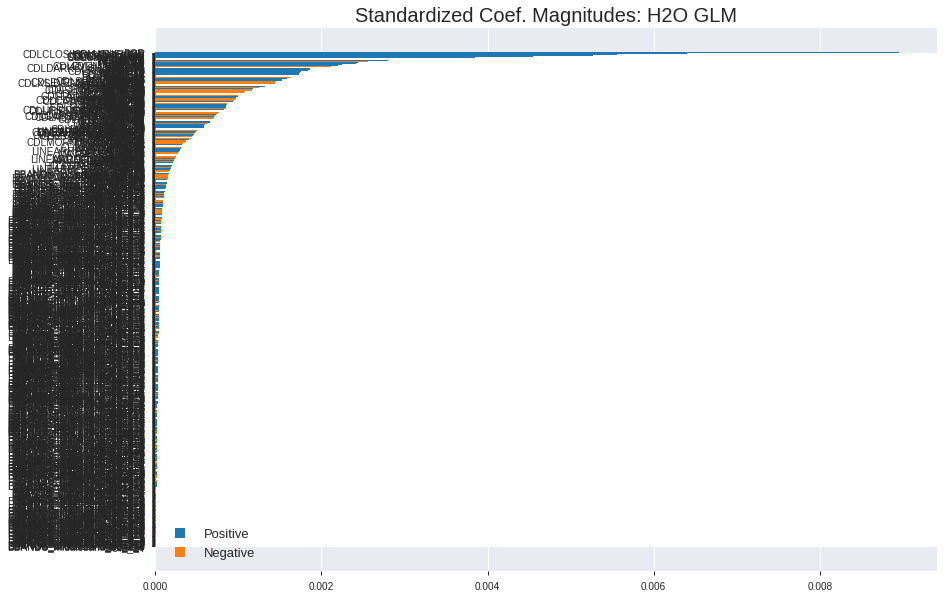

'log_likelihood'
--2019-08-25 12:09:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_120843_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_120843_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

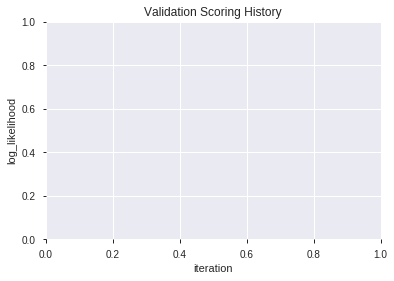

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_120936_model_6  0.664587  0.658940              0.389961  0.482823  0.233119
1  XGBoost_grid_1_AutoML_20190825_120936_model_4  0.662898  0.653181              0.379532  0.480505  0.230885
2  XGBoost_grid_1_AutoML_20190825_120936_model_3  0.650812  0.663591              0.393665  0.485450  0.235662
3  XGBoost_grid_1_AutoML_20190825_120936_model_7  0.648798  0.664661              0.424269  0.486129  0.236321
4               XGBoost_2_AutoML_20190825_120936  0.648668  0.657895              0.410819  0.482897  0.233190
5  XGBoost_grid_1_AutoML_20190825_120936_model_2  0.647238  0.663875              0.413840  0.485702  0.235907
6               XGBoost_3_AutoML_20190825_120936  0.637492  0.667620              0.392008  0.487327  0.237488
7               XGBoost_1_AutoML_20190825_120936  0.629370  0.674135              0.404094  0.490996  0.241077
8  XGBoost_grid_1_AutoML_20190825_120936_model_1  0.619818  0.681478              0.404776  0.493295  0.243340
9  XGBoost_grid_1_AutoML_20190825_120936_model_5  0.613450  0.675943              0.396686  0.491592  0.241663

variable  relative_importance  scaled_importance  percentage
0                        BOP          1159.323120           1.000000    0.125855
1                        DIV           861.317017           0.742948    0.093504
2                        COS           137.863785           0.118917    0.014966
3                  CORREL_12           116.198158           0.100229    0.012614
4                   WILLR_12           107.310883           0.092563    0.011650
..                       ...                  ...                ...         ...
267   BBANDS_upperband_8_0_5             3.866518           0.003335    0.000420
268               MINUS_DM_8             3.114857           0.002687    0.000338
269  BBANDS_upperband_14_3_5             2.612354           0.002253    0.000284
270                   TSF_30             2.401688           0.002072    0.000261
271   BBANDS_upperband_8_0_3             1.962276           0.001693    0.000213

[272 rows x 4 columns]

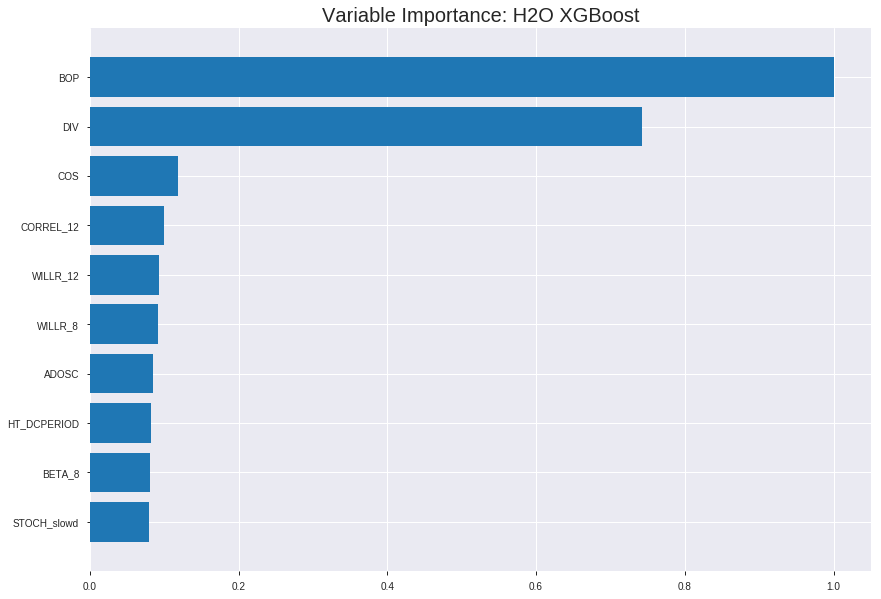

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_120936_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14652624923256818
RMSE: 0.3827874726693236
LogLoss: 0.46912970836117696
Mean Per-Class Error: 0.15042342121171326
AUC: 0.9298154263645699
pr_auc: 0.9371531224045946
Gini: 0.8596308527291399
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49354439228773117: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      685  174  0.2026   (174.0/859.0)
1      98   784  0.1111   (98.0/882.0)
Total  783  958  0.1562   (272.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493544     0.852174  203
max f2                       0.384863     0.897034  268
max f0point5                 0.58177      0.876289  152
max accuracy                 0.517611     0.849512  188
max precision                0.882916     1         0
max recall                   0.274598     1         323
max specificity              0.882916     1         0
max absolute_mcc             0.517611     0.699092  188
max min_per_class_accuracy   0.516257     0.848073  189
max mean_per_class_accuracy  0.517611     0.849577  188

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.833533           1.97392   1.97392            1                0.853393  1                           0.853393            0.0204082       0.0204082                  97.3923   97.3923
    2        0.0201034                   0.81715            1.97392   1.97392            1                0.824705  1                           0.839459            0.0192744       0.0396825                  97.3923   97.3923
    3        0.0304423                   0.801773           1.97392   1.97392            1                0.808342  1                           0.828891            0.0204082       0.0600907                  97.3923   97.3923
    4        0.0402068                   0.792939           1.97392   1.97392            1                0.796937  1                           0.821131            0.0192744       0.0793651                  97.3923   97.3923
    5        0.0505457                   0.785241           1.97392   1.97392            1                0.789344  1                           0.814629            0.0204082       0.0997732                  97.3923   97.3923
    6        0.100517                    0.750638           1.97392   1.97392            1                0.767662  1                           0.79128             0.0986395       0.198413                   97.3923   97.3923
    7        0.150488                    0.724787           1.97392   1.97392            1                0.737348  1                           0.773371            0.0986395       0.297052                   97.3923   97.3923
    8        0.20046                     0.697524           1.95123   1.96827            0.988506         0.710551  0.997135                    0.757711            0.0975057       0.394558                   95.1234   96.8267
    9        0.300402                    0.636164           1.8151    1.91731            0.91954          0.665396  0.971319                    0.726998            0.181406        0.575964                   81.5102   91.7309
    10       0.400345                    0.582037           1.52015   1.81816            0.770115         0.60972   0.92109                     0.697721            0.151927        0.727891                   52.0148   81.8161
    11       0.500287                    0.516615           1.17982   1.69064            0.597701         0.548783  0.856487                    0.667967            0.117914        0.845805                   17.9816   69.0639
    12       0.60023                     0.46287            0.714696  1.52814            0.362069         0.491565  0.774163                    0.638595            0.0714286       0.917234                   -28.5304  52.8137
    13       0.700172                    0.398896           0.453775  1.37478            0.229885         0.430637  0.696473                    0.608911            0.0453515       0.962585                   -54.6225  37.4783
    14       0.800115                    0.320944           0.226888  1.2314             0.114943         0.363381  0.623833                    0.578242            0.0226757       0.985261                   -77.3112  23.1399
    15       0.900057                    0.22331            0.147477  1.11104            0.0747126        0.272589  0.562859                    0.544302            0.0147392       1                          -85.2523  11.104
    16       1                           0.0816612          0         1                  0                0.17055   0.506605                    0.506949          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2222023662586082
RMSE: 0.47138345989078595
LogLoss: 0.6356807512547771
Mean Per-Class Error: 0.3243155991735538
AUC: 0.7130681818181818
pr_auc: 0.6822326790795615
Gini: 0.42613636363636354
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45081621408462524: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      74   168  0.6942   (168.0/242.0)
1      14   242  0.0547   (14.0/256.0)
Total  88   410  0.3655   (182.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450816     0.726727  318
max f2                       0.397056     0.854817  355
max f0point5                 0.606391     0.688869  162
max accuracy                 0.587725     0.674699  183
max precision                0.792325     1         0
max recall                   0.309626     1         387
max specificity              0.792325     1         0
max absolute_mcc             0.587725     0.351869  183
max min_per_class_accuracy   0.58305      0.664062  192
max mean_per_class_accuracy  0.587725     0.675684  183

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 56.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.744453           1.94531   1.94531            1                0.766822  1                           0.766822            0.0195312       0.0195312                  94.5313   94.5313
    2        0.0200803                   0.727958           1.55625   1.75078            0.8              0.735812  0.9                         0.751317            0.015625        0.0351562                  55.625    75.0781
    3        0.0301205                   0.723026           1.16719   1.55625            0.6              0.724867  0.8                         0.7425              0.0117188       0.046875                   16.7188   55.625
    4        0.0401606                   0.718528           1.55625   1.55625            0.8              0.720944  0.8                         0.737111            0.015625        0.0625                     55.625    55.625
    5        0.0502008                   0.710533           1.16719   1.47844            0.6              0.715518  0.76                        0.732792            0.0117188       0.0742188                  16.7188   47.8438
    6        0.100402                    0.692676           1.16719   1.32281            0.6              0.700916  0.68                        0.716854            0.0585938       0.132812                   16.7188   32.2813
    7        0.150602                    0.671643           1.63406   1.42656            0.84             0.681464  0.733333                    0.705057            0.0820312       0.214844                   63.4063   42.6562
    8        0.200803                    0.65431            1.32281   1.40063            0.68             0.664487  0.72                        0.694915            0.0664062       0.28125                    32.2813   40.0625
    9        0.301205                    0.628681           1.36172   1.38766            0.7              0.640571  0.713333                    0.6768              0.136719        0.417969                   36.1719   38.7656
    10       0.399598                    0.610702           1.42921   1.39789            0.734694         0.619624  0.718593                    0.662721            0.140625        0.558594                   42.9209   39.7888
    11       0.5                         0.58305            1.01156   1.32031            0.52             0.595312  0.678715                    0.649185            0.101562        0.660156                   1.15625   32.0313
    12       0.600402                    0.552945           0.855938  1.24266            0.44             0.567797  0.638796                    0.635575            0.0859375       0.746094                   -14.4062  24.2658
    13       0.698795                    0.518896           0.913106  1.19626            0.469388         0.538293  0.614943                    0.621878            0.0898438       0.835938                   -8.68941  19.6255
    14       0.799197                    0.465668           0.817031  1.14861            0.42             0.493499  0.590452                    0.60575             0.0820312       0.917969                   -18.2969  14.8614
    15       0.899598                    0.398574           0.583594  1.08555            0.3              0.431905  0.558036                    0.586347            0.0585938       0.976562                   -41.6406  8.55539
    16       1                           0.186115           0.233438  1                  0.12             0.333882  0.514056                    0.560999           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:10:16  24.609 sec  0                  0.5              0.693147            0.5             0                  1                0.493395                         0.5                0.693147              0.5               0                    1                  0.485944
    2019-08-25 12:10:17  25.174 sec  5                  0.475286         0.644638            0.828308        0.831738           1.97392          0.253303                         0.489985           0.673247              0.686523          0.659356             1.16719            0.391566
    2019-08-25 12:10:17  25.377 sec  10                 0.458268         0.611733            0.83683         0.843713           1.97392          0.253303                         0.482245           0.657985              0.721559          0.692717             1.55625            0.299197
    2019-08-25 12:10:17  25.611 sec  15                 0.442559         0.581644            0.858246        0.867333           1.97392          0.234348                         0.479263           0.652008              0.708904          0.673432             1.16719            0.345382
    2019-08-25 12:10:18  25.856 sec  20                 0.4316           0.560584            0.869204        0.878272           1.97392          0.220563                         0.476271           0.645995              0.713754          0.683622             1.55625            0.329317
    2019-08-25 12:10:18  26.043 sec  25                 0.420705         0.539715            0.882126        0.891889           1.97392          0.203906                         0.475335           0.643982              0.70415           0.674003             1.94531            0.331325
    2019-08-25 12:10:18  26.255 sec  30                 0.412018         0.523364            0.895682        0.905246           1.97392          0.198736                         0.473846           0.640951              0.702003          0.664466             1.55625            0.343373
    2019-08-25 12:10:18  26.605 sec  35                 0.404135         0.508339            0.90499         0.914613           1.97392          0.186674                         0.473215           0.639608              0.708234          0.667568             1.55625            0.351406
    2019-08-25 12:10:19  26.817 sec  40                 0.396376         0.493639            0.912662        0.921756           1.97392          0.18093                          0.473616           0.640517              0.703997          0.654924             1.16719            0.369478
    2019-08-25 12:10:19  27.020 sec  45                 0.388887         0.480392            0.924705        0.931476           1.97392          0.160827                         0.473046           0.639108              0.704844          0.672995             1.94531            0.369478
    2019-08-25 12:10:19  27.232 sec  50                 0.382787         0.46913             0.929815        0.937153           1.97392          0.156232                         0.471383           0.635681              0.713068          0.682233             1.94531            0.365462

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1159.3231201171875     1.0                    0.12585510866447075
DIV                      861.3170166015625      0.742948192488819      0.09350382549775246
COS                      137.86378479003906     0.11891748072453125    0.014966372458690987
CORREL_12                116.19815826416016     0.10022931161108435    0.012614370904178121
WILLR_12                 107.31088256835938     0.09256339385132947    0.011649575991511275
---                      ---                    ---                    ---
BBANDS_upperband_8_0_5   3.866518020629883      0.003335151308152161   0.00041974583029994204
MINUS_DM_8               3.1148571968078613     0.002686789509117185   0.00033814618562850334
BBANDS_upperband_14_3_5  2.612353563308716      0.0022533437986164305  0.0002835948286332822
TSF_30                   2.4016876220703125     0.0020716291949974598  0.0002607251174488954
BBANDS_upperband_8_0_3   1.9622762203216553     0.001692605095396789   0.00021302299820719978


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6385542168674698)

('F1', 0.6729559748427674)

('auc', 0.6645873944119559)

('logloss', 0.6589400694954755)

('mean_per_class_error', 0.36608187134502923)

('rmse', 0.4828234925958785)

('mse', 0.2331185250024823)

xgboost prediction progress: |████████████████████████████████████████████| 100%


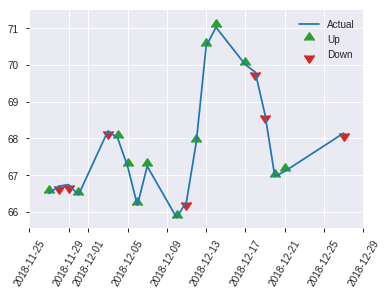


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2331185250024823
RMSE: 0.4828234925958785
LogLoss: 0.6589400694954755
Mean Per-Class Error: 0.36608187134502923
AUC: 0.6645873944119559
pr_auc: 0.5898705026140443
Gini: 0.3291747888239118
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3843023180961609: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      38   97   0.7185   (97.0/135.0)
1      7    107  0.0614   (7.0/114.0)
Total  45   204  0.4177   (104.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384302     0.672956  203
max f2                       0.34464      0.816176  223
max f0point5                 0.576228     0.604396  107
max accuracy                 0.576228     0.638554  107
max precision                0.675133     0.75      35
max recall                   0.151578     1         248
max specificity              0.799734     0.992593  0
max absolute_mcc             0.384302     0.284954  203
max min_per_class_accuracy   0.546799     0.614035  118
max mean_per_class_accuracy  0.576228     0.633918  107

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 52.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.759607           0.72807   0.72807            0.333333         0.780921  0.333333                    0.780921            0.00877193      0.00877193                 -27.193   -27.193
    2        0.0200803                   0.747766           1.09211   0.873684           0.5              0.756882  0.4                         0.771306            0.00877193      0.0175439                  9.21053   -12.6316
    3        0.0321285                   0.742158           1.45614   1.09211            0.666667         0.744715  0.5                         0.761334            0.0175439       0.0350877                  45.614    9.21053
    4        0.0401606                   0.734857           2.18421   1.31053            1                0.739953  0.6                         0.757058            0.0175439       0.0526316                  118.421   31.0526
    5        0.0522088                   0.730282           1.45614   1.34413            0.666667         0.73347   0.615385                    0.751615            0.0175439       0.0701754                  45.614    34.413
    6        0.100402                    0.689494           1.82018   1.57263            0.833333         0.710634  0.72                        0.731944            0.0877193       0.157895                   82.0175   57.2632
    7        0.15261                     0.672495           1.68016   1.60942            0.769231         0.679976  0.736842                    0.714166            0.0877193       0.245614                   68.0162   60.9418
    8        0.200803                    0.6529             0.72807   1.39789            0.333333         0.662136  0.64                        0.701678            0.0350877       0.280702                   -27.193   39.7895
    9        0.301205                    0.610372           1.39789   1.39789            0.64             0.62952   0.64                        0.677626            0.140351        0.421053                   39.7895   39.7895
    10       0.401606                    0.586441           1.13579   1.33237            0.52             0.599289  0.61                        0.658042            0.114035        0.535088                   13.5789   33.2368
    11       0.502008                    0.540553           0.786316  1.22316            0.36             0.563014  0.56                        0.639036            0.0789474       0.614035                   -21.3684  22.3158
    12       0.598394                    0.492971           0.819079  1.15807            0.375            0.517057  0.530201                    0.619388            0.0789474       0.692982                   -18.0921  15.8071
    13       0.698795                    0.462187           1.04842   1.14232            0.48             0.474239  0.522989                    0.598534            0.105263        0.798246                   4.84211   14.2317
    14       0.799197                    0.405965           1.13579   1.1415             0.52             0.434775  0.522613                    0.577961            0.114035        0.912281                   13.5789   14.1497
    15       0.899598                    0.344634           0.611579  1.08235            0.28             0.370885  0.495536                    0.55485             0.0614035       0.973684                   -38.8421  8.23543
    16       1                           0.151578           0.262105  1                  0.12             0.264875  0.457831                    0.525736         

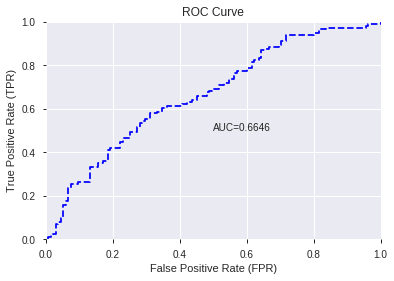

This function is available for GLM models only


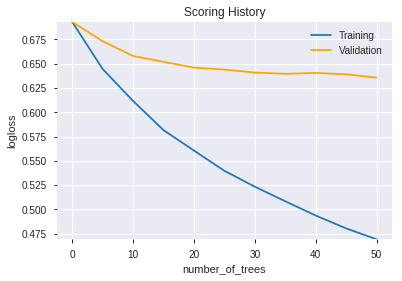

--2019-08-25 12:10:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.32
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.32|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_120936_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_120936_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_121039_model_9  0.680312  0.651084              0.389669  0.479508  0.229928
1  DeepLearning_grid_1_AutoML_20190825_121039_model_6  0.648993  0.721564              0.409844  0.483893  0.234153
2               DeepLearning_1_AutoML_20190825_121039  0.644314  1.208910              0.361891  0.500099  0.250099
3  DeepLearning_grid_1_AutoML_20190825_121039_model_5  0.644185  0.916173              0.400487  0.494852  0.244879
4  DeepLearning_grid_1_AutoML_20190825_121039_model_8  0.643502  0.836516              0.379630  0.490441  0.240532
5  DeepLearning_grid_1_AutoML_20190825_121039_model_7  0.640091  0.795327              0.374854  0.525803  0.276469
6  DeepLearning_grid_1_AutoML_20190825_121039_model_2  0.628330  2.012019              0.388012  0.517955  0.268277
7  DeepLearning_grid_1_AutoML_20190825_121039_model_4  0.627485  1.098934              0.416277  0.532191  0.283228
8  DeepLearning_grid_1_AutoML_20190825_121039_model_1  0.624366  1.380637              0.374951  0.538218  0.289678
9  DeepLearning_grid_1_AutoML_20190825_121039_model_3  0.615140  1.823479              0.486550  0.514473  0.264682

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.037447
1                   DIV             0.805211           0.805211    0.030153
2    CDLCLOSINGMARUBOZU             0.669949           0.669949    0.025087
3           CDLLONGLINE             0.646164           0.646164    0.024197
4          CDLENGULFING             0.645806           0.645806    0.024183
5                   SUB             0.575523           0.575523    0.021551
6    CDLEVENINGDOJISTAR             0.548990           0.548990    0.020558
7           CDLPIERCING             0.548156           0.548156    0.020527
8                Volume             0.546089           0.546089    0.020449
9                  SINH             0.542402           0.542402    0.020311
10                  EXP             0.542194           0.542194    0.020303
11       CDL3BLACKCROWS             0.539442           0.539442    0.020200
12     CDLSTICKSANDWICH             0.539079           0.539079    0.020187
13  CDLGAPSIDESIDEWHITE             0.538211           0.538211    0.020154
14   CDLUPSIDEGAP2CROWS             0.533193           0.533193    0.019966
15    CDL3WHITESOLDIERS             0.527149           0.527149    0.019740
16            CDLONNECK             0.527062           0.527062    0.019737
17       CDLEVENINGSTAR             0.524904           0.524904    0.019656
18      CDLUNIQUE3RIVER             0.523469           0.523469    0.019602
19       CDLMORNINGSTAR             0.522718           0.522718    0.019574
20                 COSH             0.519791           0.519791    0.019464
21            CDLINNECK             0.516690           0.516690    0.019348
22     CDLABANDONEDBABY             0.513969           0.513969    0.019246
23       is_quarter_end             0.512241           0.512241    0.019182
24   CDLIDENTICAL3CROWS             0.511307           0.511307    0.019147
25                 TANH             0.508888           0.508888    0.019056
26   CDLMORNINGDOJISTAR             0.508822           0.508822    0.019054
27            CDL2CROWS             0.508695           0.508695    0.019049
28      CDLLADDERBOTTOM             0.506843           0.506843    0.018980
29                 ATAN             0.506822           0.506822    0.018979
30    CDLGRAVESTONEDOJI             0.503303           0.503303    0.018847
31            CDLHAMMER             0.499494           0.499494    0.018704
32      CDLSHOOTINGSTAR             0.498220           0.498220    0.018657
33        CDLHIKKAKEMOD             0.497829           0.497829    0.018642
34         is_month_end             0.497335           0.497335    0.018624
35            CDLTAKURI             0.495892           0.495892    0.018570
36     is_quarter_start             0.495708           0.495708    0.018563
37        CDLHANGINGMAN             0.494598           0.494598    0.018521
38       CDL3LINESTRIKE             0.494406           0.494406    0.018514
39                  SIN             0.493303           0.493303    0.018473
40         CDLTHRUSTING             0.492911           0.492911    0.018458
41       is_month_start             0.489754           0.489754    0.018340
42      CDLADVANCEBLOCK             0.484892           0.484892    0.018158
43           CDL3INSIDE             0.484273           0.484273    0.018134
44   CDLSEPARATINGLINES             0.482253           0.482253    0.018059
45    CDLDARKCLOUDCOVER             0.474495           0.474495    0.017768
46      CDLHOMINGPIGEON             0.472683           0.472683    0.017700
47         HT_TRENDMODE             0.472315           0.472315    0.017687
48    CDLINVERTEDHAMMER             0.465392           0.465392    0.017427
49       CDLMATCHINGLOW             0.455767           0.455767    0.017067

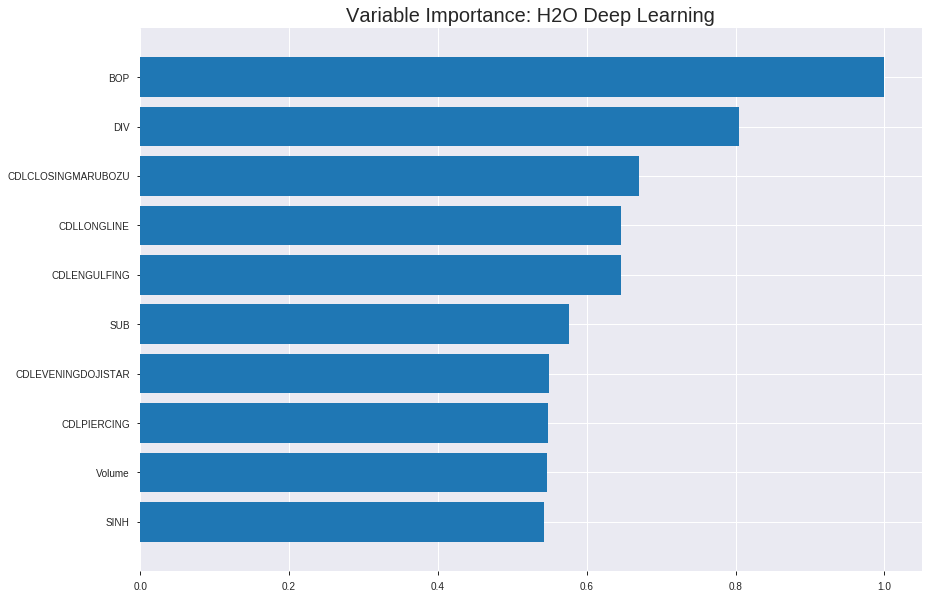

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_121039_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2199727127506101
RMSE: 0.4690124867747234
LogLoss: 0.6287211877317209
Mean Per-Class Error: 0.3326027733561411
AUC: 0.72161837183457
pr_auc: 0.6981545472203827
Gini: 0.44323674366914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44009549858254: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      309  550   0.6403   (550.0/859.0)
1      85   797   0.0964   (85.0/882.0)
Total  394  1347  0.3647   (635.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440095     0.715119  225
max f2                       0.233722     0.847244  338
max f0point5                 0.508297     0.671896  164
max accuracy                 0.508297     0.667433  164
max precision                0.743849     1         0
max recall                   0.165723     1         371
max specificity              0.743849     1         0
max absolute_mcc             0.508297     0.334781  164
max min_per_class_accuracy   0.508297     0.664726  164
max mean_per_class_accuracy  0.508297     0.667397  164

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 48.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.691448           1.64494   1.64494            0.833333         0.707231  0.833333                    0.707231            0.0170068       0.0170068                  64.4936   64.4936
    2        0.0201034                   0.678403           1.50947   1.57914            0.764706         0.685246  0.8                         0.696552            0.0147392       0.031746                   50.947    57.9138
    3        0.0304423                   0.669997           1.42561   1.527              0.722222         0.674406  0.773585                    0.689031            0.0147392       0.0464853                  42.5611   52.6997
    4        0.0402068                   0.663722           1.50947   1.52274            0.764706         0.667022  0.771429                    0.683686            0.0147392       0.0612245                  50.947    52.2741
    5        0.0505457                   0.650884           1.7546    1.57017            0.888889         0.658921  0.795455                    0.678621            0.0181406       0.0793651                  75.4598   57.0166
    6        0.100517                    0.589344           1.65628   1.61298            0.83908          0.610683  0.817143                    0.644846            0.0827664       0.162132                   65.628    61.2977
    7        0.150488                    0.568342           1.33864   1.52188            0.678161         0.57882   0.770992                    0.622921            0.0668934       0.229025                   33.8637   52.1879
    8        0.20046                     0.557377           1.29326   1.46489            0.655172         0.561769  0.74212                     0.607677            0.0646259       0.293651                   29.326    46.4888
    9        0.300402                    0.538629           1.3046    1.41156            0.66092          0.548143  0.715105                    0.58787             0.130385        0.424036                   30.4604   41.1562
    10       0.400345                    0.520519           1.17982   1.35371            0.597701         0.529345  0.685796                    0.57326             0.117914        0.54195                    17.9816   35.3709
    11       0.500287                    0.508467           1.21385   1.32577            0.614943         0.513533  0.671642                    0.561328            0.121315        0.663265                   21.3849   32.5769
    12       0.60023                     0.498112           0.952928  1.26369            0.482759         0.503517  0.640191                    0.551702            0.0952381       0.758503                   -4.70717  26.3688
    13       0.700172                    0.487322           0.907551  1.21285            0.45977          0.493188  0.614438                    0.54335             0.0907029       0.849206                   -9.24492  21.2853
    14       0.800115                    0.401351           0.657974  1.14354            0.333333         0.459289  0.579325                    0.53285             0.0657596       0.914966                   -34.2026  14.3543
    15       0.900057                    0.272274           0.601252  1.08333            0.304598         0.342338  0.548819                    0.511695            0.0600907       0.975057                   -39.8748  8.33272
    16       1                           0.0508332          0.249576  1                  0.126437         0.196882  0.506605                    0.480232         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.35127926904284595
RMSE: 0.5926881718432097
LogLoss: 7.380659813770074
Mean Per-Class Error: 0.4149018595041323
AUC: 0.5677944214876033
pr_auc: 0.58330904164998
Gini: 0.13558884297520657
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.077387932974251e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    242  1        (242.0/242.0)
1      0    256  0        (0.0/256.0)
Total  0    498  0.4859   (242.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.07739e-50  0.679045  327
max f2                       6.07739e-50  0.840999  327
max f0point5                 0.478947     0.584906  200
max accuracy                 0.488804     0.580321  192
max precision                0.601344     0.75      15
max recall                   6.07739e-50  1         327
max specificity              0.717537     0.995868  0
max absolute_mcc             0.511693     0.193679  129
max min_per_class_accuracy   0.284796     0.546875  246
max mean_per_class_accuracy  0.511693     0.585098  129

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 26.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.67756            1.16719   1.16719            0.6              0.691479      0.6                         0.691479            0.0117188       0.0117188                  16.7188   16.7188
    2        0.0200803                   0.616794           1.16719   1.16719            0.6              0.650702      0.6                         0.67109             0.0117188       0.0234375                  16.7188   16.7188
    3        0.0301205                   0.601412           1.94531   1.42656            1                0.608282      0.733333                    0.650154            0.0195312       0.0429688                  94.5313   42.6562
    4        0.0401606                   0.595296           1.55625   1.45898            0.8              0.599746      0.75                        0.637552            0.015625        0.0585938                  55.625    45.8984
    5        0.0502008                   0.588724           0.778125  1.32281            0.4              0.591946      0.68                        0.628431            0.0078125       0.0664062                  -22.1875  32.2813
    6        0.100402                    0.56507            1.08938   1.20609            0.56             0.57704       0.62                        0.602735            0.0546875       0.121094                   8.9375    20.6094
    7        0.150602                    0.54318            1.40063   1.27094            0.72             0.554627      0.653333                    0.586699            0.0703125       0.191406                   40.0625   27.0938
    8        0.200803                    0.525626           1.40063   1.30336            0.72             0.534461      0.67                        0.57364             0.0703125       0.261719                   40.0625   30.3359
    9        0.301205                    0.505138           1.12828   1.245              0.58             0.513361      0.64                        0.553547            0.113281        0.375                      12.8281   24.5
    10       0.399598                    0.480238           1.03221   1.1926             0.530612         0.496609      0.613065                    0.539527            0.101562        0.476562                   3.22066   19.2604
    11       0.5                         0.271918           0.700313  1.09375            0.36             0.391105      0.562249                    0.509723            0.0703125       0.546875                   -29.9688  9.375
    12       0.600402                    5.04876e-13        0.739219  1.03446            0.38             0.0698886     0.531773                    0.436172            0.0742188       0.621094                   -26.0781  3.44638
    13       0.698795                    4.81992e-98        1.03221   1.03415            0.530612         1.11185e-14   0.531609                    0.374757            0.101562        0.722656                   3.22066   3.4146
    14       1                           0                  0.920781  1                  0.473333         1.97453e-100  0.514056                    0.261879            0.277344        1                          -7.92187  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:17:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:17:46  2 min 42.895 sec  501 obs/sec       0.709362  1             1235       0.529024         0.792887            -0.119659      0.698045        0.671924           1.42561          0.378518                         0.642759           8.46878               -0.653864        0.556931          0.577255             1.16719            0.485944
    2019-08-25 12:18:00  2 min 56.700 sec  826 obs/sec       7.09535   10            12353      0.469012         0.628721            0.119956       0.721618        0.698155           1.64494          0.364733                         0.592688           7.38066               -0.406228        0.567794          0.583309             1.16719            0.485944
    2019-08-25 12:18:13  3 min 10.148 sec  956 obs/sec       14.8139   21            25791      0.461047         0.613296            0.149594       0.7243          0.703478           1.53527          0.352671                         0.609189           8.39463               -0.48562         0.503164          0.3051               0.963393           0.435743
    2019-08-25 12:18:28  3 min 25.157 sec  1028 obs/sec      24.0138   34            41808      0.46157          0.61353             0.147666       0.725812        0.706366           1.53527          0.349225                         0.605438           8.65805               -0.467382        0.558013          0.579104             1.16719            0.485944
    2019-08-25 12:18:41  3 min 38.208 sec  1103 obs/sec      33.2332   47            57859      0.461018         0.612479            0.149701       0.72651         0.705141           1.31595          0.350373                         0.607149           8.78373               -0.475686        0.558319          0.576834             0.778125           0.485944
    2019-08-25 12:18:54  3 min 51.612 sec  1161 obs/sec      43.0804   61            75003      0.458793         0.607228            0.157888       0.727679        0.704771           1.42561          0.34865                          0.604867           8.64067               -0.464616        0.556342          0.572307             0.778125           0.485944
    2019-08-25 12:18:56  3 min 52.943 sec  1161 obs/sec      43.0804   61            75003      0.469012         0.628721            0.119956       0.721618        0.698155           1.64494          0.364733                         0.592688           7.38066               -0.406228        0.567794          0.583309             1.16719            0.485944

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.037446728337236355
DIV                 0.8052113056182861     0.8052113056182861   0.030152529015559357
CDLCLOSINGMARUBOZU  0.6699490547180176     0.6699490547180176   0.0250874002518139
CDLLONGLINE         0.6461637616157532     0.6461637616157532   0.02419671884259186
CDLENGULFING        0.6458055377006531     0.6458055377006531   0.024183304528959206
---                 ---                    ---                  ---
CDLDARKCLOUDCOVER   0.4744951128959656     0.4744951128959656   0.017768289589961517
CDLHOMINGPIGEON     0.4726831614971161     0.4726831614971161   0.017700437938168525
HT_TRENDMODE        0.47231459617614746    0.47231459617614746  0.017686636372719687
CDLINVERTEDHAMMER   0.4653921127319336     0.4653921127319336   0.017427412015765194
CDLMATCHINGLOW      0.4557674527168274     0.4557674527168274   0.01706699998684125


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6546184738955824)

('F1', 0.6644951140065146)

('auc', 0.6803118908382066)

('logloss', 0.6510837243297486)

('mean_per_class_error', 0.34717348927875247)

('rmse', 0.4795077733724815)

('mse', 0.22992770472463508)

deeplearning prediction progress: |███████████████████████████████████████| 100%


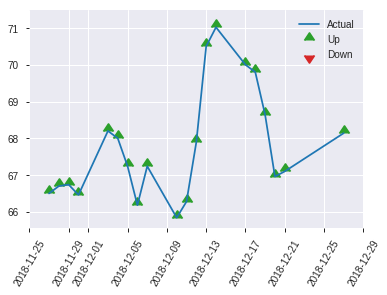


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22992770472463508
RMSE: 0.4795077733724815
LogLoss: 0.6510837243297486
Mean Per-Class Error: 0.34717348927875247
AUC: 0.6803118908382066
pr_auc: 0.6139899373300528
Gini: 0.3606237816764133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4581693968015584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      44   91   0.6741   (91.0/135.0)
1      12   102  0.1053   (12.0/114.0)
Total  56   193  0.4137   (103.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458169     0.664495  192
max f2                       0.214129     0.815451  242
max f0point5                 0.509337     0.622837  115
max accuracy                 0.512439     0.654618  111
max precision                0.682783     1         0
max recall                   0.214129     1         242
max specificity              0.682783     1         0
max absolute_mcc             0.509337     0.305276  115
max min_per_class_accuracy   0.507371     0.637037  121
max mean_per_class_accuracy  0.509337     0.652827  115

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 49.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.668305           2.18421   2.18421            1                0.676214  1                           0.676214            0.0263158       0.0263158                  118.421   118.421
    2        0.0200803                   0.666543           2.18421   2.18421            1                0.667924  1                           0.672898            0.0175439       0.0438596                  118.421   118.421
    3        0.0321285                   0.665448           0.72807   1.63816            0.333333         0.666006  0.75                        0.670313            0.00877193      0.0526316                  -27.193   63.8158
    4        0.0401606                   0.648902           1.09211   1.52895            0.5              0.662297  0.7                         0.66871             0.00877193      0.0614035                  9.21053   52.8947
    5        0.0522088                   0.640197           2.18421   1.68016            1                0.643578  0.769231                    0.66291             0.0263158       0.0877193                  118.421   68.0162
    6        0.100402                    0.594771           1.27412   1.48526            0.583333         0.614533  0.68                        0.639689            0.0614035       0.149123                   27.4123   48.5263
    7        0.15261                     0.566536           1.0081    1.32202            0.461538         0.577957  0.605263                    0.61857             0.0526316       0.201754                   0.809717  32.2022
    8        0.200803                    0.554568           1.82018   1.44158            0.833333         0.560785  0.66                        0.604702            0.0877193       0.289474                   82.0175   44.1579
    9        0.301205                    0.534021           1.31053   1.39789            0.6              0.544562  0.64                        0.584655            0.131579        0.421053                   31.0526   39.7895
    10       0.401606                    0.517553           1.13579   1.33237            0.52             0.525095  0.61                        0.569765            0.114035        0.535088                   13.5789   33.2368
    11       0.502008                    0.506643           1.22316   1.31053            0.56             0.511692  0.6                         0.55815             0.122807        0.657895                   22.3158   31.0526
    12       0.598394                    0.49794            1.0011    1.26069            0.458333         0.502399  0.577181                    0.54917             0.0964912       0.754386                   0.109649  26.0685
    13       0.698795                    0.48645            0.698947  1.17998            0.32             0.492478  0.54023                     0.541025            0.0701754       0.824561                   -30.1053  17.9976
    14       0.799197                    0.448375           0.786316  1.13052            0.36             0.472077  0.517588                    0.532363            0.0789474       0.903509                   -21.3684  13.0521
    15       0.899598                    0.322413           0.436842  1.0531             0.2              0.396732  0.482143                    0.517226            0.0438596       0.947368                   -56.3158  5.31015
    16       1                           0.125552           0.524211  1                  0.24             0.252527  0.457831                    0.490649         

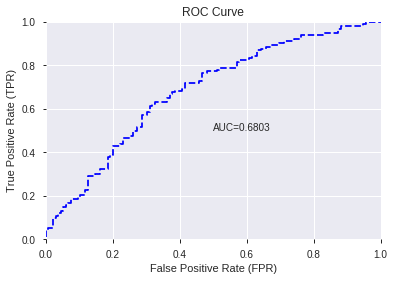

This function is available for GLM models only


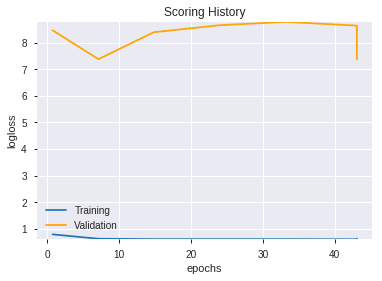

--2019-08-25 12:19:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_121039_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_121039_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLENGULFING',
 'SUB',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'Volume',
 'SINH',
 'EXP',
 'CDL3BLACKCROWS',
 'CDLSTICKSANDWICH',
 'CDLGAPSIDESIDEWHITE',
 'CDLUPSIDEGAP2CROWS',
 'CDL3WHITESOLDIERS',
 'CDLONNECK',
 'CDLEVENINGSTAR',
 'CDLUNIQUE3RIVER',
 'CDLMORNINGSTAR',
 'COSH',
 'CDLINNECK',
 'CDLABANDONEDBABY',
 'is_quarter_end',
 'CDLIDENTICAL3CROWS',
 'TANH',
 'CDLMORNINGDOJISTAR',
 'CDL2CROWS',
 'CDLLADDERBOTTOM',
 'ATAN',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLHIKKAKEMOD',
 'is_month_end',
 'CDLTAKURI',
 'is_quarter_start',
 'CDLHANGINGMAN',
 'CDL3LINESTRIKE',
 'SIN',
 'CDLTHRUSTING',
 'is_month_start',
 'CDLADVANCEBLOCK',
 'CDL3INSIDE',
 'CDLSEPARATINGLINES',
 'CDLDARKCLOUDCOVER',
 'CDLHOMINGPIGEON',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_121919_model_1  0.656205  0.708933              0.391033  0.503906  0.253921

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.009657           1.000000    0.132581
1           CDLLONGLINE             0.007022           0.727201    0.096413
2    CDLCLOSINGMARUBOZU             0.006814           0.705632    0.093554
3                   DIV             0.005768           0.597334    0.079195
4          CDLENGULFING             0.004938           0.511319    0.067791
5                   SUB             0.003516           0.364082    0.048270
6                Volume             0.002703           0.279946    0.037116
7        CDLEVENINGSTAR             0.002210           0.228877    0.030345
8     CDLDARKCLOUDCOVER             0.001939           0.200779    0.026619
9    CDLEVENINGDOJISTAR             0.001463           0.151516    0.020088
10      CDLSHOOTINGSTAR             0.001356           0.140379    0.018612
11       CDL3BLACKCROWS             0.001296           0.134181    0.017790
12          CDLPIERCING             0.001261           0.130589    0.017314
13        CDLHANGINGMAN             0.001172           0.121382    0.016093
14      CDLADVANCEBLOCK             0.001035           0.107157    0.014207
15            CDL2CROWS             0.001032           0.106921    0.014176
16      CDLLADDERBOTTOM             0.000967           0.100129    0.013275
17           CDL3INSIDE             0.000963           0.099755    0.013226
18     is_quarter_start             0.000941           0.097401    0.012914
19       is_month_start             0.000917           0.094934    0.012586
20         is_month_end             0.000864           0.089472    0.011862
21       CDLMORNINGSTAR             0.000850           0.087972    0.011663
22            CDLTAKURI             0.000806           0.083512    0.011072
23            CDLHAMMER             0.000763           0.078965    0.010469
24   CDLUPSIDEGAP2CROWS             0.000752           0.077908    0.010329
25            CDLONNECK             0.000752           0.077896    0.010328
26        CDLHIKKAKEMOD             0.000746           0.077297    0.010248
27   CDLIDENTICAL3CROWS             0.000738           0.076452    0.010136
28     CDLABANDONEDBABY             0.000730           0.075628    0.010027
29       is_quarter_end             0.000701           0.072633    0.009630
30                 TANH             0.000694           0.071914    0.009534
31   CDLSEPARATINGLINES             0.000646           0.066868    0.008865
32  CDLGAPSIDESIDEWHITE             0.000628           0.064985    0.008616
33         CDLTHRUSTING             0.000561           0.058091    0.007702
34                  SIN             0.000496           0.051317    0.006804
35                 COSH             0.000493           0.051071    0.006771
36                  EXP             0.000486           0.050277    0.006666
37                 SINH             0.000479           0.049557    0.006570
38    CDL3WHITESOLDIERS             0.000458           0.047398    0.006284
39            CDLINNECK             0.000453           0.046906    0.006219
40    CDLGRAVESTONEDOJI             0.000435           0.045056    0.005974
41     CDLSTICKSANDWICH             0.000424           0.043948    0.005827
42       CDL3LINESTRIKE             0.000401           0.041515    0.005504
43   CDLMORNINGDOJISTAR             0.000375           0.038788    0.005143
44      CDLUNIQUE3RIVER             0.000297           0.030794    0.004083
45                 ATAN             0.000257           0.026640    0.003532
46    CDLINVERTEDHAMMER             0.000193           0.020028    0.002655
47       CDLMATCHINGLOW             0.000187           0.019374    0.002569
48         HT_TRENDMODE             0.000148           0.015322    0.002031
49      CDLHOMINGPIGEON             0.000053           0.005448    0.000722

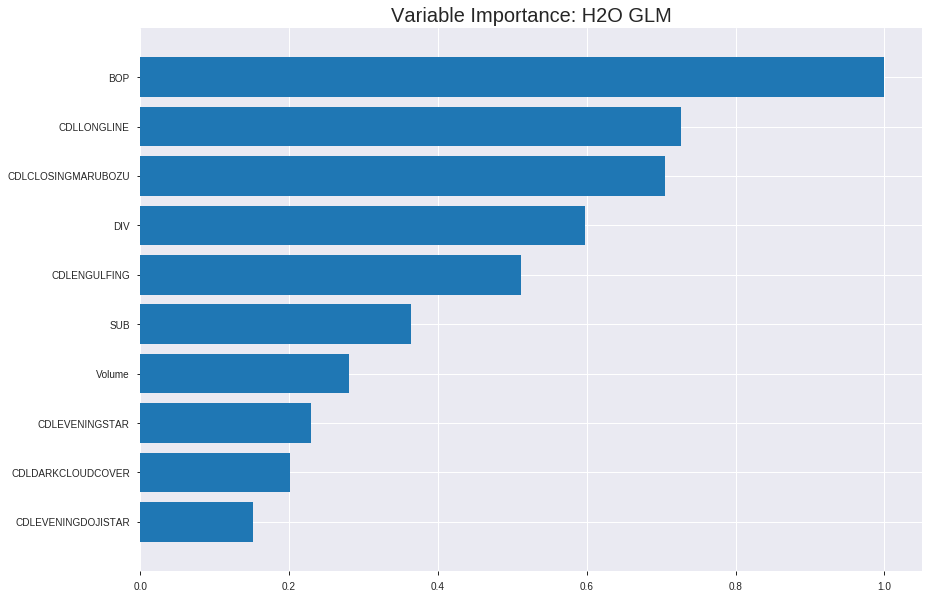

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_121919_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.247546339064974
RMSE: 0.4975402888862107
LogLoss: 0.6882385017083832
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2413.2346255079065
Residual deviance: 2396.44646294859
AIC: 2498.44646294859
AUC: 0.7147470163851337
pr_auc: 0.6889147210697
Gini: 0.42949403277026743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5036637710580602: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      321  538   0.6263   (538.0/859.0)
1      94   788   0.1066   (94.0/882.0)
Total  415  1326  0.363    (632.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503664     0.713768  248
max f2                       0.492416     0.842934  361
max f0point5                 0.507402     0.672515  185
max accuracy                 0.507402     0.668581  185
max precision                0.529213     1         0
max recall                   0.489534     1         380
max specificity              0.529213     1         0
max absolute_mcc             0.505603     0.338396  219
max min_per_class_accuracy   0.507494     0.666667  183
max mean_per_class_accuracy  0.507402     0.668455  185

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.520739           1.31595   1.31595            0.666667         0.522866  0.666667                    0.522866            0.0136054       0.0136054                  31.5949   31.5949
    2        0.0201034                   0.520215           1.7417    1.52274            0.882353         0.520496  0.771429                    0.521715            0.0170068       0.0306122                  74.1697   52.2741
    3        0.0304423                   0.519343           1.20629   1.41527            0.611111         0.519874  0.716981                    0.52109             0.0124717       0.0430839                  20.6286   41.5265
    4        0.0402068                   0.51854            1.85781   1.52274            0.941176         0.518905  0.771429                    0.520559            0.0181406       0.0612245                  85.781    52.2741
    5        0.0505457                   0.517452           1.64494   1.54774            0.833333         0.517891  0.784091                    0.520013            0.0170068       0.0782313                  64.4936   54.7735
    6        0.100517                    0.513448           1.63359   1.59042            0.827586         0.51515   0.805714                    0.517596            0.0816327       0.159864                   63.3591   59.0418
    7        0.150488                    0.512092           1.42939   1.53695            0.724138         0.512687  0.778626                    0.515966            0.0714286       0.231293                   42.9392   53.6948
    8        0.20046                     0.511329           1.17982   1.44792            0.597701         0.511694  0.733524                    0.514901            0.0589569       0.290249                   17.9816   44.7921
    9        0.300402                    0.509733           1.32729   1.40779            0.672414         0.510504  0.713193                    0.513438            0.132653        0.422902                   32.7293   40.7788
    10       0.400345                    0.508656           1.2025    1.35654            0.609195         0.509177  0.687231                    0.512374            0.120181        0.543084                   20.2505   35.6541
    11       0.500287                    0.507493           1.2025    1.32577            0.609195         0.508054  0.671642                    0.511511            0.120181        0.663265                   20.2505   32.5769
    12       0.60023                     0.506337           0.93024   1.25991            0.471264         0.506932  0.638278                    0.510749            0.0929705       0.756236                   -6.97605  25.9911
    13       0.700172                    0.504974           0.896206  1.208              0.454023         0.505732  0.611977                    0.510033            0.0895692       0.845805                   -10.3794  20.7995
    14       0.800115                    0.502067           0.657974  1.13929            0.333333         0.503767  0.577172                    0.50925             0.0657596       0.911565                   -34.2026  13.9292
    15       0.900057                    0.496415           0.578564  1.07703            0.293103         0.499206  0.545629                    0.508135            0.0578231       0.969388                   -42.1436  7.70288
    16       1                           0.475936           0.306298  1                  0.155172         0.492833  0.506605                    0.506605         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.37644619364566567
RMSE: 0.6135521115974304
LogLoss: 7.978039257624659
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 690.0915890932606
Residual deviance: 149456.23194943828
AIC: 149558.23194943828
AUC: 0.5142206869834711
pr_auc: 0.3104541214375054
Gini: 0.02844137396694224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5049834704004763: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      39   203  0.8388   (203.0/242.0)
1      13   243  0.0508   (13.0/256.0)
Total  52   446  0.4337   (216.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504983     0.692308  236
max f2                       0.497987     0.842771  267
max f0point5                 0.504983     0.595588  236
max accuracy                 0.504983     0.566265  236
max precision                0.509169     0.550409  157
max recall                   0.485013     1         286
max specificity              1            0.561983  0
max absolute_mcc             0.504983     0.180398  236
max min_per_class_accuracy   0.618172     0.471074  39
max mean_per_class_accuracy  0.508072     0.556399  179

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 74.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.411647                    1                  0.948933  0.948933           0.487805         1         0.487805                    1                   0.390625        0.390625                   -5.10671  -5.10671
    2        0.5                         0.613377           0.928445  0.945313           0.477273         0.94051   0.485944                    0.989488            0.0820312       0.472656                   -7.15554  -5.46875
    3        0.600402                    0.513525           1.28391   1.00193            0.66             0.526672  0.51505                     0.912094            0.128906        0.601562                   28.3906   0.193353
    4        0.698795                    0.510098           1.31011   1.04533            0.673469         0.511641  0.537356                    0.855708            0.128906        0.730469                   31.0108   4.5326
    5        0.799197                    0.507784           1.16719   1.06064            0.6              0.508898  0.545226                    0.812139            0.117188        0.847656                   16.7188   6.06352
    6        0.899598                    0.504891           1.01156   1.05516            0.52             0.506618  0.542411                    0.778041            0.101562        0.949219                   1.15625   5.51583
    7        1                           0.484568           0.505781  1                  0.26             0.498155  0.514056                    0.74994             0.0507812       1                          -49.4219  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:19:20  0.000 sec   2            16        51            1.37648           300.113
    2019-08-25 12:19:20  0.012 sec   4            9.8       51            1.3711            300.47
    2019-08-25 12:19:20  0.024 sec   6            6.1       51            1.36316           303.663
    2019-08-25 12:19:20  0.035 sec   8            3.8       51            1.35191           320.361
    2019-08-25 12:19:20  0.051 sec   10           2.4       51            1.337             331.409

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6506024096385542)

('F1', 0.6600660066006602)

('auc', 0.6562053281351528)

('logloss', 0.7089325618443629)

('mean_per_class_error', 0.34883040935672516)

('rmse', 0.5039059055664059)

('mse', 0.2539211616646996)

glm prediction progress: |████████████████████████████████████████████████| 100%


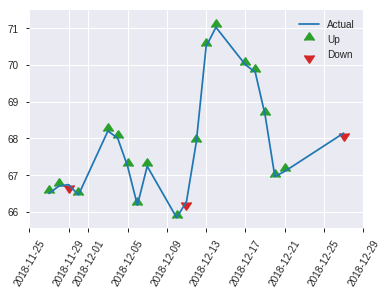


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2539211616646996
RMSE: 0.5039059055664059
LogLoss: 0.7089325618443629
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 345.78564229926025
Residual deviance: 353.0484157984927
AIC: 455.0484157984927
AUC: 0.6562053281351528
pr_auc: 0.5525560070281623
Gini: 0.3124106562703055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5044599425886203: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      46   89   0.6593   (89.0/135.0)
1      14   100  0.1228   (14.0/114.0)
Total  60   189  0.4137   (103.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50446      0.660066  188
max f2                       0.491757     0.811966  245
max f0point5                 0.508685     0.618812  122
max accuracy                 0.508685     0.650602  122
max precision                0.514664     0.634146  40
max recall                   0.491757     1         245
max specificity              0.965713     0.992593  0
max absolute_mcc             0.508685     0.301284  122
max min_per_class_accuracy   0.508727     0.644444  121
max mean_per_class_accuracy  0.508685     0.65117   122

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.76919            0.72807   0.72807            0.333333         0.918301  0.333333                    0.918301            0.00877193      0.00877193                 -27.193   -27.193
    2        0.0200803                   0.589425           1.09211   0.873684           0.5              0.665825  0.4                         0.81731             0.00877193      0.0175439                  9.21053   -12.6316
    3        0.0321285                   0.569781           0.72807   0.819079           0.333333         0.581053  0.375                       0.728714            0.00877193      0.0263158                  -27.193   -18.0921
    4        0.0401606                   0.541064           1.09211   0.873684           0.5              0.561321  0.4                         0.695235            0.00877193      0.0350877                  9.21053   -12.6316
    5        0.0522088                   0.533758           0.72807   0.840081           0.333333         0.53631   0.384615                    0.65856             0.00877193      0.0438596                  -27.193   -15.9919
    6        0.100402                    0.518994           1.63816   1.22316            0.75             0.523841  0.56                        0.593895            0.0789474       0.122807                   63.8158   22.3158
    7        0.15261                     0.515007           1.51215   1.32202            0.692308         0.517343  0.605263                    0.567706            0.0789474       0.201754                   51.2146   32.2022
    8        0.200803                    0.512607           1.09211   1.26684            0.5              0.513713  0.58                        0.554748            0.0526316       0.254386                   9.21053   26.6842
    9        0.301205                    0.510748           1.39789   1.31053            0.64             0.511552  0.6                         0.540349            0.140351        0.394737                   39.7895   31.0526
    10       0.401606                    0.509536           1.39789   1.33237            0.64             0.510207  0.61                        0.532814            0.140351        0.535088                   39.7895   33.2368
    11       0.502008                    0.508504           1.22316   1.31053            0.56             0.509019  0.6                         0.528055            0.122807        0.657895                   22.3158   31.0526
    12       0.598394                    0.506777           0.637061  1.20205            0.291667         0.50763   0.550336                    0.524765            0.0614035       0.719298                   -36.2939  20.2049
    13       0.698795                    0.50565            0.961053  1.16742            0.44             0.506167  0.534483                    0.522093            0.0964912       0.815789                   -3.89474  16.7423
    14       0.799197                    0.503022           0.698947  1.10857            0.32             0.504551  0.507538                    0.519889            0.0701754       0.885965                   -30.1053  10.8569
    15       0.899598                    0.498321           0.611579  1.0531             0.28             0.500805  0.482143                    0.517759            0.0614035       0.947368                   -38.8421  5.31015
    16       1                           0.483366           0.524211  1                  0.24             0.494298  0.457831                    0.515404     

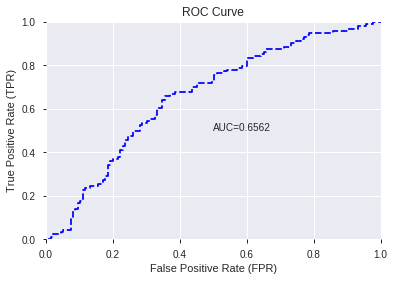

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


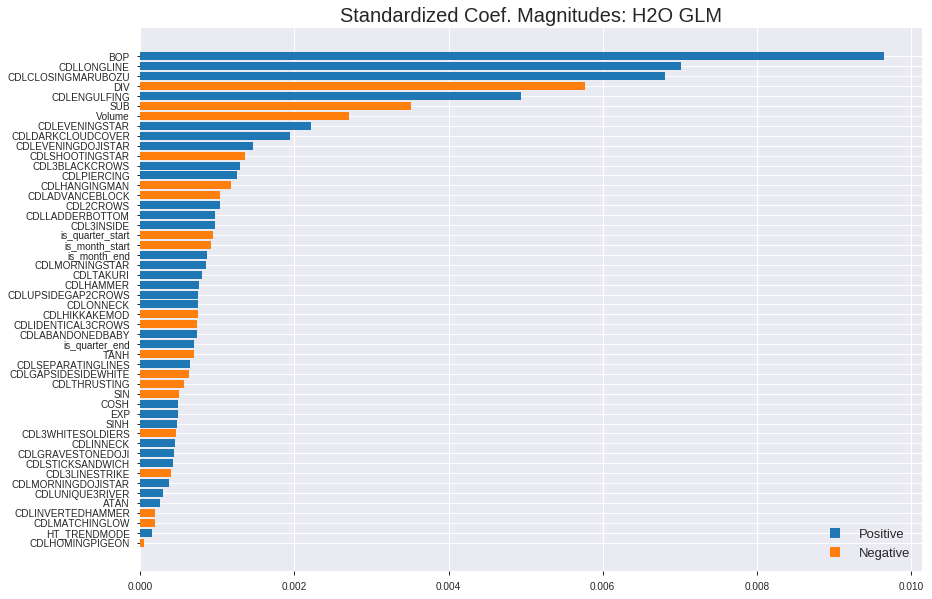

'log_likelihood'
--2019-08-25 12:19:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_121919_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_121919_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'CDLENGULFING',
 'SUB',
 'Volume',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDL3BLACKCROWS',
 'CDLPIERCING',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'CDL2CROWS',
 'CDLLADDERBOTTOM',
 'CDL3INSIDE',
 'is_quarter_start',
 'is_month_start',
 'is_month_end',
 'CDLMORNINGSTAR',
 'CDLTAKURI',
 'CDLHAMMER',
 'CDLUPSIDEGAP2CROWS',
 'CDLONNECK',
 'CDLHIKKAKEMOD',
 'CDLIDENTICAL3CROWS',
 'CDLABANDONEDBABY',
 'is_quarter_end',
 'TANH',
 'CDLSEPARATINGLINES',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'SIN',
 'COSH',
 'EXP',
 'SINH',
 'CDL3WHITESOLDIERS',
 'CDLINNECK',
 'CDLGRAVESTONEDOJI',
 'CDLSTICKSANDWICH',
 'CDL3LINESTRIKE',
 'CDLMORNINGDOJISTAR',
 'CDLUNIQUE3RIVER',
 'ATAN',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW',
 'HT_TRENDMODE',
 'CDLHOMINGPIGEON']

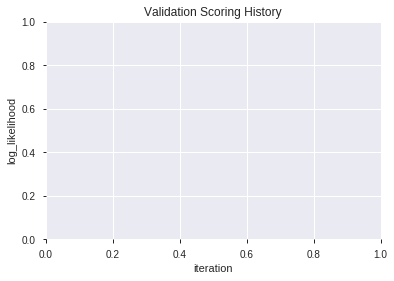

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_121943_model_4  0.668876  0.652154              0.378850  0.480138  0.230532
1               XGBoost_3_AutoML_20190825_121943  0.668421  0.650812              0.366764  0.479639  0.230054
2  XGBoost_grid_1_AutoML_20190825_121943_model_3  0.662768  0.647661              0.372807  0.478405  0.228871
3               XGBoost_2_AutoML_20190825_121943  0.657440  0.653869              0.374854  0.481023  0.231384
4  XGBoost_grid_1_AutoML_20190825_121943_model_2  0.657245  0.654463              0.401072  0.481024  0.231384
5  XGBoost_grid_1_AutoML_20190825_121943_model_7  0.654321  0.656396              0.376803  0.482605  0.232908
6  XGBoost_grid_1_AutoML_20190825_121943_model_6  0.649643  0.659680              0.377193  0.484389  0.234633
7               XGBoost_1_AutoML_20190825_121943  0.647238  0.661329              0.377875  0.484896  0.235124
8  XGBoost_grid_1_AutoML_20190825_121943_model_1  0.642982  0.662448              0.390643  0.485446  0.235658
9  XGBoost_grid_1_AutoML_20190825_121943_model_5  0.613190  0.705817              0.394055  0.501888  0.251891

variable  relative_importance  scaled_importance  percentage
0                 BOP          1559.799438           1.000000    0.467260
1                 DIV           893.491333           0.572824    0.267658
2              Volume           258.674255           0.165838    0.077490
3                 SIN           206.941086           0.132672    0.061992
4                 SUB           202.242584           0.129659    0.060585
5                ATAN           183.131180           0.117407    0.054860
6                TANH            15.778321           0.010116    0.004727
7         CDLLONGLINE            12.555369           0.008049    0.003761
8        HT_TRENDMODE             2.893334           0.001855    0.000867
9  CDLCLOSINGMARUBOZU             2.677421           0.001717    0.000802

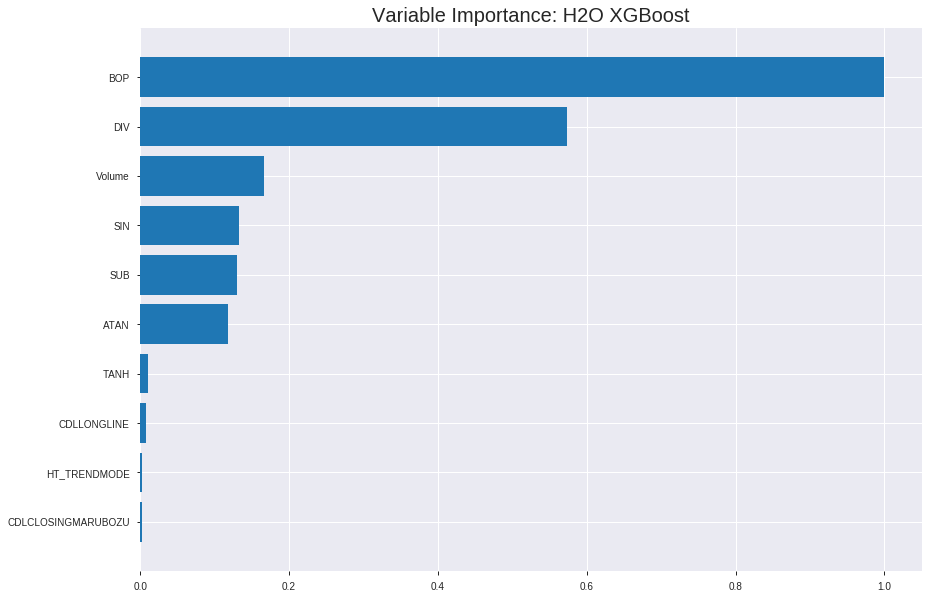

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_121943_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20232876473038547
RMSE: 0.44980969835074197
LogLoss: 0.5909576047615921
Mean Per-Class Error: 0.30668274294583964
AUC: 0.7551667155026542
pr_auc: 0.7380506113741491
Gini: 0.5103334310053085
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3710797131061554: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      356  503   0.5856   (503.0/859.0)
1      75   807   0.085    (75.0/882.0)
Total  431  1310  0.332    (578.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37108      0.736314  271
max f2                       0.195494     0.848655  367
max f0point5                 0.543286     0.698074  165
max accuracy                 0.543286     0.69328   165
max precision                0.781565     1         0
max recall                   0.144138     1         392
max specificity              0.781565     1         0
max absolute_mcc             0.543286     0.386601  165
max min_per_class_accuracy   0.541505     0.691502  166
max mean_per_class_accuracy  0.543286     0.693317  165

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.761455           1.64494   1.64494            0.833333         0.768011  0.833333                    0.768011            0.0170068       0.0170068                  64.4936   64.4936
    2        0.0201034                   0.752266           1.85781   1.74833            0.941176         0.756684  0.885714                    0.762509            0.0181406       0.0351474                  85.781    74.8332
    3        0.0304423                   0.744766           1.64494   1.71322            0.833333         0.748755  0.867925                    0.757838            0.0170068       0.0521542                  64.4936   71.3216
    4        0.0402068                   0.739244           1.97392   1.77653            1                0.741813  0.9                         0.753946            0.0192744       0.0714286                  97.3923   77.6531
    5        0.0505457                   0.734376           1.64494   1.74961            0.833333         0.736399  0.886364                    0.750357            0.0170068       0.0884354                  64.4936   74.9613
    6        0.100517                    0.712291           1.72435   1.73705            0.873563         0.722825  0.88                        0.73667             0.0861678       0.174603                   72.4346   73.7052
    7        0.150488                    0.691899           1.36133   1.61229            0.689655         0.702093  0.816794                    0.725188            0.0680272       0.24263                    36.1326   61.2288
    8        0.20046                     0.664194           1.24788   1.52145            0.632184         0.678937  0.770774                    0.713658            0.0623583       0.304989                   24.7882   52.1448
    9        0.300402                    0.621103           1.38401   1.47572            0.701149         0.642269  0.74761                     0.689908            0.138322        0.443311                   38.4015   47.5724
    10       0.400345                    0.586835           1.22519   1.41318            0.62069          0.604466  0.715925                    0.668578            0.122449        0.56576                    22.5194   41.3182
    11       0.500287                    0.54182            1.25923   1.38243            0.637931         0.564544  0.700344                    0.647795            0.12585         0.69161                    25.9227   38.2426
    12       0.60023                     0.486896           0.93024   1.30713            0.471264         0.516579  0.662201                    0.625947            0.0929705       0.78458                    -6.97605  30.7134
    13       0.700172                    0.409556           0.850829  1.242              0.431034         0.450709  0.629204                    0.600933            0.085034        0.869615                   -14.9171  24.2001
    14       0.800115                    0.327116           0.714696  1.17613            0.362069         0.370186  0.595836                    0.57211             0.0714286       0.941043                   -28.5304  17.6135
    15       0.900057                    0.223766           0.374365  1.08711            0.189655         0.273319  0.550734                    0.538933            0.037415        0.978458                   -62.5635  8.71062
    16       1                           0.122997           0.215543  1                  0.109195         0.181926  0.506605                    0.503252         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22210717861733445
RMSE: 0.471282482824616
LogLoss: 0.6350574429863189
Mean Per-Class Error: 0.33180526859504134
AUC: 0.7111876936983471
pr_auc: 0.6916112267393976
Gini: 0.4223753873966942
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4983489513397217: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      98   144  0.595    (144.0/242.0)
1      27   229  0.1055   (27.0/256.0)
Total  125  373  0.3434   (171.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498349     0.72814   289
max f2                       0.240376     0.846614  385
max f0point5                 0.570978     0.673077  219
max accuracy                 0.541663     0.672691  254
max precision                0.765604     1         0
max recall                   0.218169     1         392
max specificity              0.765604     1         0
max absolute_mcc             0.541663     0.356121  254
max min_per_class_accuracy   0.594245     0.65625   188
max mean_per_class_accuracy  0.541663     0.668195  254

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 56.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.739122           1.55625   1.55625            0.8              0.752563  0.8                         0.752563            0.015625        0.015625                   55.625    55.625
    2        0.0200803                   0.731516           1.94531   1.75078            1                0.733968  0.9                         0.743266            0.0195312       0.0351562                  94.5313   75.0781
    3        0.0301205                   0.727959           1.55625   1.68594            0.8              0.73034   0.866667                    0.738957            0.015625        0.0507812                  55.625    68.5938
    4        0.0401606                   0.725649           1.94531   1.75078            1                0.726973  0.9                         0.735961            0.0195312       0.0703125                  94.5313   75.0781
    5        0.0502008                   0.72243            1.16719   1.63406            0.6              0.723806  0.84                        0.73353             0.0117188       0.0820312                  16.7188   63.4063
    6        0.100402                    0.710886           1.47844   1.55625            0.76             0.716202  0.8                         0.724866            0.0742188       0.15625                    47.8438   55.625
    7        0.150602                    0.699552           1.16719   1.42656            0.6              0.704993  0.733333                    0.718242            0.0585938       0.214844                   16.7188   42.6562
    8        0.200803                    0.683492           1.245     1.38117            0.64             0.691788  0.71                        0.711628            0.0625          0.277344                   24.5      38.1172
    9        0.301205                    0.641019           1.32281   1.36172            0.68             0.659035  0.7                         0.694097            0.132812        0.410156                   32.2813   36.1719
    10       0.399598                    0.619844           1.38951   1.36856            0.714286         0.629706  0.703518                    0.678242            0.136719        0.546875                   38.9509   36.8562
    11       0.5                         0.59453            1.01156   1.29688            0.52             0.607556  0.666667                    0.664048            0.101562        0.648438                   1.15625   29.6875
    12       0.600402                    0.566824           1.05047   1.25567            0.54             0.580064  0.645485                    0.650004            0.105469        0.753906                   5.04688   25.567
    13       0.698795                    0.522352           1.03221   1.22421            0.530612         0.545243  0.62931                     0.635253            0.101562        0.855469                   3.22066   22.4205
    14       0.799197                    0.460434           0.583594  1.14373            0.3              0.493038  0.58794                     0.617387            0.0585938       0.914062                   -41.6406  14.3726
    15       0.899598                    0.354358           0.389063  1.0595             0.2              0.409436  0.544643                    0.594178            0.0390625       0.953125                   -61.0937  5.95006
    16       1                           0.130131           0.466875  1                  0.24             0.269153  0.514056                    0.561545            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:19:49  2.260 sec   0                  0.5              0.693147            0.5             0                  1                0.493395                         0.5                0.693147              0.5               0                    1                  0.485944
    2019-08-25 12:19:49  2.314 sec   5                  0.48434          0.662174            0.730532        0.698762           1.71645          0.336588                         0.490107           0.673501              0.703585          0.683364             1.62109            0.355422
    2019-08-25 12:19:49  2.351 sec   10                 0.47564          0.645025            0.73702         0.721071           1.86426          0.338311                         0.483932           0.661281              0.706482          0.674663             1.37316            0.335341
    2019-08-25 12:19:49  2.397 sec   15                 0.468008         0.629748            0.739456        0.718043           1.7546           0.338311                         0.48038            0.654122              0.705336          0.687462             1.55625            0.331325
    2019-08-25 12:19:49  2.439 sec   20                 0.463139         0.619707            0.739922        0.719318           1.7546           0.336588                         0.478469           0.650114              0.706168          0.685425             1.62109            0.335341
    2019-08-25 12:19:49  2.486 sec   25                 0.459649         0.612368            0.74165         0.719              1.64494          0.338886                         0.475701           0.644466              0.705966          0.684081             1.55625            0.339357
    2019-08-25 12:19:49  2.539 sec   30                 0.457587         0.607923            0.743655        0.72254            1.66225          0.336588                         0.473969           0.640881              0.706426          0.684215             1.29688            0.34739
    2019-08-25 12:19:49  2.588 sec   35                 0.455632         0.603675            0.746397        0.729516           1.86426          0.329696                         0.473616           0.639948              0.706765          0.687001             1.55625            0.345382
    2019-08-25 12:19:49  2.635 sec   40                 0.453968         0.600007            0.748833        0.733135           1.64494          0.334865                         0.472611           0.637832              0.710009          0.686238             1.55625            0.337349
    2019-08-25 12:19:49  2.686 sec   45                 0.452526         0.596764            0.750181        0.733019           1.53527          0.334291                         0.472099           0.636772              0.710663          0.690226             1.55625            0.335341
    2019-08-25 12:19:49  2.737 sec   50                 0.450856         0.593226            0.753923        0.737052           1.53527          0.323952                         0.471284           0.635178              0.709614          0.68813              1.55625            0.345382
    2019-08-25 12:19:49  2.801 sec   55                 0.44981          0.590958            0.755167        0.738051           1.64494          0.331993                         0.471282           0.635057              0.711188          0.

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 1559.8                 1                    0.46726
DIV                 893.491                0.572824             0.267658
Volume              258.674                0.165838             0.0774895
SIN                 206.941                0.132672             0.0619921
SUB                 202.243                0.129659             0.0605846
ATAN                183.131                0.117407             0.0548595
TANH                15.7783                0.0101156            0.00472662
CDLLONGLINE         12.5554                0.00804935           0.00376114
HT_TRENDMODE        2.89333                0.00185494           0.000866739
CDLCLOSINGMARUBOZU  2.67742                0.00171652           0.000802059

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.642570281124498)

('F1', 0.6793650793650793)

('auc', 0.6688758934372969)

('logloss', 0.6521541749575992)

('mean_per_class_error', 0.35350877192982455)

('rmse', 0.4801376416009718)

('mse', 0.23053215488214324)

xgboost prediction progress: |████████████████████████████████████████████| 100%


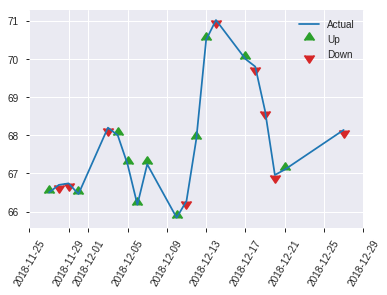


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23053215488214324
RMSE: 0.4801376416009718
LogLoss: 0.6521541749575992
Mean Per-Class Error: 0.35350877192982455
AUC: 0.6688758934372969
pr_auc: 0.5921753222300846
Gini: 0.33775178687459384
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3480125367641449: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      41   94   0.6963   (94.0/135.0)
1      7    107  0.0614   (7.0/114.0)
Total  48   201  0.4056   (101.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348013     0.679365  197
max f2                       0.300785     0.823442  214
max f0point5                 0.543361     0.611455  130
max accuracy                 0.543361     0.64257   130
max precision                0.765921     1         0
max recall                   0.179303     1         240
max specificity              0.765921     1         0
max absolute_mcc             0.348013     0.306023  197
max min_per_class_accuracy   0.564951     0.622807  118
max mean_per_class_accuracy  0.543361     0.646491  130

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.742132           2.18421   2.18421            1                0.754152  1                           0.754152            0.0263158       0.0263158                  118.421   118.421
    2        0.0200803                   0.734517           1.09211   1.74737            0.5              0.738266  0.8                         0.747797            0.00877193      0.0350877                  9.21053   74.7368
    3        0.0321285                   0.73012            0.72807   1.36513            0.333333         0.732258  0.625                       0.74197             0.00877193      0.0438596                  -27.193   36.5132
    4        0.0401606                   0.72821            1.09211   1.31053            0.5              0.730048  0.6                         0.739586            0.00877193      0.0526316                  9.21053   31.0526
    5        0.0522088                   0.727099           1.45614   1.34413            0.666667         0.727506  0.615385                    0.736798            0.0175439       0.0701754                  45.614    34.413
    6        0.100402                    0.714321           1.82018   1.57263            0.833333         0.721117  0.72                        0.729271            0.0877193       0.157895                   82.0175   57.2632
    7        0.15261                     0.699887           1.17611   1.43698            0.538462         0.707407  0.657895                    0.721791            0.0614035       0.219298                   17.6113   43.6981
    8        0.200803                    0.672392           1.27412   1.39789            0.583333         0.689349  0.64                        0.714005            0.0614035       0.280702                   27.4123   39.7895
    9        0.301205                    0.624865           1.04842   1.2814             0.48             0.645016  0.586667                    0.691009            0.105263        0.385965                   4.84211   28.1404
    10       0.401606                    0.590614           1.39789   1.31053            0.64             0.605806  0.6                         0.669708            0.140351        0.526316                   39.7895   31.0526
    11       0.502008                    0.556972           1.13579   1.27558            0.52             0.575998  0.584                       0.650966            0.114035        0.640351                   13.5789   27.5579
    12       0.598394                    0.505885           0.910088  1.21671            0.416667         0.532904  0.557047                    0.631949            0.0877193       0.72807                    -8.99123  21.6708
    13       0.698795                    0.430837           0.786316  1.15487            0.36             0.469147  0.528736                    0.608558            0.0789474       0.807018                   -21.3684  15.487
    14       0.799197                    0.350808           1.13579   1.15247            0.52             0.392757  0.527638                    0.581448            0.114035        0.921053                   13.5789   15.2473
    15       0.899598                    0.285561           0.524211  1.08235            0.24             0.319833  0.495536                    0.55225             0.0526316       0.973684                   -47.5789  8.23543
    16       1                           0.141753           0.262105  1                  0.12             0.228198  0.457831                    0.519714           

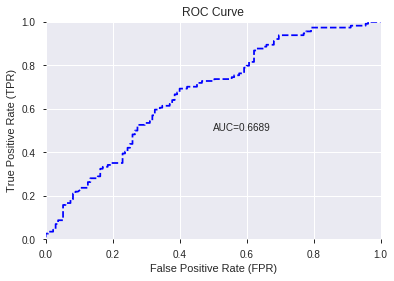

This function is available for GLM models only


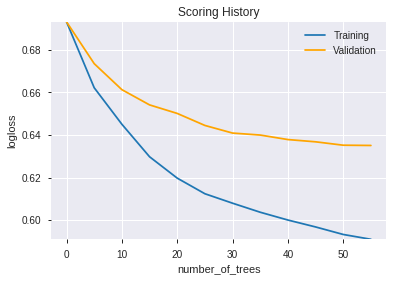

--2019-08-25 12:20:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.96
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.96|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_121943_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_121943_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'Volume',
 'SIN',
 'SUB',
 'ATAN',
 'TANH',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [901 938] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


53

['BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MFI_12',
 'MINUS_DI_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MFI_14',
 'MINUS_DI_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_122018_model_2  0.673099  0.664350              0.384893  0.481021  0.231382
1  DeepLearning_grid_1_AutoML_20190825_122018_model_6  0.666277  0.657261              0.386940  0.480050  0.230448
2               DeepLearning_1_AutoML_20190825_122018  0.666147  0.658790              0.392008  0.480273  0.230662
3  DeepLearning_grid_1_AutoML_20190825_122018_model_1  0.656270  0.790881              0.424269  0.511510  0.261642
4  DeepLearning_grid_1_AutoML_20190825_122018_model_5  0.655686  0.668755              0.406140  0.482974  0.233264
5  DeepLearning_grid_1_AutoML_20190825_122018_model_9  0.655621  0.655841              0.382261  0.481162  0.231517
6  DeepLearning_grid_1_AutoML_20190825_122018_model_8  0.652242  0.677869              0.398733  0.485929  0.236127
7  DeepLearning_grid_1_AutoML_20190825_122018_model_3  0.648083  0.713494              0.399708  0.496981  0.246990
8  DeepLearning_grid_1_AutoML_20190825_122018_model_7  0.647823  0.703366              0.414522  0.500803  0.250803
9  DeepLearning_grid_1_AutoML_20190825_122018_model_4  0.645744  0.705445              0.393372  0.496192  0.246207

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.032111
1                  DIV             0.887961           0.887961    0.028514
2                  SUB             0.810708           0.810708    0.026033
3         STOCHF_fastk             0.712082           0.712082    0.022866
4       STOCHRSI_fastk             0.684853           0.684853    0.021991
5   CDLCLOSINGMARUBOZU             0.677318           0.677318    0.021749
6               MFI_12             0.677135           0.677135    0.021744
7               ULTOSC             0.657000           0.657000    0.021097
8               CMO_30             0.602948           0.602948    0.019361
9               MFI_14             0.595830           0.595830    0.019133
10           ROCR100_8             0.594795           0.594795    0.019100
11              CCI_20             0.594575           0.594575    0.019093
12               CCI_8             0.591664           0.591664    0.018999
13            WILLR_30             0.588076           0.588076    0.018884
14            WILLR_20             0.587886           0.587886    0.018878
15              RSI_20             0.578203           0.578203    0.018567
16            WILLR_12             0.577360           0.577360    0.018540
17              CCI_12             0.575492           0.575492    0.018480
18              RSI_30             0.575412           0.575412    0.018477
19         CDLBELTHOLD             0.574864           0.574864    0.018460
20            WILLR_24             0.572629           0.572629    0.018388
21            WILLR_14             0.572126           0.572126    0.018372
22        CDLENGULFING             0.570983           0.570983    0.018335
23             ROCP_14             0.570238           0.570238    0.018311
24          MINUS_DI_8             0.567893           0.567893    0.018236
25              CCI_14             0.565428           0.565428    0.018157
26             ROCR_14             0.563793           0.563793    0.018104
27              CMO_14             0.563408           0.563408    0.018092
28             ROCR_12             0.563399           0.563399    0.018091
29              ROC_14             0.556919           0.556919    0.017883
30         MINUS_DI_12             0.553632           0.553632    0.017778
31               ROC_8             0.552722           0.552722    0.017749
32             WILLR_8             0.552352           0.552352    0.017737
33              CMO_20             0.552098           0.552098    0.017729
34               MOM_8             0.552083           0.552083    0.017728
35              CCI_30             0.549803           0.549803    0.017655
36              RSI_24             0.546313           0.546313    0.017543
37             ROCP_12             0.544389           0.544389    0.017481
38          ROCR100_14             0.544380           0.544380    0.017481
39              ROCP_8             0.544259           0.544259    0.017477
40               RSI_8             0.542307           0.542307    0.017414
41         CDLLONGLINE             0.540403           0.540403    0.017353
42              ROCR_8             0.539000           0.539000    0.017308
43              ROC_12             0.538809           0.538809    0.017302
44         CDLMARUBOZU             0.535017           0.535017    0.017180
45              CCI_24             0.528368           0.528368    0.016967
46              RSI_14             0.528073           0.528073    0.016957
47              CMO_12             0.526381           0.526381    0.016903
48               CMO_8             0.523144           0.523144    0.016799
49          ROCR100_12             0.518261           0.518261    0.016642
50              CMO_24             0.517867           0.517867    0.016629
51              RSI_12             0.500944           0.500944    0.016086
52         MINUS_DI_14             0.50

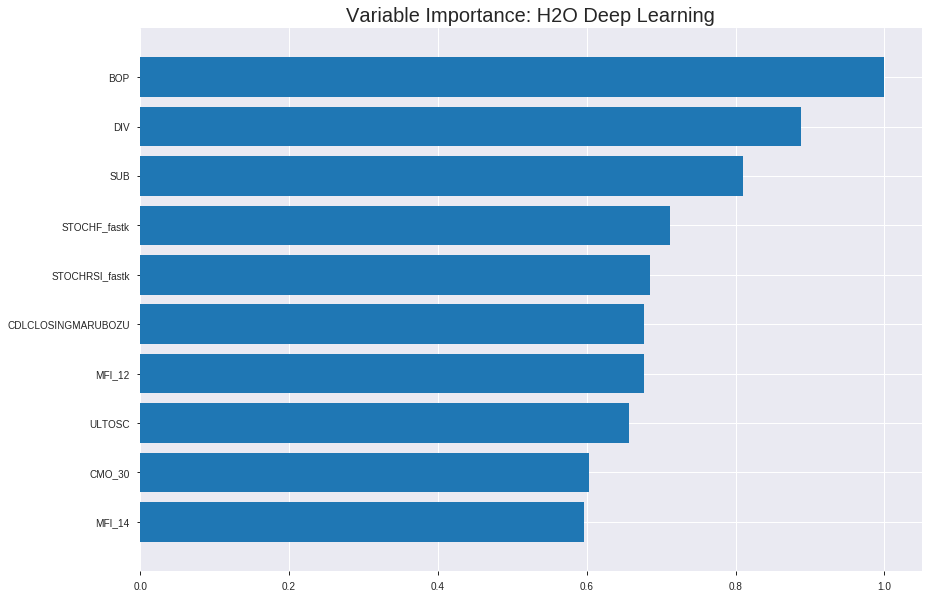

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_122018_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2601302364293518
RMSE: 0.5100296426967278
LogLoss: 0.7325107002880417
Mean Per-Class Error: 0.3978648114270932
AUC: 0.630493058690298
pr_auc: 0.6002849328531048
Gini: 0.26098611738059607
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11567647299015134: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      173  686   0.7986   (686.0/859.0)
1      42   840   0.0476   (42.0/882.0)
Total  215  1526  0.4182   (728.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.115676     0.697674  351
max f2                       0.0276161    0.840015  389
max f0point5                 0.229711     0.614539  301
max accuracy                 0.229711     0.605399  301
max precision                0.951714     1         0
max recall                   0.0105896    1         396
max specificity              0.951714     1         0
max absolute_mcc             0.181504     0.245692  322
max min_per_class_accuracy   0.408705     0.583236  213
max mean_per_class_accuracy  0.229711     0.602135  301

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 41.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.894383           1.31595   1.31595            0.666667         0.917451   0.666667                    0.917451            0.0136054       0.0136054                  31.5949   31.5949
    2        0.0201034                   0.876121           1.27724   1.29715            0.647059         0.885712   0.657143                    0.902035            0.0124717       0.0260771                  27.7244   29.7149
    3        0.0304423                   0.858653           1.53527   1.37802            0.777778         0.868942   0.698113                    0.890796            0.015873        0.0419501                  53.5273   37.8022
    4        0.0402068                   0.833544           1.04502   1.29715            0.529412         0.846791   0.657143                    0.880109            0.0102041       0.0521542                  4.5018    29.7149
    5        0.0505457                   0.821423           1.09662   1.25613            0.555556         0.828402   0.636364                    0.869533            0.0113379       0.0634921                  9.66238   25.6133
    6        0.100517                    0.740133           1.27057   1.26331            0.643678         0.773803   0.64                        0.821941            0.0634921       0.126984                   27.0571   26.3311
    7        0.150488                    0.692728           1.2025    1.24312            0.609195         0.716651   0.629771                    0.786978            0.0600907       0.187075                   20.2505   24.3119
    8        0.20046                     0.642701           1.17982   1.22734            0.597701         0.667745   0.621777                    0.757255            0.0589569       0.246032                   17.9816   22.7339
    9        0.300402                    0.553781           1.21385   1.22285            0.614943         0.597327   0.619503                    0.704048            0.121315        0.367347                   21.3849   22.2851
    10       0.400345                    0.481581           1.02099   1.17246            0.517241         0.515724   0.593974                    0.657034            0.102041        0.469388                   2.09946   17.2459
    11       0.500287                    0.408685           1.12309   1.1626             0.568966         0.443721   0.588978                    0.614421            0.112245        0.581633                   12.3094   16.2598
    12       0.60023                     0.344133           1.12309   1.15602            0.568966         0.378315   0.585646                    0.575107            0.112245        0.693878                   12.3094   15.602
    13       0.700172                    0.265155           1.03234   1.13837            0.522989         0.304608   0.576702                    0.536496            0.103175        0.797052                   3.2339    13.8366
    14       0.800115                    0.186957           0.975617  1.11804            0.494253         0.227242   0.566403                    0.497867            0.0975057       0.894558                   -2.43829  11.8037
    15       0.900057                    0.0972371          0.680663  1.06947            0.344828         0.14077    0.5418                      0.458215            0.0680272       0.962585                   -31.9337  6.94707
    16       1                           0.00155157         0.374365  1                  0.189655         0.0526607  0.506605                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2537546859123699
RMSE: 0.5037406931272973
LogLoss: 0.7126107208076679
Mean Per-Class Error: 0.38949509297520657
AUC: 0.6281475981404959
pr_auc: 0.580572970099945
Gini: 0.25629519628099184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13388788319649597: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      39   203  0.8388   (203.0/242.0)
1      5    251  0.0195   (5.0/256.0)
Total  44   454  0.4177   (208.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.133888     0.707042  360
max f2                       0.123207     0.850202  363
max f0point5                 0.28875      0.626411  295
max accuracy                 0.28875      0.616466  295
max precision                0.960158     1         0
max recall                   0.0588814    1         384
max specificity              0.960158     1         0
max absolute_mcc             0.287618     0.257235  296
max min_per_class_accuracy   0.458258     0.597656  204
max mean_per_class_accuracy  0.407217     0.610505  231

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 45.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.910856           0.778125  0.778125           0.4              0.93841   0.4                         0.93841             0.0078125       0.0078125                  -22.1875  -22.1875
    2        0.0200803                   0.903135           1.16719   0.972656           0.6              0.906028  0.5                         0.922219            0.0117188       0.0195312                  16.7188   -2.73437
    3        0.0301205                   0.883582           0.778125  0.907813           0.4              0.894015  0.466667                    0.912818            0.0078125       0.0273438                  -22.1875  -9.21875
    4        0.0401606                   0.854097           1.16719   0.972656           0.6              0.869295  0.5                         0.901937            0.0117188       0.0390625                  16.7188   -2.73437
    5        0.0502008                   0.825523           1.16719   1.01156            0.6              0.842918  0.52                        0.890133            0.0117188       0.0507812                  16.7188   1.15625
    6        0.100402                    0.744172           1.08938   1.05047            0.56             0.783905  0.54                        0.837019            0.0546875       0.105469                   8.9375    5.04688
    7        0.150602                    0.686842           1.245     1.11531            0.64             0.717121  0.573333                    0.797053            0.0625          0.167969                   24.5      11.5313
    8        0.200803                    0.653434           1.32281   1.16719            0.68             0.66812   0.6                         0.76482             0.0664062       0.234375                   32.2813   16.7188
    9        0.301205                    0.580754           1.16719   1.16719            0.6              0.616982  0.6                         0.715541            0.117188        0.351562                   16.7188   16.7188
    10       0.399598                    0.514485           1.27041   1.1926             0.653061         0.546636  0.613065                    0.673951            0.125           0.476562                   27.0408   19.2604
    11       0.5                         0.458258           1.16719   1.1875             0.6              0.487315  0.610442                    0.636474            0.117188        0.59375                    16.7188   18.75
    12       0.600402                    0.394777           1.08938   1.17109            0.56             0.426251  0.602007                    0.601319            0.109375        0.703125                   8.9375    17.1091
    13       0.698795                    0.32208            0.873406  1.12918            0.44898          0.361306  0.58046                     0.567524            0.0859375       0.789062                   -12.6594  12.9176
    14       0.799197                    0.254996           0.972656  1.10951            0.5              0.292707  0.570352                    0.533               0.0976562       0.886719                   -2.73437  10.9512
    15       0.899598                    0.156508           0.778125  1.07253            0.4              0.204266  0.551339                    0.496311            0.078125        0.964844                   -22.1875  7.25272
    16       1                           0.0018673          0.350156  1                  0.18             0.078966  0.514056                    0.454409       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:21:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:21:10  50.655 sec        5506 obs/sec      10        1             17410      0.51003          0.732511            -0.0407026     0.630493        0.600285           1.31595          0.41815                          0.503741           0.712611              -0.0158216       0.628148          0.580573             0.778125           0.417671
    2019-08-25 12:21:16  56.535 sec        7782 obs/sec      40        4             69640      0.509164         0.785842            -0.0371733     0.626851        0.57472            1.31595          0.39575                          0.524341           0.848726              -0.100605        0.572346          0.538426             1.16719            0.403614
    2019-08-25 12:21:22  1 min  2.238 sec  9566 obs/sec      80        8             139280     0.481548         0.703424            0.0722843      0.691384        0.635976           1.20629          0.381964                         0.530716           0.863744              -0.127527        0.571442          0.540165             1.16719            0.423695
    2019-08-25 12:21:28  1 min  8.357 sec  10992 obs/sec     130       13            226330     0.45969          0.657221            0.154594       0.738568        0.682318           1.31595          0.345778                         0.540939           0.907973              -0.171385        0.570999          0.54663              1.16719            0.435743
    2019-08-25 12:21:33  1 min 13.489 sec  11552 obs/sec     170       17            295970     0.431549         0.572962            0.254932       0.793327        0.750007           1.53527          0.284894                         0.516261           0.777808              -0.0669466       0.61634           0.591159             1.16719            0.429719
    2019-08-25 12:21:39  1 min 19.281 sec  12233 obs/sec     220       22            383020     0.416675         0.528028            0.305406       0.825362        0.801372           1.7546           0.263067                         0.532938           0.856115              -0.136989        0.600376          0.576564             1.55625            0.415663
    2019-08-25 12:21:39  1 min 19.378 sec  12231 obs/sec     220       22            383020     0.51003          0.732511            -0.0407026     0.630493        0.600285           1.31595          0.41815                          0.503741           0.712611              -0.0158216       0.628148          0.580573             0.778125           0.417671

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
BOP             1.0                    1.0                  0.03211119154191883
DIV             0.8879614472389221     0.8879614472389221   0.028513500114128485
SUB             0.8107080459594727     0.8107080459594727   0.026032801348379365
STOCHF_fastk    0.7120816111564636     0.7120816111564636   0.022865789009323373
STOCHRSI_fastk  0.6848532557487488     0.6848532557487488   0.0219914540734548
---             ---                    ---                  ---
CMO_8           0.523144006729126      0.523144006729126    0.016798777404085842
ROCR100_12      0.5182605385780334     0.5182605385780334   0.016641963422897248
CMO_24          0.517867386341095      0.517867386341095    0.016629338836111784
RSI_12          0.5009441375732422     0.5009441375732422   0.01608591315341572
MINUS_DI_14     0.5002071857452393     0.5002071857452393   0.01606224875210955


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6305220883534136)

('F1', 0.6791277258566978)

('auc', 0.6730994152046783)

('logloss', 0.6643499023190473)

('mean_per_class_error', 0.37007797270955156)

('rmse', 0.4810213783284733)

('mse', 0.23138156640902427)

deeplearning prediction progress: |███████████████████████████████████████| 100%


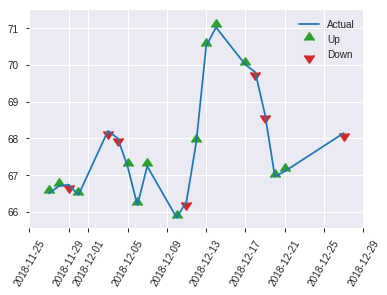


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23138156640902427
RMSE: 0.4810213783284733
LogLoss: 0.6643499023190473
Mean Per-Class Error: 0.37007797270955156
AUC: 0.6730994152046783
pr_auc: 0.6146602416642866
Gini: 0.3461988304093566
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17443493596469803: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   98   0.7259   (98.0/135.0)
1      5    109  0.0439   (5.0/114.0)
Total  42   207  0.4137   (103.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.174435     0.679128  206
max f2                       0.155507     0.823353  211
max f0point5                 0.424086     0.597643  119
max accuracy                 0.518374     0.630522  73
max precision                0.765887     1         0
max recall                   0.02243      1         245
max specificity              0.765887     1         0
max absolute_mcc             0.174435     0.306296  206
max min_per_class_accuracy   0.424086     0.622807  119
max mean_per_class_accuracy  0.424086     0.629922  119

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 40.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.764487           1.45614   1.45614            0.666667         0.7655     0.666667                    0.7655              0.0175439       0.0175439                  45.614    45.614
    2        0.0200803                   0.749941           2.18421   1.74737            1                0.76374    0.8                         0.764796            0.0175439       0.0350877                  118.421   74.7368
    3        0.0321285                   0.740689           1.45614   1.63816            0.666667         0.744651   0.75                        0.757242            0.0175439       0.0526316                  45.614    63.8158
    4        0.0401606                   0.737795           1.09211   1.52895            0.5              0.738693   0.7                         0.753532            0.00877193      0.0614035                  9.21053   52.8947
    5        0.0522088                   0.733567           2.18421   1.68016            1                0.735496   0.769231                    0.74937             0.0263158       0.0877193                  118.421   68.0162
    6        0.100402                    0.685216           1.82018   1.74737            0.833333         0.711001   0.8                         0.730953            0.0877193       0.175439                   82.0175   74.7368
    7        0.15261                     0.643875           1.0081    1.49446            0.461538         0.663592   0.684211                    0.707908            0.0526316       0.22807                    0.809717  49.446
    8        0.200803                    0.595488           1.27412   1.44158            0.583333         0.629231   0.66                        0.689025            0.0614035       0.289474                   27.4123   44.1579
    9        0.301205                    0.517219           1.31053   1.39789            0.6              0.547846   0.64                        0.641966            0.131579        0.421053                   31.0526   39.7895
    10       0.401606                    0.464197           1.04842   1.31053            0.48             0.491756   0.6                         0.604413            0.105263        0.526316                   4.84211   31.0526
    11       0.502008                    0.414427           0.961053  1.24063            0.44             0.439702   0.568                       0.571471            0.0964912       0.622807                   -3.89474  24.0632
    12       0.598394                    0.360894           0.910088  1.18739            0.416667         0.386057   0.543624                    0.541606            0.0877193       0.710526                   -8.99123  18.739
    13       0.698795                    0.283324           1.13579   1.17998            0.52             0.325272   0.54023                     0.510523            0.114035        0.824561                   13.5789   17.9976
    14       0.799197                    0.198658           0.961053  1.15247            0.44             0.235719   0.527638                    0.476               0.0964912       0.921053                   -3.89474  15.2473
    15       0.899598                    0.107313           0.436842  1.0726             0.2              0.157354   0.491071                    0.440437            0.0438596       0.964912                   -56.3158  7.26034
    16       1                           0.00439921         0.349474  1                  0.16             0.0597937  0.457831                    0.

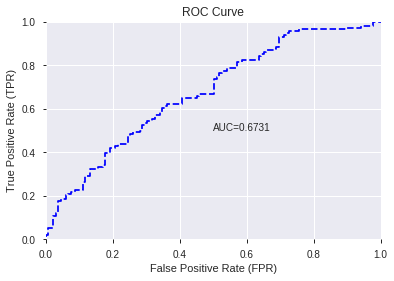

This function is available for GLM models only


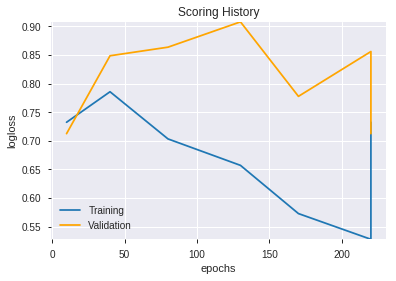

--2019-08-25 12:29:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.32.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.32.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_122018_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_122018_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'SUB',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'MFI_12',
 'ULTOSC',
 'CMO_30',
 'MFI_14',
 'ROCR100_8',
 'CCI_20',
 'CCI_8',
 'WILLR_30',
 'WILLR_20',
 'RSI_20',
 'WILLR_12',
 'CCI_12',
 'RSI_30',
 'CDLBELTHOLD',
 'WILLR_24',
 'WILLR_14',
 'CDLENGULFING',
 'ROCP_14',
 'MINUS_DI_8',
 'CCI_14',
 'ROCR_14',
 'CMO_14',
 'ROCR_12',
 'ROC_14',
 'MINUS_DI_12',
 'ROC_8',
 'WILLR_8',
 'CMO_20',
 'MOM_8',
 'CCI_30',
 'RSI_24',
 'ROCP_12',
 'ROCR100_14',
 'ROCP_8',
 'RSI_8',
 'CDLLONGLINE',
 'ROCR_8',
 'ROC_12',
 'CDLMARUBOZU',
 'CCI_24',
 'RSI_14',
 'CMO_12',
 'CMO_8',
 'ROCR100_12',
 'CMO_24',
 'RSI_12',
 'MINUS_DI_14']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id     auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190825_123000_model_1  0.6718  0.652763              0.380897  0.47974  0.230151

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.331355           1.000000    0.156664
1                  DIV             0.304809           0.919887    0.144114
2   CDLCLOSINGMARUBOZU             0.146907           0.443353    0.069458
3         CDLENGULFING             0.145032           0.437693    0.068571
4          CDLLONGLINE             0.107885           0.325588    0.051008
5                  SUB             0.107821           0.325394    0.050978
6             WILLR_30             0.088398           0.266776    0.041794
7          CDLMARUBOZU             0.087133           0.262960    0.041196
8          CDLBELTHOLD             0.065394           0.197352    0.030918
9                MOM_8             0.051770           0.156236    0.024477
10      STOCHRSI_fastk             0.050282           0.151746    0.023773
11        STOCHF_fastk             0.047295           0.142732    0.022361
12            WILLR_12             0.043780           0.132125    0.020699
13              ULTOSC             0.041049           0.123881    0.019408
14            WILLR_14             0.038294           0.115567    0.018105
15          MINUS_DI_8             0.036379           0.109788    0.017200
16             WILLR_8             0.034040           0.102729    0.016094
17              MFI_12             0.033204           0.100207    0.015699
18               CCI_8             0.024637           0.074351    0.011648
19              CCI_24             0.023046           0.069551    0.010896
20          ROCR100_14             0.020441           0.061690    0.009665
21             ROCR_14             0.020346           0.061403    0.009620
22              ROC_14             0.020289           0.061232    0.009593
23             ROCP_14             0.020194           0.060943    0.009548
24         MINUS_DI_12             0.019782           0.059701    0.009353
25         MINUS_DI_14             0.018505           0.055848    0.008749
26            WILLR_20             0.018499           0.055827    0.008746
27            WILLR_24             0.018279           0.055163    0.008642
28              MFI_14             0.017578           0.053050    0.008311
29              CCI_14             0.012507           0.037744    0.005913
30              CCI_30             0.012250           0.036970    0.005792
31              RSI_20             0.010858           0.032769    0.005134
32              CMO_20             0.010411           0.031420    0.004922
33              CMO_24             0.008087           0.024407    0.003824
34              RSI_24             0.007337           0.022142    0.003469
35              ROCP_8             0.006688           0.020185    0.003162
36               ROC_8             0.006686           0.020179    0.003161
37              ROCR_8             0.006557           0.019789    0.003100
38              RSI_14             0.006454           0.019478    0.003051
39           ROCR100_8             0.006452           0.019471    0.003050
40              CMO_14             0.006158           0.018583    0.002911
41              CCI_12             0.006111           0.018441    0.002889
42               CMO_8             0.005973           0.018025    0.002824
43               RSI_8             0.005738           0.017317    0.002713
44              RSI_12             0.002890           0.008722    0.001366
45              RSI_30             0.002438           0.007359    0.001153
46              CMO_30             0.002230           0.006729    0.001054
47              CMO_12             0.002046           0.006175    0.000967
48              ROC_12             0.001101           0.003323    0.000521
49             ROCP_12             0.001031           0.003110    0.000487
50             ROCR_12             0.000961           0.002901    0.000454
51          ROCR100_12             0.000924           0.002790    0.000437
52              CCI_20             0.00

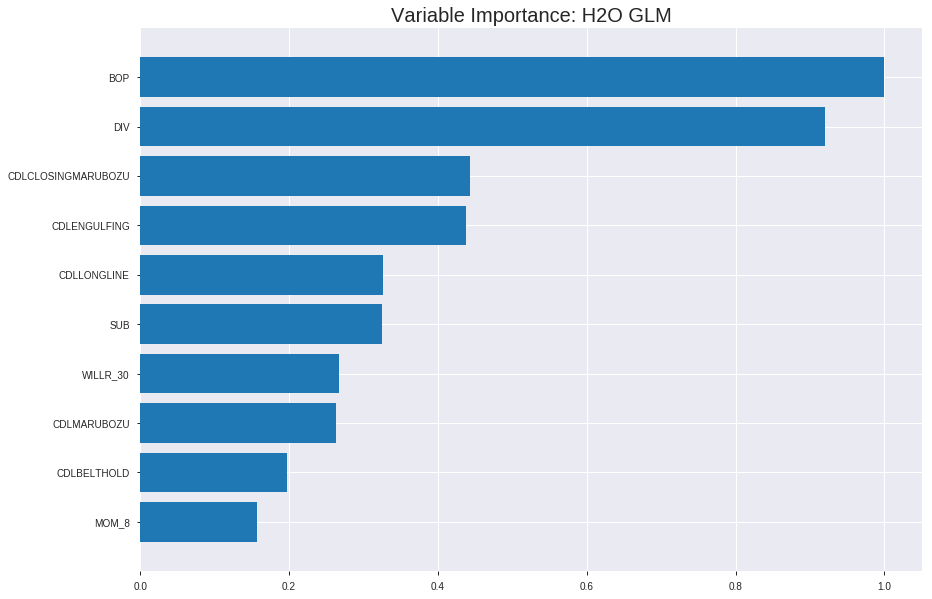

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_123000_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.21371386926835653
RMSE: 0.46229197404709127
LogLoss: 0.6157578686205046
Null degrees of freedom: 1740
Residual degrees of freedom: 1687
Null deviance: 2413.2346255079065
Residual deviance: 2144.0688985365973
AIC: 2252.0688985365973
AUC: 0.7178593206782131
pr_auc: 0.6842975457499282
Gini: 0.43571864135642624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44101326612002084: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      412  447   0.5204   (447.0/859.0)
1      138  744   0.1565   (138.0/882.0)
Total  550  1191  0.336    (585.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441013     0.7178    240
max f2                       0.199927     0.84556   360
max f0point5                 0.486088     0.669767  210
max accuracy                 0.486088     0.672028  210
max precision                0.871998     1         0
max recall                   0.151845     1         376
max specificity              0.871998     1         0
max absolute_mcc             0.479862     0.349981  214
max min_per_class_accuracy   0.533081     0.656463  180
max mean_per_class_accuracy  0.486088     0.670748  210

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.819072           1.42561   1.42561            0.722222         0.837014  0.722222                    0.837014            0.0147392       0.0147392                  42.5611   42.5611
    2        0.0201034                   0.797184           1.50947   1.46634            0.764706         0.807112  0.742857                    0.82249             0.0147392       0.0294785                  50.947    46.6343
    3        0.0304423                   0.783759           1.7546    1.56424            0.888889         0.790709  0.792453                    0.811696            0.0181406       0.047619                   75.4598   56.4241
    4        0.0402068                   0.7691             1.39336   1.52274            0.705882         0.77478   0.771429                    0.802731            0.0136054       0.0612245                  39.3357   52.2741
    5        0.0505457                   0.754175           1.53527   1.5253             0.777778         0.763328  0.772727                    0.794671            0.015873        0.0770975                  53.5273   52.5304
    6        0.100517                    0.709596           1.42939   1.47762            0.724138         0.730908  0.748571                    0.762972            0.0714286       0.148526                   42.9392   47.7622
    7        0.150488                    0.678206           1.54284   1.49928            0.781609         0.692587  0.759542                    0.7396              0.0770975       0.225624                   54.2836   49.9277
    8        0.20046                     0.6563             1.33864   1.45923            0.678161         0.667518  0.739255                    0.721631            0.0668934       0.292517                   33.8637   45.9232
    9        0.300402                    0.610725           1.27057   1.39647            0.643678         0.632167  0.707457                    0.691867            0.126984        0.419501                   27.0571   39.6466
    10       0.400345                    0.575428           1.21385   1.35088            0.614943         0.592691  0.684362                    0.667108            0.121315        0.540816                   21.3849   35.0877
    11       0.500287                    0.532555           1.14578   1.30991            0.58046          0.553299  0.663605                    0.644373            0.114512        0.655329                   14.5783   30.9905
    12       0.60023                     0.48484            1.13444   1.28069            0.574713         0.510687  0.648804                    0.622113            0.113379        0.768707                   13.4438   28.0689
    13       0.700172                    0.429206           0.839484  1.21771            0.425287         0.457703  0.616899                    0.598645            0.0839002       0.852608                   -16.0516  21.7711
    14       0.800115                    0.345091           0.635286  1.14496            0.321839         0.388352  0.580043                    0.572377            0.0634921       0.9161                     -36.4714  14.496
    15       0.900057                    0.253452           0.54453   1.07829            0.275862         0.299008  0.546267                    0.542022            0.0544218       0.970522                   -45.547   7.82885
    16       1                           0.0218863          0.294954  1                  0.149425         0.18765   0.506605                    0.506605          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2245829358899208
RMSE: 0.47390182093965494
LogLoss: 0.6418694201021733
Null degrees of freedom: 497
Residual degrees of freedom: 444
Null deviance: 690.0915890932606
Residual deviance: 639.3019424217646
AIC: 747.3019424217646
AUC: 0.6862732438016529
pr_auc: 0.6389272392053034
Gini: 0.3725464876033058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.465478999333247: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      88   154  0.6364   (154.0/242.0)
1      24   232  0.0938   (24.0/256.0)
Total  112  386  0.3574   (178.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465479     0.722741  301
max f2                       0.299065     0.849498  373
max f0point5                 0.506062     0.656627  271
max accuracy                 0.506062     0.656627  271
max precision                0.893116     1         0
max recall                   0.258683     1         385
max specificity              0.893116     1         0
max absolute_mcc             0.506062     0.330893  271
max min_per_class_accuracy   0.582476     0.628906  189
max mean_per_class_accuracy  0.506062     0.650988  271

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 56.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.849716           0.778125  0.778125           0.4              0.883411  0.4                         0.883411            0.0078125       0.0078125                  -22.1875  -22.1875
    2        0.0200803                   0.83326            1.55625   1.16719            0.8              0.843804  0.6                         0.863608            0.015625        0.0234375                  55.625    16.7188
    3        0.0301205                   0.81715            1.55625   1.29688            0.8              0.824201  0.666667                    0.850472            0.015625        0.0390625                  55.625    29.6875
    4        0.0401606                   0.807966           1.16719   1.26445            0.6              0.813553  0.65                        0.841242            0.0117188       0.0507812                  16.7188   26.4453
    5        0.0502008                   0.795983           1.55625   1.32281            0.8              0.802647  0.68                        0.833523            0.015625        0.0664062                  55.625    32.2813
    6        0.100402                    0.748816           1.32281   1.32281            0.68             0.767935  0.68                        0.800729            0.0664062       0.132812                   32.2813   32.2813
    7        0.150602                    0.719344           1.245     1.29688            0.64             0.735402  0.666667                    0.778953            0.0625          0.195312                   24.5      29.6875
    8        0.200803                    0.70005            1.47844   1.34227            0.76             0.708888  0.69                        0.761437            0.0742188       0.269531                   47.8438   34.2266
    9        0.301205                    0.663656           1.28391   1.32281            0.66             0.680563  0.68                        0.734479            0.128906        0.398438                   28.3906   32.2813
    10       0.399598                    0.617              1.11161   1.27081            0.571429         0.639293  0.653266                    0.711041            0.109375        0.507812                   11.1607   27.0807
    11       0.5                         0.582154           1.20609   1.25781            0.62             0.597429  0.646586                    0.688228            0.121094        0.628906                   20.6094   25.7813
    12       0.600402                    0.5492             1.01156   1.21663            0.52             0.566283  0.625418                    0.667836            0.101562        0.730469                   1.15625   21.6634
    13       0.698795                    0.507649           1.11161   1.20185            0.571429         0.529992  0.617816                    0.648427            0.109375        0.839844                   11.1607   20.1845
    14       0.799197                    0.439682           0.778125  1.14861            0.4              0.477784  0.590452                    0.626989            0.078125        0.917969                   -22.1875  14.8614
    15       0.899598                    0.326787           0.466875  1.07253            0.24             0.374986  0.551339                    0.598864            0.046875        0.964844                   -53.3125  7.25272
    16       1                           0.0232441          0.350156  1                  0.18             0.266413  0.514056                    0.565485        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:30:00  0.000 sec   2            16        54            1.36307           1.37062
    2019-08-25 12:30:00  0.015 sec   4            9.8       54            1.35487           1.36497
    2019-08-25 12:30:00  0.029 sec   6            6.1       54            1.34502           1.35789
    2019-08-25 12:30:00  0.043 sec   8            3.8       54            1.3334            1.34919
    2019-08-25 12:30:00  0.057 sec   10           2.4       54            1.32001           1.3389
    2019-08-25 12:30:00  0.068 sec   12           1.5       54            1.30528           1.32756
    2019-08-25 12:30:00  0.081 sec   14           0.91      54            1.29017           1.3162
    2019-08-25 12:30:00  0.095 sec   16           0.56      54            1.2758            1.30586
    2019-08-25 12:30:00  0.106 sec   18           0.35      54            1.26293           1.29722
    2019-08-25 12:30:00  0.117 sec   20           0.22      54            1.25205           1.29065
    2019-08-25 12:30:00  0.127 sec   22           0.13      54            1.24328           1.28624
    2019-08-25 12:30:00  0.137 sec   24           0.084     54            1.23651           1.284
    2019-08-25 12:30:00  0.147 sec   26           0.052     54            1.23152           1.28374
    2019-08-25 12:30:00  0.162 sec   28           0.032     54            1.22792           1.28509
    2019-08-25 12:30:00  0.178 sec   30           0.02      54            1.22531           1.28747
    2019-08-25 12:30:00  0.196 sec   32           0.012     54            1.22331           1.29027
    2019-08-25 12:30:00  0.211 sec   34           0.0077    54            1.22162           1.29311
    2019-08-25 12:30:00  0.226 sec   36           0.0048    54            1.22012           1.29573

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6546184738955824)

('F1', 0.6731391585760517)

('auc', 0.6717998700454841)

('logloss', 0.6527627628231804)

('mean_per_class_error', 0.3485380116959065)

('rmse', 0.4797402998180643)

('mse', 0.23015075526952622)

glm prediction progress: |████████████████████████████████████████████████| 100%


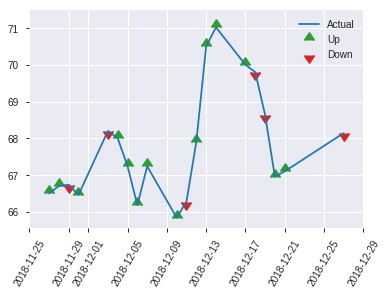


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23015075526952622
RMSE: 0.4797402998180643
LogLoss: 0.6527627628231804
Null degrees of freedom: 248
Residual degrees of freedom: 195
Null deviance: 345.78564229926025
Residual deviance: 325.07585588594384
AIC: 433.07585588594384
AUC: 0.6717998700454841
pr_auc: 0.5988189486392281
Gini: 0.3435997400909683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37372001816145994: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      44   91   0.6741   (91.0/135.0)
1      10   104  0.0877   (10.0/114.0)
Total  54   195  0.4056   (101.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37372      0.673139  194
max f2                       0.192528     0.813124  244
max f0point5                 0.554377     0.622776  111
max accuracy                 0.564527     0.654618  107
max precision                0.743615     0.772727  21
max recall                   0.192528     1         244
max specificity              0.858306     0.992593  0
max absolute_mcc             0.554377     0.303378  111
max min_per_class_accuracy   0.549114     0.622807  115
max mean_per_class_accuracy  0.554377     0.651462  111

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 51.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.817024           1.45614   1.45614            0.666667         0.843879  0.666667                    0.843879            0.0175439       0.0175439                  45.614    45.614
    2        0.0200803                   0.798634           0         0.873684           0                0.803296  0.4                         0.827645            0               0.0175439                  -100      -12.6316
    3        0.0321285                   0.793166           1.45614   1.09211            0.666667         0.796573  0.5                         0.815993            0.0175439       0.0350877                  45.614    9.21053
    4        0.0401606                   0.785972           2.18421   1.31053            1                0.791961  0.6                         0.811187            0.0175439       0.0526316                  118.421   31.0526
    5        0.0522088                   0.779695           2.18421   1.51215            1                0.783235  0.692308                    0.804737            0.0263158       0.0789474                  118.421   51.2146
    6        0.100402                    0.734766           1.63816   1.57263            0.75             0.755218  0.72                        0.780968            0.0789474       0.157895                   63.8158   57.2632
    7        0.15261                     0.696956           1.17611   1.43698            0.538462         0.712239  0.657895                    0.757455            0.0614035       0.219298                   17.6113   43.6981
    8        0.200803                    0.666168           1.63816   1.48526            0.75             0.681445  0.68                        0.739213            0.0789474       0.298246                   63.8158   48.5263
    9        0.301205                    0.605874           1.13579   1.36877            0.52             0.635024  0.626667                    0.704483            0.114035        0.412281                   13.5789   36.8772
    10       0.401606                    0.575431           1.39789   1.37605            0.64             0.591157  0.63                        0.676152            0.140351        0.552632                   39.7895   37.6053
    11       0.502008                    0.538677           0.873684  1.27558            0.4              0.554851  0.584                       0.651892            0.0877193       0.640351                   -12.6316  27.5579
    12       0.598394                    0.490834           0.819079  1.20205            0.375            0.51838   0.550336                    0.630386            0.0789474       0.719298                   -18.0921  20.2049
    13       0.698795                    0.442832           0.786316  1.14232            0.36             0.465846  0.522989                    0.606745            0.0789474       0.798246                   -21.3684  14.2317
    14       0.799197                    0.361441           1.13579   1.1415             0.52             0.408519  0.522613                    0.581843            0.114035        0.912281                   13.5789   14.1497
    15       0.899598                    0.289504           0.349474  1.0531             0.16             0.321281  0.482143                    0.552762            0.0350877       0.947368                   -65.0526  5.31015
    16       1                           0.109765           0.524211  1                  0.24             0.225664  0.457831                    0.519921         

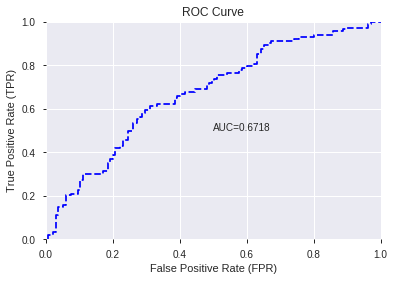

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


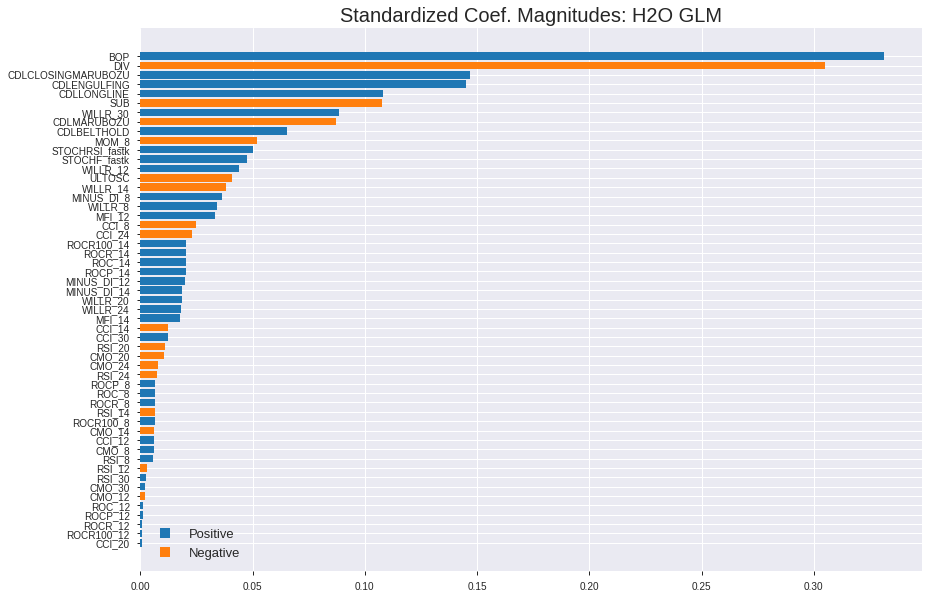

'log_likelihood'
--2019-08-25 12:30:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.28
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.28|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_123000_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_123000_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'SUB',
 'WILLR_30',
 'CDLMARUBOZU',
 'CDLBELTHOLD',
 'MOM_8',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'WILLR_12',
 'ULTOSC',
 'WILLR_14',
 'MINUS_DI_8',
 'WILLR_8',
 'MFI_12',
 'CCI_8',
 'CCI_24',
 'ROCR100_14',
 'ROCR_14',
 'ROC_14',
 'ROCP_14',
 'MINUS_DI_12',
 'MINUS_DI_14',
 'WILLR_20',
 'WILLR_24',
 'MFI_14',
 'CCI_14',
 'CCI_30',
 'RSI_20',
 'CMO_20',
 'CMO_24',
 'RSI_24',
 'ROCP_8',
 'ROC_8',
 'ROCR_8',
 'RSI_14',
 'ROCR100_8',
 'CMO_14',
 'CCI_12',
 'CMO_8',
 'RSI_8',
 'RSI_12',
 'RSI_30',
 'CMO_30',
 'CMO_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'CCI_20']

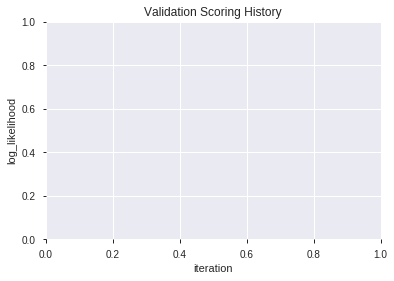

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_123019_model_4  0.656465  0.656249              0.399025  0.481999  0.232323
1               XGBoost_3_AutoML_20190825_123019  0.647758  0.659259              0.387914  0.483899  0.234158
2               XGBoost_2_AutoML_20190825_123019  0.646394  0.665207              0.433723  0.486160  0.236351
3               XGBoost_1_AutoML_20190825_123019  0.645289  0.671310              0.418226  0.488384  0.238519
4  XGBoost_grid_1_AutoML_20190825_123019_model_6  0.639701  0.668193              0.398051  0.487974  0.238119
5  XGBoost_grid_1_AutoML_20190825_123019_model_3  0.639311  0.662561              0.398051  0.485763  0.235965
6  XGBoost_grid_1_AutoML_20190825_123019_model_2  0.636322  0.665496              0.407115  0.486651  0.236830
7  XGBoost_grid_1_AutoML_20190825_123019_model_7  0.634568  0.674863              0.422612  0.490600  0.240689
8  XGBoost_grid_1_AutoML_20190825_123019_model_1  0.632489  0.669908              0.424269  0.489138  0.239256
9  XGBoost_grid_1_AutoML_20190825_123019_model_5  0.598635  0.714803              0.424951  0.507765  0.257825

variable  relative_importance  scaled_importance  percentage
0              BOP          1359.886230           1.000000    0.342478
1              DIV           842.073853           0.619224    0.212070
2              SUB           183.244537           0.134750    0.046149
3           ULTOSC           101.971130           0.074985    0.025681
4         WILLR_12           101.518776           0.074652    0.025567
5            CCI_8            98.014069           0.072075    0.024684
6           MFI_12            85.706520           0.063025    0.021585
7          WILLR_8            84.930374           0.062454    0.021389
8     STOCHF_fastk            83.587585           0.061467    0.021051
9           CMO_14            81.466576           0.059907    0.020517
10          MFI_14            78.400047           0.057652    0.019744
11           MOM_8            77.747780           0.057172    0.019580
12  STOCHRSI_fastk            74.648689           0.054893    0.018800
13          CCI_12            64.162430           0.047182    0.016159
14           ROC_8            63.885876           0.046979    0.016089
15      MINUS_DI_8            56.408825           0.041481    0.014206
16          CCI_20            53.703548           0.039491    0.013525
17        WILLR_20            52.034622           0.038264    0.013105
18        WILLR_14            49.954048           0.036734    0.012581
19          CMO_30            49.352093           0.036291    0.012429
20     MINUS_DI_14            39.691280           0.029187    0.009996
21          CMO_20            35.894234           0.026395    0.009040
22          CCI_30            35.881012           0.026385    0.009036
23        WILLR_30            35.600365           0.026179    0.008966
24          ROC_12            33.973389           0.024983    0.008556
25          ROC_14            31.769115           0.023362    0.008001
26     MINUS_DI_12            22.040934           0.016208    0.005551
27           CMO_8            19.828859           0.014581    0.004994
28          CMO_12            19.542883           0.014371    0.004922
29          CCI_24            14.147791           0.010404    0.003563
30          CMO_24            13.692369           0.010069    0.003448
31        WILLR_24            10.520453           0.007736    0.002650
32          CCI_14            10.002248           0.007355    0.002519
33     CDLLONGLINE             5.446213           0.004005    0.001372

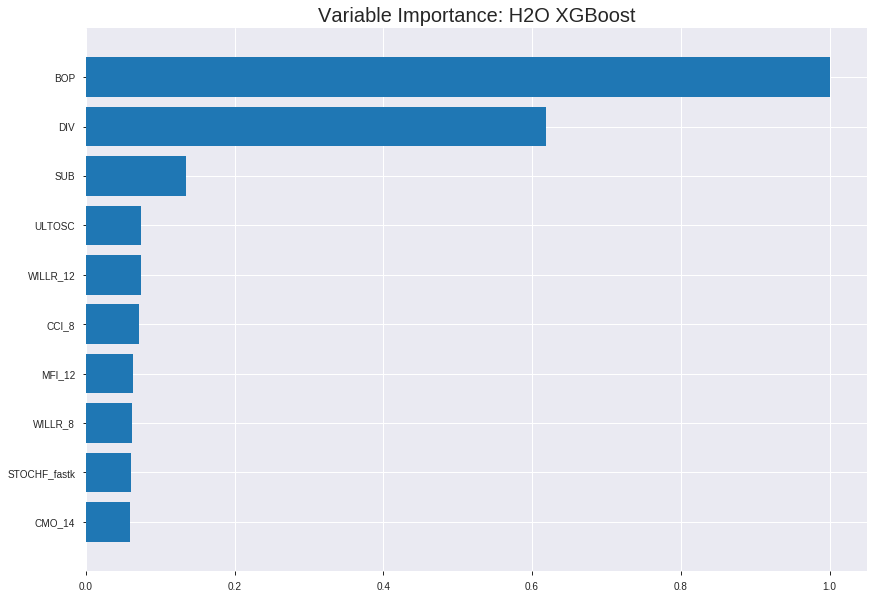

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_123019_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19518828427276325
RMSE: 0.4418011818372188
LogLoss: 0.5759429669918799
Mean Per-Class Error: 0.2816635385236749
AUC: 0.7823030259833852
pr_auc: 0.7624163640017037
Gini: 0.5646060519667704
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45116003851095837: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      476  383   0.4459   (383.0/859.0)
1      124  758   0.1406   (124.0/882.0)
Total  600  1141  0.2912   (507.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45116      0.749382  226
max f2                       0.272255     0.854386  325
max f0point5                 0.547911     0.723399  161
max accuracy                 0.492726     0.719127  199
max precision                0.746716     0.940299  21
max recall                   0.166332     1         385
max specificity              0.794692     0.998836  0
max absolute_mcc             0.492726     0.441684  199
max min_per_class_accuracy   0.531219     0.714785  172
max mean_per_class_accuracy  0.524472     0.718336  177

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.774482           1.7546    1.7546             0.888889         0.781737  0.888889                    0.781737            0.0181406       0.0181406                  75.4598   75.4598
    2        0.0201034                   0.766617           1.7417    1.74833            0.882353         0.76999   0.885714                    0.776031            0.0170068       0.0351474                  74.1697   74.8332
    3        0.0304423                   0.757722           1.97392   1.82495            1                0.762091  0.924528                    0.771297            0.0204082       0.0555556                  97.3923   82.4948
    4        0.0402068                   0.74453            1.7417    1.80473            0.882353         0.751189  0.914286                    0.766414            0.0170068       0.0725624                  74.1697   80.473
    5        0.0505457                   0.738261           1.7546    1.79448            0.888889         0.740322  0.909091                    0.761077            0.0181406       0.0907029                  75.4598   79.4475
    6        0.100517                    0.71118            1.58821   1.69193            0.804598         0.724433  0.857143                    0.74286             0.0793651       0.170068                   58.8214   69.1934
    7        0.150488                    0.687323           1.54284   1.64242            0.781609         0.699404  0.832061                    0.72843             0.0770975       0.247166                   54.2836   64.2424
    8        0.20046                     0.662076           1.49746   1.60629            0.758621         0.674607  0.813754                    0.715013            0.0748299       0.321995                   49.7459   60.6287
    9        0.300402                    0.621186           1.29326   1.50214            0.655172         0.641605  0.760994                    0.69059             0.129252        0.451247                   29.326    50.2144
    10       0.400345                    0.57892            1.42939   1.48398            0.724138         0.599283  0.751793                    0.667796            0.142857        0.594104                   42.9392   48.3982
    11       0.500287                    0.532292           1.19116   1.42549            0.603448         0.555263  0.722158                    0.645315            0.119048        0.713152                   19.116    42.5485
    12       0.60023                     0.478702           0.964273  1.34869            0.488506         0.507209  0.683254                    0.62232             0.0963719       0.809524                   -3.57273  34.869
    13       0.700172                    0.413728           0.794107  1.26953            0.402299         0.449246  0.64315                     0.597615            0.0793651       0.888889                   -20.5893  26.9529
    14       0.800115                    0.330941           0.567219  1.1818             0.287356         0.376567  0.598708                    0.570004            0.0566893       0.945578                   -43.2781  18.1803
    15       0.900057                    0.23785            0.374365  1.09214            0.189655         0.282766  0.553287                    0.538109            0.037415        0.982993                   -62.5635  9.2145
    16       1                           0.13087            0.170166  1                  0.0862069        0.192816  0.506605                    0.5036              



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22520643255514072
RMSE: 0.4745591981567112
LogLoss: 0.6419730309101379
Mean Per-Class Error: 0.35451639979338845
AUC: 0.6875322830578512
pr_auc: 0.6527248840061
Gini: 0.3750645661157024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46472346782684326: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      90   152  0.6281   (152.0/242.0)
1      30   226  0.1172   (30.0/256.0)
Total  120  378  0.3655   (182.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464723     0.712934  297
max f2                       0.356494     0.849629  362
max f0point5                 0.592141     0.656371  160
max accuracy                 0.508783     0.648594  254
max precision                0.777884     1         0
max recall                   0.27443      1         388
max specificity              0.777884     1         0
max absolute_mcc             0.482735     0.308592  279
max min_per_class_accuracy   0.560945     0.644531  200
max mean_per_class_accuracy  0.572252     0.645484  190

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 55.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.76957            1.94531   1.94531            1                0.772622  1                           0.772622            0.0195312       0.0195312                  94.5313   94.5313
    2        0.0200803                   0.757728           1.16719   1.55625            0.6              0.765131  0.8                         0.768876            0.0117188       0.03125                    16.7188   55.625
    3        0.0301205                   0.753128           0.778125  1.29688            0.4              0.755546  0.666667                    0.764433            0.0078125       0.0390625                  -22.1875  29.6875
    4        0.0401606                   0.74711            0.778125  1.16719            0.4              0.750202  0.6                         0.760875            0.0078125       0.046875                   -22.1875  16.7188
    5        0.0502008                   0.743046           1.55625   1.245              0.8              0.745456  0.64                        0.757791            0.015625        0.0625                     55.625    24.5
    6        0.100402                    0.722012           1.40063   1.32281            0.72             0.73288   0.68                        0.745336            0.0703125       0.132812                   40.0625   32.2813
    7        0.150602                    0.701448           1.16719   1.27094            0.6              0.711706  0.653333                    0.734126            0.0585938       0.191406                   16.7188   27.0938
    8        0.200803                    0.678007           1.55625   1.34227            0.8              0.688273  0.69                        0.722663            0.078125        0.269531                   55.625    34.2266
    9        0.301205                    0.63264            1.47844   1.38766            0.76             0.65605   0.713333                    0.700459            0.148438        0.417969                   47.8438   38.7656
    10       0.399598                    0.588564           1.19101   1.33924            0.612245         0.610288  0.688442                    0.678256            0.117188        0.535156                   19.1008   33.9235
    11       0.5                         0.56173            1.01156   1.27344            0.52             0.575735  0.654618                    0.657669            0.101562        0.636719                   1.15625   27.3438
    12       0.600402                    0.529213           0.894844  1.21013            0.46             0.545253  0.622074                    0.638871            0.0898438       0.726562                   -10.5156  21.0128
    13       0.698795                    0.491249           1.11161   1.19626            0.571429         0.51072   0.614943                    0.620826            0.109375        0.835938                   11.1607   19.6255
    14       0.799197                    0.453488           0.6225    1.12418            0.32             0.470443  0.577889                    0.601934            0.0625          0.898438                   -37.75    12.4176
    15       0.899598                    0.382116           0.6225    1.06818            0.32             0.427128  0.549107                    0.582424            0.0625          0.960938                   -37.75    6.8185
    16       1                           0.157786           0.389063  1                  0.2              0.303622  0.514056                    0.554432            0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:30:24  2.185 sec   0                  0.5              0.693147            0.5             0                  1                0.493395                         0.5                0.693147              0.5               0                    1                  0.485944
    2019-08-25 12:30:24  2.244 sec   5                  0.484423         0.662349            0.741305        0.726451           1.77653          0.341183                         0.492894           0.679005              0.679453          0.652981             1.38951            0.375502
    2019-08-25 12:30:24  2.289 sec   10                 0.474583         0.642973            0.743282        0.721713           1.64494          0.317634                         0.485187           0.663737              0.700139          0.660238             1.55625            0.339357
    2019-08-25 12:30:25  2.337 sec   15                 0.466511         0.626903            0.749659        0.732722           1.7546           0.324526                         0.482244           0.657794              0.691277          0.650975             1.16719            0.385542
    2019-08-25 12:30:25  2.385 sec   20                 0.460503         0.614752            0.754511        0.735481           1.86426          0.314762                         0.480142           0.653381              0.684046          0.65892              1.94531            0.385542
    2019-08-25 12:30:25  2.437 sec   25                 0.456604         0.606723            0.758354        0.73849            1.7546           0.3027                           0.478438           0.649869              0.686047          0.661928             1.55625            0.393574
    2019-08-25 12:30:25  2.490 sec   30                 0.453256         0.599722            0.761696        0.74238            1.64494          0.317059                         0.477056           0.647046              0.687944          0.661587             1.94531            0.353414
    2019-08-25 12:30:25  2.543 sec   35                 0.450068         0.593059            0.766536        0.747571           1.7546           0.306146                         0.47615            0.645185              0.689792          0.655739             1.55625            0.345382
    2019-08-25 12:30:25  2.595 sec   40                 0.447886         0.588476            0.770353        0.751735           1.64494          0.304997                         0.474854           0.642569              0.69315           0.655681             1.55625            0.361446
    2019-08-25 12:30:25  2.663 sec   45                 0.445796         0.584062            0.773337        0.753435           1.7546           0.309592                         0.475038           0.642931              0.690954          0.654775             1.94531            0.353414
    2019-08-25 12:30:25  2.720 sec   50                 0.443471         0.579354            0.778879        0.759503           1.7546           0.304423                         0.475325           0.643512              0.68591           0.648526             1.94531            0.369478
    2019-08-25 12:30:25  2.777 sec   55                 0.441801         0.575943            0.782303        0.762416           1.7546           0.291212                         0.474559           0.641973              0.687532          0

Variable Importances: 


variable     relative_importance    scaled_importance     percentage
-----------  ---------------------  --------------------  ---------------------
BOP          1359.88623046875       1.0                   0.34247774519574375
DIV          842.0738525390625      0.6192237509815813    0.21207035400782268
SUB          183.24453735351562     0.13474990278440543   0.04614884287094885
ULTOSC       101.97113037109375     0.07498504513568352   0.025680709181469967
WILLR_12     101.5187759399414      0.07465240375656138   0.025566786911989412
---          ---                    ---                   ---
CCI_24       14.147790908813477     0.01040365774123381   0.003563021245006
CMO_24       13.69236946105957      0.01006876101417678   0.003448326569050074
WILLR_24     10.520453453063965     0.00773627470986127   0.0026495019188481446
CCI_14       10.00224781036377      0.007355209271378544  0.002518995486704553
CDLLONGLINE  5.4462127685546875     0.004004903238616799  0.0013715902308886131


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6224899598393574)

('F1', 0.672782874617737)

('auc', 0.6564652371669916)

('logloss', 0.6562488446678822)

('mean_per_class_error', 0.38089668615984407)

('rmse', 0.4819992371262059)

('mse', 0.23232326459024447)

xgboost prediction progress: |████████████████████████████████████████████| 100%


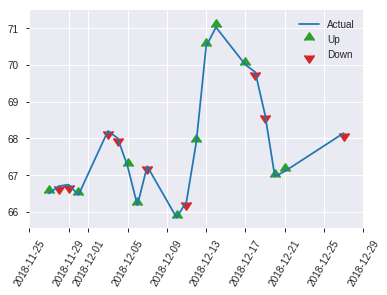


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23232326459024447
RMSE: 0.4819992371262059
LogLoss: 0.6562488446678822
Mean Per-Class Error: 0.38089668615984407
AUC: 0.6564652371669916
pr_auc: 0.5934407993727236
Gini: 0.31293047433398313
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34192273020744324: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   103  0.763    (103.0/135.0)
1      4    110  0.0351   (4.0/114.0)
Total  36   213  0.4297   (107.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341923     0.672783  212
max f2                       0.341923     0.822123  212
max f0point5                 0.537702     0.587189  111
max accuracy                 0.630757     0.62249   59
max precision                0.763781     0.8       4
max recall                   0.202915     1         245
max specificity              0.774702     0.992593  0
max absolute_mcc             0.341923     0.286102  212
max min_per_class_accuracy   0.529345     0.605263  119
max mean_per_class_accuracy  0.537702     0.619103  111

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 51.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.766469           1.45614   1.45614            0.666667         0.770788  0.666667                    0.770788            0.0175439       0.0175439                  45.614    45.614
    2        0.0200803                   0.760156           2.18421   1.74737            1                0.763854  0.8                         0.768014            0.0175439       0.0350877                  118.421   74.7368
    3        0.0321285                   0.749109           0.72807   1.36513            0.333333         0.758804  0.625                       0.76456             0.00877193      0.0438596                  -27.193   36.5132
    4        0.0401606                   0.734408           1.09211   1.31053            0.5              0.738434  0.6                         0.759335            0.00877193      0.0526316                  9.21053   31.0526
    5        0.0522088                   0.731213           2.18421   1.51215            1                0.73289   0.692308                    0.753232            0.0263158       0.0789474                  118.421   51.2146
    6        0.100402                    0.69778            1.63816   1.57263            0.75             0.716569  0.72                        0.735634            0.0789474       0.157895                   63.8158   57.2632
    7        0.15261                     0.679851           1.34413   1.49446            0.615385         0.689896  0.684211                    0.719987            0.0701754       0.22807                    34.413    49.446
    8        0.200803                    0.65889            1.27412   1.44158            0.583333         0.6658    0.66                        0.706982            0.0614035       0.289474                   27.4123   44.1579
    9        0.301205                    0.605068           1.13579   1.33965            0.52             0.62672   0.613333                    0.680228            0.114035        0.403509                   13.5789   33.9649
    10       0.401606                    0.56855            0.961053  1.245              0.44             0.585704  0.57                        0.656597            0.0964912       0.5                        -3.89474  24.5
    11       0.502008                    0.523              1.04842   1.20568            0.48             0.540236  0.552                       0.633325            0.105263        0.605263                   4.84211   20.5684
    12       0.598394                    0.491962           1.18311   1.20205            0.541667         0.505473  0.550336                    0.612731            0.114035        0.719298                   18.3114   20.2049
    13       0.698795                    0.428472           0.786316  1.14232            0.36             0.462905  0.522989                    0.591205            0.0789474       0.798246                   -21.3684  14.2317
    14       0.799197                    0.378544           0.873684  1.10857            0.4              0.40342   0.507538                    0.567613            0.0877193       0.885965                   -12.6316  10.8569
    15       0.899598                    0.31963            0.786316  1.0726             0.36             0.348584  0.491071                    0.543168            0.0789474       0.964912                   -21.3684  7.26034
    16       1                           0.145273           0.349474  1                  0.16             0.24953   0.457831                    0.513686            0.

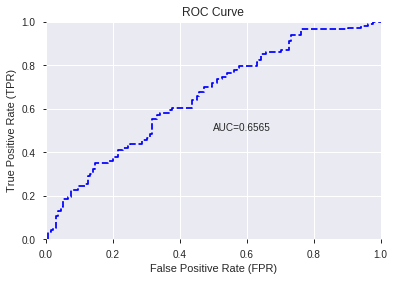

This function is available for GLM models only


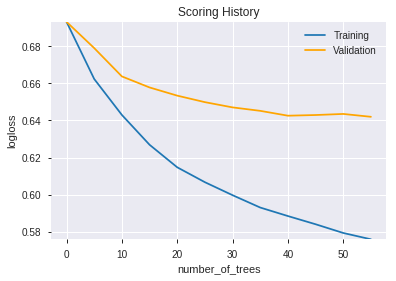

--2019-08-25 12:30:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_123019_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_123019_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'SUB',
 'ULTOSC',
 'WILLR_12',
 'CCI_8',
 'MFI_12',
 'WILLR_8',
 'STOCHF_fastk',
 'CMO_14',
 'MFI_14',
 'MOM_8',
 'STOCHRSI_fastk',
 'CCI_12',
 'ROC_8',
 'MINUS_DI_8',
 'CCI_20',
 'WILLR_20',
 'WILLR_14',
 'CMO_30',
 'MINUS_DI_14',
 'CMO_20',
 'CCI_30',
 'WILLR_30',
 'ROC_12',
 'ROC_14',
 'MINUS_DI_12',
 'CMO_8',
 'CMO_12',
 'CCI_24',
 'CMO_24',
 'WILLR_24',
 'CCI_14',
 'CDLLONGLINE']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

60

['BBANDS_upperband_20_5_5',
 'BBANDS_lowerband_20_7_2',
 'aroonup_8',
 'AROONOSC_8',
 'CMO_8',
 'MACDFIX_hist_8',
 'MFI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROC_8',
 'ROCR_8',
 'ADX_12',
 'AROONOSC_12',
 'CMO_12',
 'MFI_12',
 'MINUS_DI_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'WILLR_12',
 'aroonup_14',
 'AROONOSC_14',
 'CCI_14',
 'MACDFIX_hist_14',
 'MINUS_DI_14',
 'MOM_14',
 'ROCP_14',
 'TRIX_14',
 'WILLR_14',
 'aroonup_20',
 'AROONOSC_20',
 'CCI_20',
 'CMO_20',
 'PLUS_DI_20',
 'ROCP_20',
 'aroonup_24',
 'PLUS_DI_24',
 'ROCR_24',
 'ROCR100_24',
 'MFI_30',
 'PLUS_DI_30',
 'ROC_30',
 'ROCP_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'OBV',
 'NATR_8',
 'NATR_30',
 'HT_DCPERIOD',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CORREL_8',
 'LINEARREG_SLOPE_8',
 'LINEARREG_SLOPE_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_123200_model_3  0.635023  0.658918              0.383236  0.483016  0.233305
1  DeepLearning_grid_1_AutoML_20190825_123200_model_2  0.634178  0.690351              0.423294  0.493578  0.243620
2  DeepLearning_grid_1_AutoML_20190825_123200_model_1  0.629955  0.754680              0.405458  0.513286  0.263462
3  DeepLearning_grid_1_AutoML_20190825_123200_model_9  0.629630  0.657655              0.386940  0.482832  0.233127
4  DeepLearning_grid_1_AutoML_20190825_123200_model_5  0.619623  0.665950              0.425634  0.486366  0.236552
5  DeepLearning_grid_1_AutoML_20190825_123200_model_6  0.616114  0.665174              0.435088  0.486422  0.236607
6  DeepLearning_grid_1_AutoML_20190825_123200_model_8  0.612411  0.663817              0.436452  0.485627  0.235834
7  DeepLearning_grid_1_AutoML_20190825_123200_model_7  0.609747  0.750564              0.439084  0.521924  0.272405
8  DeepLearning_grid_1_AutoML_20190825_123200_model_4  0.603444  0.835367              0.430409  0.537512  0.288920
9               DeepLearning_1_AutoML_20190825_123200  0.583366  0.739612              0.468031  0.513786  0.263976

variable  relative_importance  scaled_importance  percentage
0        CDLCLOSINGMARUBOZU             1.000000           1.000000    0.022443
1                  CORREL_8             0.944361           0.944361    0.021194
2                       OBV             0.888386           0.888386    0.019938
3            STOCHRSI_fastk             0.874948           0.874948    0.019636
4                 aroonup_8             0.869656           0.869656    0.019518
5   BBANDS_upperband_20_5_5             0.866372           0.866372    0.019444
6               HT_DCPERIOD             0.860099           0.860099    0.019303
7            STOCHRSI_fastd             0.838196           0.838196    0.018812
8                    ADX_12             0.832399           0.832399    0.018681
9                   NATR_30             0.809790           0.809790    0.018174
10             STOCHF_fastk             0.809185           0.809185    0.018160
11                PLUS_DM_8             0.807523           0.807523    0.018123
12              AROONOSC_20             0.804586           0.804586    0.018057
13               aroonup_20             0.801062           0.801062    0.017978
14              CDLBELTHOLD             0.799195           0.799195    0.017936
15                   NATR_8             0.792437           0.792437    0.017785
16              AROONOSC_14             0.788130           0.788130    0.017688
17     HT_PHASOR_quadrature             0.780138           0.780138    0.017509
18               aroonup_24             0.779143           0.779143    0.017486
19                    MFI_8             0.778377           0.778377    0.017469
20                 WILLR_12             0.776908           0.776908    0.017436
21               AROONOSC_8             0.772102           0.772102    0.017328
22  BBANDS_lowerband_20_7_2             0.761511           0.761511    0.017091
23                   MFI_30             0.750601           0.750601    0.016846
24                 WILLR_14             0.749125           0.749125    0.016813
25              STOCH_slowk             0.747092           0.747092    0.016767
26               aroonup_14             0.747070           0.747070    0.016766
27               PLUS_DI_30             0.738617           0.738617    0.016577
28              MINUS_DI_14             0.733221           0.733221    0.016456
29              STOCH_slowd             0.730410           0.730410    0.016393
30                  TRIX_14             0.723306           0.723306    0.016233
31               ROCR100_24             0.717470           0.717470    0.016102
32        HT_PHASOR_inphase             0.709025           0.709025    0.015913
33               PLUS_DI_24             0.707288           0.707288    0.015874
34                   ROC_12             0.701003           0.701003    0.015733
35                   ROC_30             0.698202           0.698202    0.015670
36                  ROCP_30             0.698078           0.698078    0.015667
37              MINUS_DI_12             0.696631           0.696631    0.015634
38                 WILLR_30             0.694763           0.694763    0.015592
39                   CCI_20             0.688053           0.688053    0.015442
40                   CMO_20             0.687942           0.687942    0.015439
41              AROONOSC_12             0.686645           0.686645    0.015410
42                   MFI_12             0.685205           0.685205    0.015378
43        LINEARREG_SLOPE_8             0.683151           0.683151    0.015332
44                  ROCP_12             0.682515           0.682515    0.015318
45                   MOM_14             0.682463           0.682463    0.015316
46                PLUS_DI_8             0.677170           0.677170    0.015198
47               PLUS_DI_20             0.676120           0.676120    0.015174
48          MACDFIX_hist_14             0.670818           0.670818    0.015055
49                 

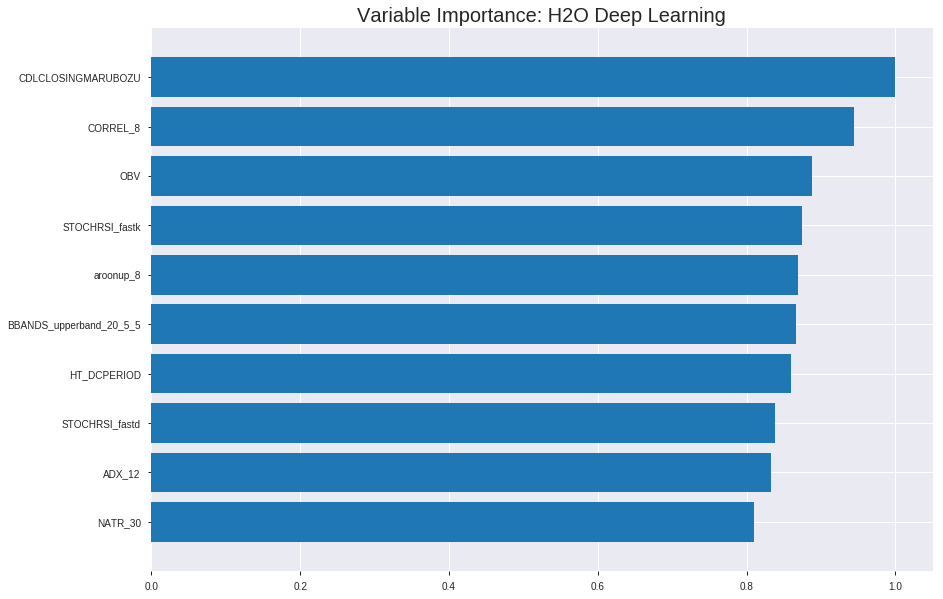

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_123200_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2225614354495717
RMSE: 0.47176417355451195
LogLoss: 0.6401478862181758
Mean Per-Class Error: 0.3539018634229012
AUC: 0.697783110139671
pr_auc: 0.6879521177305267
Gini: 0.39556622027934196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23361070609651907: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      191  668   0.7776   (668.0/859.0)
1      47   835   0.0533   (47.0/882.0)
Total  238  1503  0.4107   (715.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.233611     0.70021   324
max f2                       0.0672142    0.839221  385
max f0point5                 0.526205     0.652016  183
max accuracy                 0.526205     0.645606  183
max precision                0.939894     0.952381  8
max recall                   0.0231299    1         397
max specificity              0.980692     0.998836  0
max absolute_mcc             0.451659     0.294679  224
max min_per_class_accuracy   0.509622     0.638322  193
max mean_per_class_accuracy  0.526205     0.646098  183

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 49.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.941745           1.86426   1.86426            0.944444         0.958093  0.944444                    0.958093            0.0192744       0.0192744                  86.4261   86.4261
    2        0.0201034                   0.928851           1.7417    1.80473            0.882353         0.935239  0.914286                    0.946992            0.0170068       0.0362812                  74.1697   80.473
    3        0.0304423                   0.913908           1.53527   1.71322            0.777778         0.921711  0.867925                    0.938406            0.015873        0.0521542                  53.5273   71.3216
    4        0.0402068                   0.89708            1.27724   1.60734            0.647059         0.90687   0.814286                    0.930747            0.0124717       0.0646259                  27.7244   60.7337
    5        0.0505457                   0.876888           1.53527   1.5926             0.777778         0.885898  0.806818                    0.921574            0.015873        0.0804989                  53.5273   59.2597
    6        0.100517                    0.803552           1.45208   1.52274            0.735632         0.839797  0.771429                    0.880919            0.0725624       0.153061                   45.2081   52.2741
    7        0.150488                    0.746145           1.49746   1.51435            0.758621         0.772662  0.767176                    0.844971            0.0748299       0.227891                   49.7459   51.4345
    8        0.20046                     0.689202           1.33864   1.47054            0.678161         0.71376   0.744986                    0.812262            0.0668934       0.294785                   33.8637   47.0544
    9        0.300402                    0.612798           1.29326   1.41156            0.655172         0.647211  0.715105                    0.75735             0.129252        0.424036                   29.326    41.1562
    10       0.400345                    0.557276           1.05503   1.32256            0.534483         0.584106  0.670014                    0.714101            0.105442        0.529478                   5.50278   32.2557
    11       0.500287                    0.509404           1.08906   1.27591            0.551724         0.532161  0.646383                    0.677755            0.108844        0.638322                   8.90609   27.5911
    12       0.60023                     0.451296           1.04368   1.23724            0.528736         0.48221   0.626794                    0.645195            0.104308        0.74263                    4.36834   23.7244
    13       0.700172                    0.381392           0.839484  1.18047            0.425287         0.417754  0.598031                    0.61273             0.0839002       0.826531                   -16.0516  18.0467
    14       0.800115                    0.295706           0.703352  1.12087            0.356322         0.337632  0.567839                    0.578368            0.0702948       0.896825                   -29.6648  12.0871
    15       0.900057                    0.188888           0.635286  1.06695            0.321839         0.244998  0.540523                    0.54135             0.0634921       0.960317                   -36.4714  6.69513
    16       1                           0.0124348          0.397053  1                  0.201149         0.117662  0.506605                    0.499006          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24775153907428785
RMSE: 0.4977464606346165
LogLoss: 0.6934616419864916
Mean Per-Class Error: 0.39947055785123964
AUC: 0.6298989540289256
pr_auc: 0.5964167399824152
Gini: 0.2597979080578512
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25681537236931296: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      60   182  0.7521   (182.0/242.0)
1      12   244  0.0469   (12.0/256.0)
Total  72   426  0.3896   (194.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.256815     0.715543  333
max f2                       0.224124     0.846883  356
max f0point5                 0.256815     0.622449  333
max accuracy                 0.256815     0.610442  333
max precision                0.896772     1         0
max recall                   0.0449711    1         399
max specificity              0.896772     1         0
max absolute_mcc             0.256815     0.285746  333
max min_per_class_accuracy   0.436254     0.585938  198
max mean_per_class_accuracy  0.256815     0.600529  333

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 44.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.869257           0.778125  0.778125           0.4              0.886166  0.4                         0.886166            0.0078125       0.0078125                  -22.1875  -22.1875
    2        0.0200803                   0.838048           1.16719   0.972656           0.6              0.854735  0.5                         0.870451            0.0117188       0.0195312                  16.7188   -2.73437
    3        0.0301205                   0.79264            1.16719   1.0375             0.6              0.8265    0.533333                    0.8558              0.0117188       0.03125                    16.7188   3.75
    4        0.0401606                   0.777656           1.16719   1.06992            0.6              0.785499  0.55                        0.838225            0.0117188       0.0429688                  16.7188   6.99219
    5        0.0502008                   0.757656           1.16719   1.08938            0.6              0.769356  0.56                        0.824451            0.0117188       0.0546875                  16.7188   8.9375
    6        0.100402                    0.677645           1.245     1.16719            0.64             0.720808  0.6                         0.77263             0.0625          0.117188                   24.5      16.7188
    7        0.150602                    0.614651           1.32281   1.21906            0.68             0.650343  0.626667                    0.731867            0.0664062       0.183594                   32.2813   21.9063
    8        0.200803                    0.584494           1.40063   1.26445            0.72             0.600774  0.65                        0.699094            0.0703125       0.253906                   40.0625   26.4453
    9        0.301205                    0.529811           1.245     1.25797            0.64             0.551997  0.646667                    0.650062            0.125           0.378906                   24.5      25.7969
    10       0.399598                    0.476664           1.07191   1.21215            0.55102          0.501974  0.623116                    0.613598            0.105469        0.484375                   7.19069   21.2155
    11       0.5                         0.436254           1.01156   1.17188            0.52             0.455341  0.60241                     0.581819            0.101562        0.585938                   1.15625   17.1875
    12       0.600402                    0.391437           0.972656  1.13856            0.5              0.415451  0.585284                    0.553999            0.0976562       0.683594                   -2.73437  13.8561
    13       0.698795                    0.34354            0.913106  1.10682            0.469388         0.366563  0.568966                    0.527607            0.0898438       0.773438                   -8.68941  10.6816
    14       0.799197                    0.284284           1.01156   1.09485            0.52             0.314188  0.562814                    0.500795            0.101562        0.875                      1.15625   9.48492
    15       0.899598                    0.225336           0.894844  1.07253            0.46             0.258758  0.551339                    0.473782            0.0898438       0.964844                   -10.5156  7.25272
    16       1                           0.0449711          0.350156  1                  0.18             0.148769  0.514056                    0.44115            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:33:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:33:22  1 min 20.588 sec  5671 obs/sec      7.61287   1             13254      0.50772          0.741739            -0.0313001     0.638497        0.639005           1.64494          0.448593                         0.543966           0.855027              -0.184531        0.578763          0.564646             1.55625            0.459839
    2019-08-25 12:33:27  1 min 26.001 sec  5199 obs/sec      22.826    3             39740      0.471764         0.640148            0.109599       0.697783        0.687952           1.86426          0.410684                         0.497746           0.693462              0.00821002       0.629899          0.596417             0.778125           0.389558
    2019-08-25 12:33:33  1 min 31.183 sec  6246 obs/sec      45.6651   6             79503      0.466446         0.629496            0.129562       0.716076        0.705326           1.7546           0.366456                         0.502009           0.699995              -0.00884889      0.624201          0.587763             0.778125           0.399598
    2019-08-25 12:33:38  1 min 36.986 sec  7195 obs/sec      76.1723   10            132616     0.4539           0.599737            0.175757       0.74939         0.742122           1.86426          0.327972                         0.509882           0.730931              -0.0407408       0.605614          0.573097             1.16719            0.425703
    2019-08-25 12:33:44  1 min 42.116 sec  7909 obs/sec      106.588   14            185570     0.432771         0.554142            0.250706       0.790601        0.785822           1.86426          0.298105                         0.523718           0.777093              -0.0979918       0.57961           0.54928              1.16719            0.447791
    2019-08-25 12:33:49  1 min 47.981 sec  8618 obs/sec      144.687   19            251900     0.417911         0.523377            0.301279       0.824873        0.821743           1.97392          0.261344                         0.549368           0.894707              -0.208177        0.555882          0.5368               0.778125           0.463855
    2019-08-25 12:33:55  1 min 53.456 sec  9195 obs/sec      182.76    24            318185     0.394234         0.477688            0.378211       0.856911        0.853325           1.97392          0.220563                         0.545523           0.883815              -0.191323        0.564921          0.544764             1.16719            0.435743
    2019-08-25 12:33:55  1 min 53.559 sec  9193 obs/sec      182.76    24            318185     0.471764         0.640148            0.109599       0.697783        0.687952           1.86426          0.410684                         0.497746           0.693462              0.00821002       0.629899          0.596417             0.778125           0.389558

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.022442892049428335
CORREL_8            0.94436115026474       0.94436115026474     0.021194195351065533
OBV                 0.8883863091468811     0.8883863091468811   0.019937958034373524
STOCHRSI_fastk      0.8749484419822693     0.8749484419822693   0.019636373432223582
aroonup_8           0.8696555495262146     0.8696555495262146   0.019517585618203114
---                 ---                    ---                  ---
ROCP_20             0.6505837440490723     0.6505837440490723   0.014600980736806244
CCI_14              0.6482686400413513     0.6482686400413513   0.014549023107477764
ROCR_24             0.6445803642272949     0.6445803642272949   0.014466247531534379
MACDFIX_hist_8      0.6416018009185791     0.6416018009185791   0.014399399956734482
MOM_12              0.6276859641075134     0.6276859641075134   0.014087088333406274


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6104417670682731)

('F1', 0.6751592356687899)

('auc', 0.635022742040286)

('logloss', 0.6589175523653644)

('mean_per_class_error', 0.3832358674463938)

('rmse', 0.4830161010995494)

('mse', 0.23330455392141014)

deeplearning prediction progress: |███████████████████████████████████████| 100%


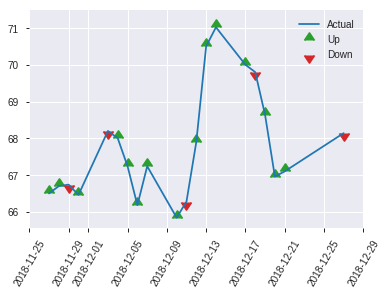


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23330455392141014
RMSE: 0.4830161010995494
LogLoss: 0.6589175523653644
Mean Per-Class Error: 0.3832358674463938
AUC: 0.635022742040286
pr_auc: 0.5932844524651762
Gini: 0.27004548408057194
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3315515977106118: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      41   94   0.6963   (94.0/135.0)
1      8    106  0.0702   (8.0/114.0)
Total  49   200  0.4096   (102.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331552     0.675159  199
max f2                       0.302433     0.81448   206
max f0point5                 0.331552     0.579869  199
max accuracy                 0.551224     0.610442  80
max precision                0.932573     1         0
max recall                   0.0783659    1         248
max specificity              0.932573     1         0
max absolute_mcc             0.331552     0.292648  199
max min_per_class_accuracy   0.478375     0.57037   123
max mean_per_class_accuracy  0.331552     0.616764  199

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 47.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.891369           2.18421   2.18421            1                0.913686  1                           0.913686            0.0263158       0.0263158                  118.421   118.421
    2        0.0200803                   0.868853           1.09211   1.74737            0.5              0.885651  0.8                         0.902472            0.00877193      0.0350877                  9.21053   74.7368
    3        0.0321285                   0.865483           2.18421   1.91118            1                0.867588  0.875                       0.88939             0.0263158       0.0614035                  118.421   91.1184
    4        0.0401606                   0.853057           1.09211   1.74737            0.5              0.859922  0.8                         0.883497            0.00877193      0.0701754                  9.21053   74.7368
    5        0.0522088                   0.840963           2.18421   1.84818            1                0.847278  0.846154                    0.875139            0.0263158       0.0964912                  118.421   84.8178
    6        0.100402                    0.697387           1.45614   1.66               0.666667         0.78253   0.76                        0.830686            0.0701754       0.166667                   45.614    66
    7        0.15261                     0.629615           0.840081  1.3795             0.384615         0.651553  0.631579                    0.769404            0.0438596       0.210526                   -15.9919  37.9501
    8        0.200803                    0.609339           1.27412   1.35421            0.583333         0.619785  0.62                        0.733495            0.0614035       0.27193                    27.4123   35.4211
    9        0.301205                    0.557342           1.22316   1.31053            0.56             0.583765  0.6                         0.683585            0.122807        0.394737                   22.3158   31.0526
    10       0.401606                    0.517174           1.04842   1.245              0.48             0.536478  0.57                        0.646808            0.105263        0.5                        4.84211   24.5
    11       0.502008                    0.477604           0.873684  1.17074            0.4              0.500708  0.536                       0.617588            0.0877193       0.587719                   -12.6316  17.0737
    12       0.598394                    0.449527           0.910088  1.12875            0.416667         0.463687  0.516779                    0.592799            0.0877193       0.675439                   -8.99123  12.8753
    13       0.698795                    0.403438           1.04842   1.11721            0.48             0.428082  0.511494                    0.569132            0.105263        0.780702                   4.84211   11.7211
    14       0.799197                    0.33287            1.39789   1.15247            0.64             0.374465  0.527638                    0.544677            0.140351        0.921053                   39.7895   15.2473
    15       0.899598                    0.215509           0.349474  1.06285            0.16             0.279963  0.486607                    0.515133            0.0350877       0.95614                    -65.0526  6.28524
    16       1                           0.0783659          0.436842  1                  0.2              0.159994  0.457831                    0.479476            0.043

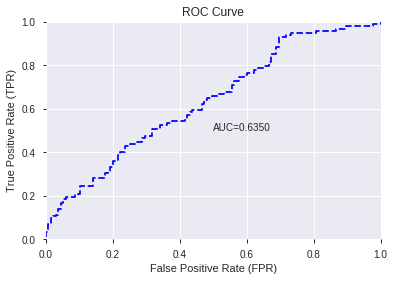

This function is available for GLM models only


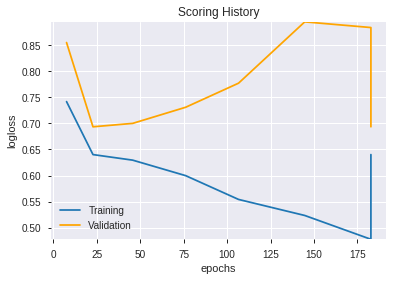

--2019-08-25 12:41:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_123200_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_123200_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'CORREL_8',
 'OBV',
 'STOCHRSI_fastk',
 'aroonup_8',
 'BBANDS_upperband_20_5_5',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'ADX_12',
 'NATR_30',
 'STOCHF_fastk',
 'PLUS_DM_8',
 'AROONOSC_20',
 'aroonup_20',
 'CDLBELTHOLD',
 'NATR_8',
 'AROONOSC_14',
 'HT_PHASOR_quadrature',
 'aroonup_24',
 'MFI_8',
 'WILLR_12',
 'AROONOSC_8',
 'BBANDS_lowerband_20_7_2',
 'MFI_30',
 'WILLR_14',
 'STOCH_slowk',
 'aroonup_14',
 'PLUS_DI_30',
 'MINUS_DI_14',
 'STOCH_slowd',
 'TRIX_14',
 'ROCR100_24',
 'HT_PHASOR_inphase',
 'PLUS_DI_24',
 'ROC_12',
 'ROC_30',
 'ROCP_30',
 'MINUS_DI_12',
 'WILLR_30',
 'CCI_20',
 'CMO_20',
 'AROONOSC_12',
 'MFI_12',
 'LINEARREG_SLOPE_8',
 'ROCP_12',
 'MOM_14',
 'PLUS_DI_8',
 'PLUS_DI_20',
 'MACDFIX_hist_14',
 'ROCR_8',
 'CMO_12',
 'ROC_8',
 'LINEARREG_SLOPE_12',
 'ROCP_14',
 'CMO_8',
 'ROCP_20',
 'CCI_14',
 'ROCR_24',
 'MACDFIX_hist_8',
 'MOM_12']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_124113_model_1  0.62872  0.662494              0.401072  0.485337  0.235552

variable  relative_importance  scaled_importance  percentage
0        CDLCLOSINGMARUBOZU             0.198380           1.000000    0.091431
1               CDLBELTHOLD             0.159138           0.802188    0.073345
2              STOCHF_fastk             0.144276           0.727269    0.066495
3            STOCHRSI_fastk             0.122053           0.615247    0.056252
4                  WILLR_12             0.100407           0.506133    0.046276
5            STOCHRSI_fastd             0.098502           0.496533    0.045398
6                 aroonup_8             0.090428           0.455834    0.041677
7                  WILLR_30             0.078762           0.397025    0.036300
8               STOCH_slowd             0.059094           0.297884    0.027236
9                     CMO_8             0.057230           0.288489    0.026377
10                      OBV             0.055566           0.280101    0.025610
11                   NATR_8             0.053653           0.270458    0.024728
12              STOCH_slowk             0.047667           0.240282    0.021969
13                  TRIX_14             0.047558           0.239730    0.021919
14     HT_PHASOR_quadrature             0.046929           0.236562    0.021629
15                   CMO_12             0.041917           0.211298    0.019319
16                 WILLR_14             0.041757           0.210491    0.019245
17               PLUS_DI_20             0.040257           0.202929    0.018554
18                PLUS_DI_8             0.038062           0.191864    0.017542
19               aroonup_20             0.035294           0.177913    0.016267
20                  ROCP_14             0.035172           0.177294    0.016210
21                   CMO_20             0.034800           0.175419    0.016039
22                   MFI_12             0.034224           0.172516    0.015773
23               PLUS_DI_24             0.033794           0.170348    0.015575
24              AROONOSC_20             0.031007           0.156300    0.014291
25          MACDFIX_hist_14             0.026641           0.134294    0.012279
26       LINEARREG_SLOPE_12             0.025864           0.130375    0.011920
27                 CORREL_8             0.022884           0.115355    0.010547
28               aroonup_14             0.022309           0.112458    0.010282
29               PLUS_DI_30             0.021943           0.110613    0.010113
30                PLUS_DM_8             0.020274           0.102197    0.009344
31               AROONOSC_8             0.019790           0.099756    0.009121
32                  ROCP_12             0.019721           0.099408    0.009089
33                   ROC_12             0.019555           0.098571    0.009012
34                    ROC_8             0.018561           0.093562    0.008554
35                   ROCR_8             0.018507           0.093291    0.008530
36              HT_DCPERIOD             0.018081           0.091143    0.008333
37                  ROCP_20             0.017376           0.087588    0.008008
38  BBANDS_upperband_20_5_5             0.016241           0.081869    0.007485
39           MACDFIX_hist_8             0.015767           0.079480    0.007267
40                   MOM_14             0.014276           0.071963    0.006580
41                   CCI_20             0.013369           0.067390    0.006161
42                   MFI_30             0.013282           0.066951    0.006121
43              MINUS_DI_12             0.011667           0.058813    0.005377
44               aroonup_24             0.010849           0.054688    0.005000
45                  ROCP_30             0.010690           0.053887    0.004927
46                   ROC_30             0.010584           0.053352    0.004878
47              MINUS_DI_14             0.009759           0.049193    0.004498
48                    MFI_8             0.009118           0.045961    0.004202
49                 

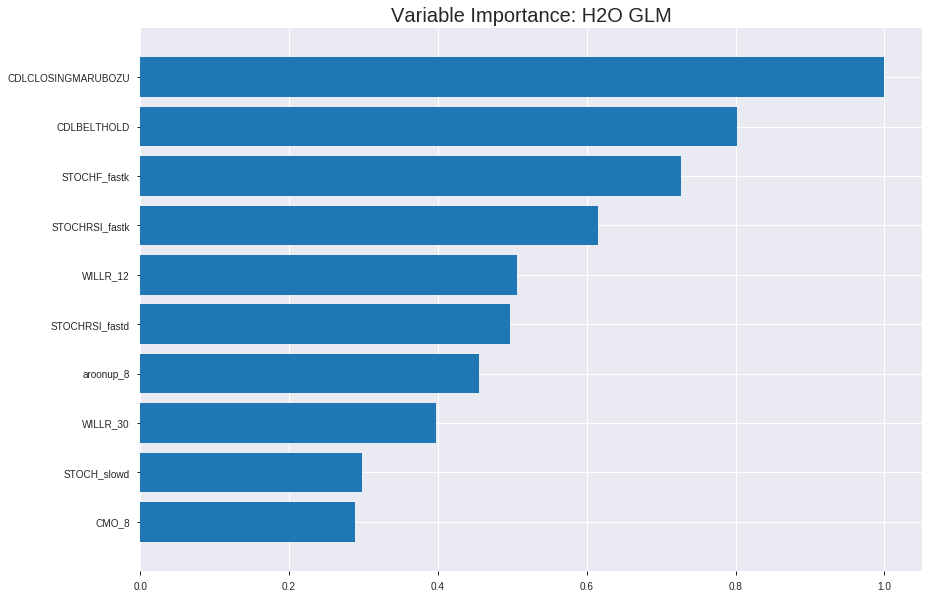

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_124113_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2244475785993408
RMSE: 0.4737589878823839
LogLoss: 0.6400248579452829
Null degrees of freedom: 1740
Residual degrees of freedom: 1680
Null deviance: 2413.2346255079065
Residual deviance: 2228.566555365475
AIC: 2350.566555365475
AUC: 0.687542071543402
pr_auc: 0.6698159451565505
Gini: 0.37508414308680393
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3870237719353251: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      233  626   0.7288   (626.0/859.0)
1      75   807   0.085    (75.0/882.0)
Total  308  1433  0.4026   (701.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387024     0.697192  296
max f2                       0.216294     0.839527  386
max f0point5                 0.489147     0.645928  213
max accuracy                 0.489147     0.643308  213
max precision                0.847095     1         0
max recall                   0.171252     1         399
max specificity              0.847095     1         0
max absolute_mcc             0.489147     0.28752   213
max min_per_class_accuracy   0.512417     0.636787  192
max mean_per_class_accuracy  0.489147     0.642434  213

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103389                   0.790367           1.64494   1.64494            0.833333         0.814425  0.833333                    0.814425            0.0170068       0.0170068                  64.4936    64.4936
    2        0.0201034                   0.771897           1.62558   1.63554            0.823529         0.782255  0.828571                    0.7988              0.015873        0.0328798                  62.5584    63.5536
    3        0.0304423                   0.75327            1.09662   1.45251            0.555556         0.761565  0.735849                    0.786154            0.0113379       0.0442177                  9.66238    45.2509
    4        0.0402068                   0.739              1.7417    1.52274            0.882353         0.744871  0.771429                    0.776128            0.0170068       0.0612245                  74.1697    52.2741
    5        0.0505457                   0.72822            1.7546    1.57017            0.888889         0.733529  0.795455                    0.767415            0.0181406       0.0793651                  75.4598    57.0166
    6        0.100517                    0.676227           1.47477   1.52274            0.747126         0.702862  0.771429                    0.735323            0.0736961       0.153061                   47.477     52.2741
    7        0.150488                    0.638014           1.29326   1.44654            0.655172         0.654581  0.732824                    0.708512            0.0646259       0.217687                   29.326     44.6539
    8        0.20046                     0.613704           1.31595   1.41398            0.666667         0.624094  0.716332                    0.687468            0.0657596       0.283447                   31.5949    41.3985
    9        0.300402                    0.579663           1.24788   1.35872            0.632184         0.59659   0.688337                    0.657233            0.124717        0.408163                   24.7882    35.8723
    10       0.400345                    0.543006           1.22519   1.32539            0.62069          0.559707  0.671449                    0.632887            0.122449        0.530612                   22.5194    32.5389
    11       0.500287                    0.51258            1.04368   1.26911            0.528736         0.528513  0.642939                    0.612036            0.104308        0.634921                   4.36834    26.9112
    12       0.60023                     0.480659           0.998306  1.22402            0.505747         0.495115  0.620096                    0.592568            0.0997732       0.734694                   -0.169416  22.4021
    13       0.700172                    0.437865           0.873518  1.17399            0.442529         0.460093  0.59475                     0.573658            0.0873016       0.821995                   -12.6482   17.399
    14       0.800115                    0.398024           0.737385  1.11945            0.373563         0.419122  0.567121                    0.554355            0.0736961       0.895692                   -26.2615   11.9454
    15       0.900057                    0.323425           0.635286  1.06569            0.321839         0.365702  0.539885                    0.533407            0.0634921       0.959184                   -36.4714   6.56916
    16       1                           0.171022           0.408398  1                  0.206897         0.265237  0.506605                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23351570410693342
RMSE: 0.4832346263534241
LogLoss: 0.6604168251838237
Null degrees of freedom: 497
Residual degrees of freedom: 437
Null deviance: 690.0915890932606
Residual deviance: 657.7751578830885
AIC: 779.7751578830885
AUC: 0.6538206998966942
pr_auc: 0.6168030642824244
Gini: 0.30764139979338845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39373794095776105: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      53   189  0.781    (189.0/242.0)
1      15   241  0.0586   (15.0/256.0)
Total  68   430  0.4096   (204.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393738     0.702624  335
max f2                       0.248063     0.843215  395
max f0point5                 0.511193     0.65027   241
max accuracy                 0.511193     0.644578  241
max precision                0.849555     1         0
max recall                   0.248063     1         395
max specificity              0.849555     1         0
max absolute_mcc             0.511193     0.290717  241
max min_per_class_accuracy   0.537757     0.619835  200
max mean_per_class_accuracy  0.511193     0.641416  241

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 53.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.803143           1.16719   1.16719            0.6              0.827285  0.6                         0.827285            0.0117188       0.0117188                  16.7188   16.7188
    2        0.0200803                   0.782425           0.778125  0.972656           0.4              0.798249  0.5                         0.812767            0.0078125       0.0195312                  -22.1875  -2.73437
    3        0.0301205                   0.769422           1.55625   1.16719            0.8              0.776757  0.6                         0.800764            0.015625        0.0351562                  55.625    16.7188
    4        0.0401606                   0.758009           0.778125  1.06992            0.4              0.76465   0.55                        0.791735            0.0078125       0.0429688                  -22.1875  6.99219
    5        0.0502008                   0.746951           1.94531   1.245              1                0.752132  0.64                        0.783815            0.0195312       0.0625                     94.5313   24.5
    6        0.100402                    0.68959            1.245     1.245              0.64             0.718476  0.64                        0.751145            0.0625          0.125                      24.5      24.5
    7        0.150602                    0.660002           1.40063   1.29688            0.72             0.674573  0.666667                    0.725621            0.0703125       0.195312                   40.0625   29.6875
    8        0.200803                    0.627393           1.245     1.28391            0.64             0.642828  0.66                        0.704923            0.0625          0.257812                   24.5      28.3906
    9        0.301205                    0.593411           1.245     1.27094            0.64             0.610984  0.653333                    0.67361             0.125           0.382812                   24.5      27.0938
    10       0.399598                    0.564698           1.15131   1.24148            0.591837         0.578781  0.638191                    0.65026             0.113281        0.496094                   15.1307   24.1481
    11       0.5                         0.538414           1.16719   1.22656            0.6              0.552355  0.630522                    0.630601            0.117188        0.613281                   16.7188   22.6562
    12       0.600402                    0.515196           1.12828   1.21013            0.58             0.528052  0.622074                    0.613452            0.113281        0.726562                   12.8281   21.0128
    13       0.698795                    0.484737           0.794005  1.15154            0.408163         0.500579  0.591954                    0.597559            0.078125        0.804688                   -20.5995  15.1536
    14       0.799197                    0.442975           0.855938  1.1144             0.44             0.466111  0.572864                    0.581045            0.0859375       0.890625                   -14.4062  11.44
    15       0.899598                    0.356497           0.6225    1.0595             0.32             0.406183  0.544643                    0.561529            0.0625          0.953125                   -37.75    5.95006
    16       1                           0.224331           0.466875  1                  0.24             0.302292  0.514056                    0.535502            0.04


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:41:13  0.000 sec   2            11        61            1.37005           1.37688
    2019-08-25 12:41:13  0.013 sec   4            7         61            1.36438           1.37336
    2019-08-25 12:41:13  0.027 sec   6            4.4       61            1.35737           1.36861
    2019-08-25 12:41:13  0.042 sec   8            2.7       61            1.34879           1.36228
    2019-08-25 12:41:13  0.064 sec   10           1.7       61            1.33854           1.35441
    2019-08-25 12:41:13  0.078 sec   12           1         61            1.327             1.34557
    2019-08-25 12:41:13  0.090 sec   14           0.65      61            1.31502           1.3369
    2019-08-25 12:41:13  0.109 sec   16           0.4       61            1.30369           1.32951
    2019-08-25 12:41:13  0.123 sec   18           0.25      61            1.29392           1.32428
    2019-08-25 12:41:13  0.137 sec   20           0.16      61            1.28608           1.32148
    2019-08-25 12:41:13  0.150 sec   22           0.097     61            1.28005           1.32083
    2019-08-25 12:41:13  0.165 sec   24           0.06      61            1.27539           1.32216
    2019-08-25 12:41:13  0.178 sec   26           0.037     61            1.27165           1.32529
    2019-08-25 12:41:13  0.203 sec   28           0.023     61            1.26844           1.33
    2019-08-25 12:41:13  0.228 sec   30           0.014     61            1.26554           1.33608
    2019-08-25 12:41:13  0.248 sec   32           0.0089    61            1.26282           1.3432

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6305220883534136)

('F1', 0.6666666666666666)

('auc', 0.6287199480181936)

('logloss', 0.662493803907946)

('mean_per_class_error', 0.39054580896686164)

('rmse', 0.4853366105645614)

('mse', 0.2355516255542967)

glm prediction progress: |████████████████████████████████████████████████| 100%


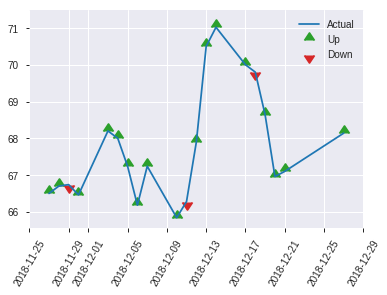


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2355516255542967
RMSE: 0.4853366105645614
LogLoss: 0.662493803907946
Null degrees of freedom: 248
Residual degrees of freedom: 188
Null deviance: 345.78564229926025
Residual deviance: 329.9219143461571
AIC: 451.9219143461571
AUC: 0.6287199480181936
pr_auc: 0.5920867868516552
Gini: 0.2574398960363873
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3869663014845148: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      35   100  0.7407   (100.0/135.0)
1      7    107  0.0614   (7.0/114.0)
Total  42   207  0.4297   (107.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386966     0.666667  206
max f2                       0.290052     0.814121  237
max f0point5                 0.602745     0.579096  59
max accuracy                 0.603085     0.630522  57
max precision                0.869077     1         0
max recall                   0.214052     1         248
max specificity              0.869077     1         0
max absolute_mcc             0.386966     0.263244  206
max min_per_class_accuracy   0.528112     0.555556  123
max mean_per_class_accuracy  0.602745     0.609454  59

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 51.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.809951           2.18421   2.18421            1                0.845104  1                           0.845104            0.0263158       0.0263158                  118.421   118.421
    2        0.0200803                   0.780331           2.18421   2.18421            1                0.7884    1                           0.822422            0.0175439       0.0438596                  118.421   118.421
    3        0.0321285                   0.76349            1.45614   1.91118            0.666667         0.772734  0.875                       0.803789            0.0175439       0.0614035                  45.614    91.1184
    4        0.0401606                   0.75313            1.09211   1.74737            0.5              0.757415  0.8                         0.794514            0.00877193      0.0701754                  9.21053   74.7368
    5        0.0522088                   0.736963           1.45614   1.68016            0.666667         0.746717  0.769231                    0.783484            0.0175439       0.0877193                  45.614    68.0162
    6        0.100402                    0.701033           1.45614   1.57263            0.666667         0.719816  0.72                        0.752924            0.0701754       0.157895                   45.614    57.2632
    7        0.15261                     0.636712           1.17611   1.43698            0.538462         0.662105  0.657895                    0.721854            0.0614035       0.219298                   17.6113   43.6981
    8        0.200803                    0.614387           1.63816   1.48526            0.75             0.623675  0.68                        0.698291            0.0789474       0.298246                   63.8158   48.5263
    9        0.301205                    0.57604            0.873684  1.2814             0.4              0.596961  0.586667                    0.664514            0.0877193       0.385965                   -12.6316  28.1404
    10       0.401606                    0.548475           0.873684  1.17947            0.4              0.55893   0.54                        0.638118            0.0877193       0.473684                   -12.6316  17.9474
    11       0.502008                    0.527785           0.873684  1.11832            0.4              0.536634  0.512                       0.617821            0.0877193       0.561404                   -12.6316  11.8316
    12       0.598394                    0.492847           1.09211   1.11409            0.5              0.512249  0.510067                    0.600816            0.105263        0.666667                   9.21053   11.4094
    13       0.698795                    0.458329           1.22316   1.12976            0.56             0.478887  0.517241                    0.583298            0.122807        0.789474                   22.3158   12.9764
    14       0.799197                    0.397029           1.04842   1.11955            0.48             0.431529  0.512563                    0.564232            0.105263        0.894737                   4.84211   11.9545
    15       0.899598                    0.334772           0.698947  1.0726             0.32             0.371646  0.491071                    0.542738            0.0701754       0.964912                   -30.1053  7.26034
    16       1                           0.214052           0.349474  1                  0.16             0.289409  0.457831                    0.517303         

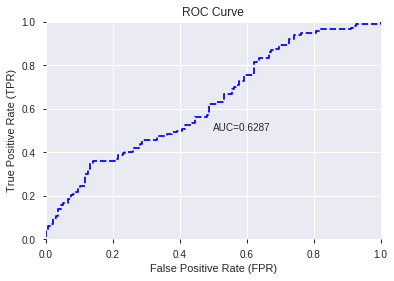

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


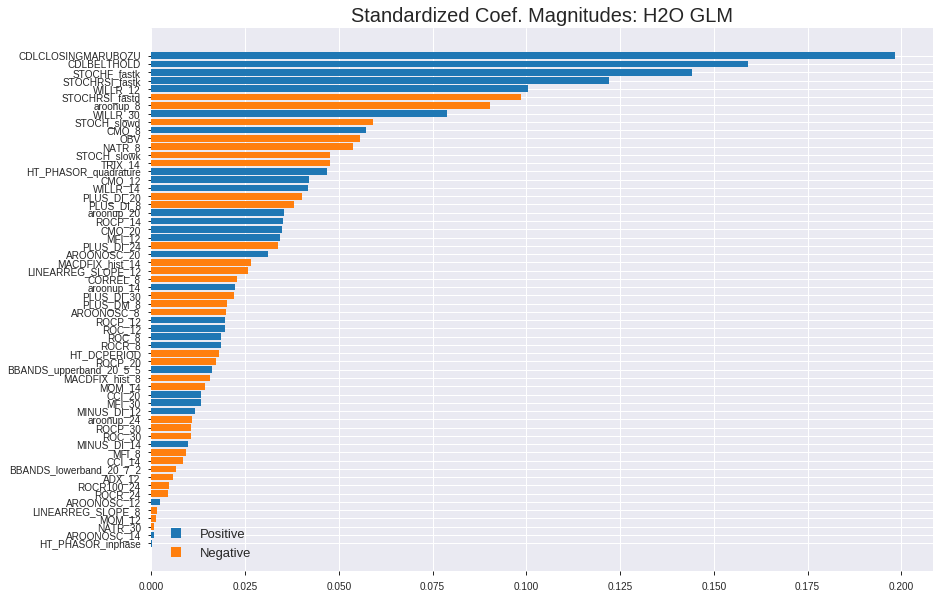

'log_likelihood'
--2019-08-25 12:41:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_124113_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_124113_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'WILLR_12',
 'STOCHRSI_fastd',
 'aroonup_8',
 'WILLR_30',
 'STOCH_slowd',
 'CMO_8',
 'OBV',
 'NATR_8',
 'STOCH_slowk',
 'TRIX_14',
 'HT_PHASOR_quadrature',
 'CMO_12',
 'WILLR_14',
 'PLUS_DI_20',
 'PLUS_DI_8',
 'aroonup_20',
 'ROCP_14',
 'CMO_20',
 'MFI_12',
 'PLUS_DI_24',
 'AROONOSC_20',
 'MACDFIX_hist_14',
 'LINEARREG_SLOPE_12',
 'CORREL_8',
 'aroonup_14',
 'PLUS_DI_30',
 'PLUS_DM_8',
 'AROONOSC_8',
 'ROCP_12',
 'ROC_12',
 'ROC_8',
 'ROCR_8',
 'HT_DCPERIOD',
 'ROCP_20',
 'BBANDS_upperband_20_5_5',
 'MACDFIX_hist_8',
 'MOM_14',
 'CCI_20',
 'MFI_30',
 'MINUS_DI_12',
 'aroonup_24',
 'ROCP_30',
 'ROC_30',
 'MINUS_DI_14',
 'MFI_8',
 'CCI_14',
 'BBANDS_lowerband_20_7_2',
 'ADX_12',
 'ROCR100_24',
 'ROCR_24',
 'AROONOSC_12',
 'LINEARREG_SLOPE_8',
 'MOM_12',
 'NATR_30',
 'AROONOSC_14',
 'HT_PHASOR_inphase']

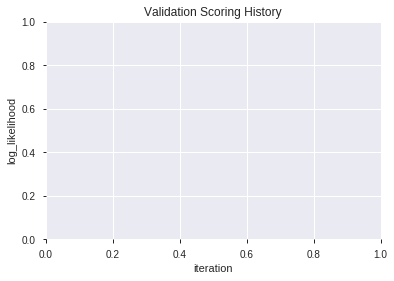

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_124131_model_6  0.632554  0.662878              0.407797  0.485228  0.235446
1  XGBoost_grid_1_AutoML_20190825_124131_model_4  0.617089  0.670853              0.444152  0.489059  0.239179
2               XGBoost_3_AutoML_20190825_124131  0.612606  0.674954              0.424659  0.491063  0.241143
3  XGBoost_grid_1_AutoML_20190825_124131_model_7  0.605198  0.682345              0.433723  0.494655  0.244684
4               XGBoost_1_AutoML_20190825_124131  0.601105  0.684320              0.459649  0.495130  0.245153
5  XGBoost_grid_1_AutoML_20190825_124131_model_5  0.599025  0.694179              0.391715  0.499089  0.249090
6  XGBoost_grid_1_AutoML_20190825_124131_model_3  0.592658  0.682329              0.443177  0.494653  0.244681
7  XGBoost_grid_1_AutoML_20190825_124131_model_2  0.592658  0.681078              0.447856  0.494072  0.244107
8               XGBoost_2_AutoML_20190825_124131  0.578622  0.689249              0.471735  0.497891  0.247896
9  XGBoost_grid_1_AutoML_20190825_124131_model_1  0.573099  0.690928              0.447173  0.498870  0.248872

variable  relative_importance  scaled_importance  percentage
0              STOCHF_fastk           430.744080           1.000000    0.058015
1                    ADX_12           335.072327           0.777892    0.045130
2            STOCHRSI_fastk           314.826172           0.730889    0.042403
3        CDLCLOSINGMARUBOZU           278.787170           0.647222    0.037549
4               CDLBELTHOLD           242.420563           0.562795    0.032651
5               HT_DCPERIOD           240.289215           0.557847    0.032364
6            STOCHRSI_fastd           219.897354           0.510506    0.029617
7                    NATR_8           208.728775           0.484577    0.028113
8                     MFI_8           206.657364           0.479768    0.027834
9                    MFI_12           202.900818           0.471047    0.027328
10                 CORREL_8           200.638718           0.465796    0.027023
11     HT_PHASOR_quadrature           199.838165           0.463937    0.026915
12              STOCH_slowd           188.197998           0.436914    0.025348
13                   MOM_14           177.884262           0.412970    0.023959
14                PLUS_DM_8           172.939789           0.401491    0.023293
15                  NATR_30           165.228485           0.383589    0.022254
16              STOCH_slowk           153.814087           0.357089    0.020717
17       LINEARREG_SLOPE_12           152.414001           0.353839    0.020528
18                  ROCP_14           145.410141           0.337579    0.019585
19                  ROCR_24           138.199280           0.320838    0.018614
20                 WILLR_14           129.741562           0.301203    0.017474
21                  ROCP_20           128.725861           0.298845    0.017338
22                 WILLR_12           128.473312           0.298259    0.017304
23                    ROC_8           127.131783           0.295145    0.017123
24                aroonup_8           123.911247           0.287668    0.016689
25        HT_PHASOR_inphase           121.209160           0.281395    0.016325
26                 WILLR_30           120.161705           0.278963    0.016184
27                      OBV           113.081726           0.262526    0.015231
28                   CMO_12           105.813118           0.245652    0.014252
29                   CCI_20           105.197624           0.244223    0.014169
30        LINEARREG_SLOPE_8            97.814880           0.227084    0.013174
31           MACDFIX_hist_8            97.321571           0.225938    0.013108
32  BBANDS_upperband_20_5_5            96.440140           0.223892    0.012989
33                   ROC_12            94.966171           0.220470    0.012791
34                   ROC_30            92.458794           0.214649    0.012453
35                   MOM_12            92.232422           0.214123    0.012422
36               PLUS_DI_30            88.372238           0.205162    0.011903
37               AROONOSC_8            88.187973           0.204734    0.011878
38  BBANDS_lowerband_20_7_2            78.359535           0.181917    0.010554
39                PLUS_DI_8            77.582489           0.180113    0.010449
40          MACDFIX_hist_14            76.466827           0.177523    0.010299
41               PLUS_DI_24            76.306984           0.177152    0.010278
42                   CCI_14            75.086388           0.174318    0.010113
43                  TRIX_14            73.893387           0.171548    0.009952
44              MINUS_DI_12            72.008682           0.167173    0.009699
45                   MFI_30            66.297142           0.153913    0.008929
46              AROONOSC_20            63.419590           0.147233    0.008542
47                    CMO_8            58.854332           0.136634    0.007927
48                   CMO_20            51.094120           0.118618    0.006882
49              MIN

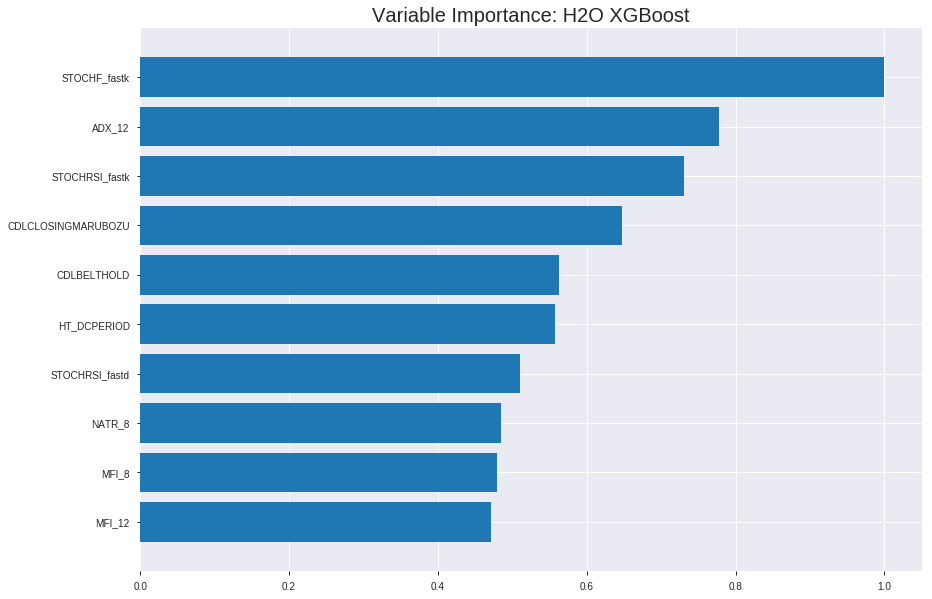

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_124131_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17037082238154647
RMSE: 0.41276000579216304
LogLoss: 0.5245782595898908
Mean Per-Class Error: 0.1867197791029489
AUC: 0.8993127324659007
pr_auc: 0.9046390882094911
Gini: 0.7986254649318014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4861604332923889: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      632  227  0.2643   (227.0/859.0)
1      113  769  0.1281   (113.0/882.0)
Total  745  996  0.1953   (340.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48616      0.818956  210
max f2                       0.419263     0.888586  257
max f0point5                 0.560912     0.836153  153
max accuracy                 0.528535     0.812751  178
max precision                0.83466      1         0
max recall                   0.257145     1         353
max specificity              0.83466      1         0
max absolute_mcc             0.536586     0.629658  172
max min_per_class_accuracy   0.511656     0.807256  190
max mean_per_class_accuracy  0.528535     0.81328   178

Gains/Lift Table: Avg response rate: 50.66 %, avg score: 50.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.798098           1.97392    1.97392            1                0.814706  1                           0.814706            0.0204082       0.0204082                  97.3923   97.3923
    2        0.0201034                   0.77448            1.97392    1.97392            1                0.783001  1                           0.799306            0.0192744       0.0396825                  97.3923   97.3923
    3        0.0304423                   0.762582           1.97392    1.97392            1                0.767787  1                           0.788602            0.0204082       0.0600907                  97.3923   97.3923
    4        0.0402068                   0.753936           1.97392    1.97392            1                0.758891  1                           0.781386            0.0192744       0.0793651                  97.3923   97.3923
    5        0.0505457                   0.746008           1.97392    1.97392            1                0.749588  1                           0.774882            0.0204082       0.0997732                  97.3923   97.3923
    6        0.100517                    0.706924           1.95123    1.96264            0.988506         0.725354  0.994286                    0.75026             0.0975057       0.197279                   95.1234   96.2643
    7        0.150488                    0.673096           1.88317    1.93625            0.954023         0.689796  0.980916                    0.730182            0.0941043       0.291383                   88.3168   93.6253
    8        0.20046                     0.642353           1.83779    1.91171            0.931034         0.656934  0.968481                    0.711923            0.0918367       0.38322                    83.779    91.1708
    9        0.300402                    0.592493           1.67897    1.83428            0.850575         0.61786   0.929254                    0.680628            0.1678          0.55102                    67.8969   83.4276
    10       0.400345                    0.55451            1.4067     1.72754            0.712644         0.572379  0.875179                    0.653605            0.14059         0.69161                    40.6704   72.7537
    11       0.500287                    0.5122             1.12309    1.60679            0.568966         0.533342  0.814007                    0.62958             0.112245        0.803855                   12.3094   60.6787
    12       0.60023                     0.471366           0.873518   1.48469            0.442529         0.493231  0.752153                    0.606877            0.0873016       0.891156                   -12.6482  48.4692
    13       0.700172                    0.425989           0.612597   1.36021            0.310345         0.448568  0.689089                    0.58428             0.0612245       0.952381                   -38.7403  36.0209
    14       0.800115                    0.370361           0.328987   1.2314             0.166667         0.398818  0.623833                    0.561114            0.0328798       0.985261                   -67.1013  23.1399
    15       0.900057                    0.286686           0.136133   1.10978            0.0689655        0.332605  0.562221                    0.53574             0.0136054       0.998866                   -86.3867  10.9781
    16       1                           0.109588           0.0113444  1                  0.00574713       0.230711  0.506605                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2375301856719215
RMSE: 0.4873706861023973
LogLoss: 0.6674889059173322
Mean Per-Class Error: 0.3801491477272727
AUC: 0.6231275826446281
pr_auc: 0.595704217948836
Gini: 0.24625516528925617
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.371419757604599: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      47   195  0.8058   (195.0/242.0)
1      10   246  0.0391   (10.0/256.0)
Total  57   441  0.4116   (205.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37142      0.705882  346
max f2                       0.291068     0.844371  387
max f0point5                 0.464861     0.632872  257
max accuracy                 0.464861     0.624498  257
max precision                0.798369     1         0
max recall                   0.256238     1         395
max specificity              0.798369     1         0
max absolute_mcc             0.464861     0.254527  257
max min_per_class_accuracy   0.506887     0.582645  202
max mean_per_class_accuracy  0.464861     0.619851  257

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.734875           1.55625   1.55625            0.8              0.761663  0.8                         0.761663            0.015625        0.015625                   55.625    55.625
    2        0.0200803                   0.724135           1.16719   1.36172            0.6              0.731823  0.7                         0.746743            0.0117188       0.0273438                  16.7188   36.1719
    3        0.0301205                   0.713197           0.389063  1.0375             0.2              0.719775  0.533333                    0.737754            0.00390625      0.03125                    -61.0937  3.75
    4        0.0401606                   0.699879           1.16719   1.06992            0.6              0.707135  0.55                        0.730099            0.0117188       0.0429688                  16.7188   6.99219
    5        0.0502008                   0.694521           1.55625   1.16719            0.8              0.6965    0.6                         0.723379            0.015625        0.0585938                  55.625    16.7188
    6        0.100402                    0.647871           1.55625   1.36172            0.8              0.667977  0.7                         0.695678            0.078125        0.136719                   55.625    36.1719
    7        0.150602                    0.625503           0.93375   1.21906            0.48             0.638465  0.626667                    0.676607            0.046875        0.183594                   -6.625    21.9063
    8        0.200803                    0.603235           1.01156   1.16719            0.52             0.613733  0.6                         0.660889            0.0507812       0.234375                   1.15625   16.7188
    9        0.301205                    0.566435           1.05047   1.12828            0.54             0.586168  0.58                        0.635982            0.105469        0.339844                   5.04688   12.8281
    10       0.399598                    0.535787           1.27041   1.16328            0.653061         0.549467  0.59799                     0.614679            0.125           0.464844                   27.0408   16.3277
    11       0.5                         0.507516           1.16719   1.16406            0.6              0.521266  0.598394                    0.595921            0.117188        0.582031                   16.7188   16.4063
    12       0.600402                    0.478827           1.16719   1.16459            0.6              0.492158  0.598662                    0.57857             0.117188        0.699219                   16.7188   16.4585
    13       0.698795                    0.455575           1.03221   1.14595            0.530612         0.468114  0.58908                     0.563017            0.101562        0.800781                   3.22066   14.5946
    14       0.799197                    0.420168           0.739219  1.09485            0.38             0.439388  0.562814                    0.547486            0.0742188       0.875                      -26.0781  9.48492
    15       0.899598                    0.359373           0.855938  1.06818            0.44             0.395515  0.549107                    0.530525            0.0859375       0.960938                   -14.4062  6.8185
    16       1                           0.18123            0.389063  1                  0.2              0.308562  0.514056                    0.508239            0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:41:39  5.557 sec   0                  0.5              0.693147            0.5             0                  1                0.493395                         0.5                0.693147              0.5               0                    1                  0.485944
    2019-08-25 12:41:40  5.621 sec   5                  0.483559         0.660672            0.789112        0.785145           1.97392          0.290638                         0.494162           0.681501              0.621586          0.612559             1.38951            0.439759
    2019-08-25 12:41:40  5.661 sec   10                 0.470779         0.635776            0.804439        0.805444           1.97392          0.283171                         0.491429           0.676047              0.631642          0.612186             1.16719            0.407631
    2019-08-25 12:41:40  5.712 sec   15                 0.459636         0.614258            0.827224        0.830117           1.97392          0.26996                          0.488882           0.67089               0.636614          0.623153             1.94531            0.399598
    2019-08-25 12:41:40  5.757 sec   20                 0.451454         0.598403            0.839734        0.844548           1.97392          0.263642                         0.488687           0.670449              0.627284          0.61134              1.94531            0.407631
    2019-08-25 12:41:40  5.806 sec   25                 0.443903         0.583716            0.848275        0.851935           1.97392          0.263642                         0.486509           0.666002              0.63755           0.617921             1.55625            0.421687
    2019-08-25 12:41:40  5.855 sec   30                 0.436774         0.569855            0.857534        0.860869           1.97392          0.241241                         0.485705           0.664258              0.636654          0.617491             1.55625            0.407631
    2019-08-25 12:41:40  5.906 sec   35                 0.429518         0.556019            0.870689        0.873404           1.97392          0.217691                         0.486619           0.666015              0.629084          0.610178             1.55625            0.401606
    2019-08-25 12:41:40  5.960 sec   40                 0.423088         0.543928            0.88239         0.887057           1.97392          0.207352                         0.487017           0.66678               0.6245            0.603465             1.55625            0.411647
    2019-08-25 12:41:40  6.012 sec   45                 0.418104         0.534415            0.889079        0.894874           1.97392          0.195864                         0.487666           0.668136              0.622546          0.597441             1.55625            0.419679
    2019-08-25 12:41:40  6.085 sec   50                 0.41276          0.524578            0.899313        0.904639           1.97392          0.19529                          0.487371           0.667489              0.623128          0.595704             1.55625            0.411647

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
STOCHF_fastk        430.74407958984375     1.0                   0.05801538876997725
ADX_12              335.07232666015625     0.7778918911183027    0.04512970048424114
STOCHRSI_fastk      314.826171875          0.7308891446047935    0.042402817872003215
CDLCLOSINGMARUBOZU  278.78717041015625     0.6472222918899281    0.03754885288458987
CDLBELTHOLD         242.42056274414062     0.562794880372992     0.03265076378259196
---                 ---                    ---                   ---
aroonup_20          33.81346130371094      0.0785001185295646    0.004554214894981984
ROCP_30             25.679622650146484     0.05961689055505702   0.0034586970828088177
ROCR_8              21.624557495117188     0.050202796787615     0.002912534772973649
ROCP_12             19.689624786376953     0.04571072643674057   0.002651925565185581
ROCR100_24          8.466819763183594      0.019656264971176698  0.0011403658540685019


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5943775100401606)

('F1', 0.6646153846153846)

('auc', 0.6325536062378168)

('logloss', 0.6628779022589182)

('mean_per_class_error', 0.395906432748538)

('rmse', 0.4852280612181537)

('mse', 0.23544627139352833)

xgboost prediction progress: |████████████████████████████████████████████| 100%


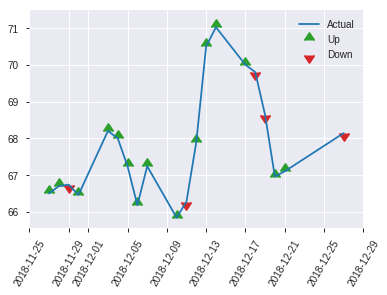


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23544627139352833
RMSE: 0.4852280612181537
LogLoss: 0.6628779022589182
Mean Per-Class Error: 0.395906432748538
AUC: 0.6325536062378168
pr_auc: 0.5789895622685971
Gini: 0.2651072124756335
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38019049167633057: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   103  0.763    (103.0/135.0)
1      6    108  0.0526   (6.0/114.0)
Total  38   211  0.4378   (109.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.38019      0.664615  210
max f2                       0.3657       0.811012  215
max f0point5                 0.479053     0.571031  150
max accuracy                 0.591996     0.594378  58
max precision                0.80318      1         0
max recall                   0.222566     1         247
max specificity              0.80318      1         0
max absolute_mcc             0.38019      0.255482  210
max min_per_class_accuracy   0.519133     0.592593  122
max mean_per_class_accuracy  0.479053     0.604094  150

Gains/Lift Table: Avg response rate: 45.78 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.74473            2.18421   2.18421            1                0.766007  1                           0.766007            0.0263158       0.0263158                  118.421   118.421
    2        0.0200803                   0.73548            1.09211   1.74737            0.5              0.741334  0.8                         0.756138            0.00877193      0.0350877                  9.21053   74.7368
    3        0.0321285                   0.727229           0.72807   1.36513            0.333333         0.733179  0.625                       0.747528            0.00877193      0.0438596                  -27.193   36.5132
    4        0.0401606                   0.720398           2.18421   1.52895            1                0.722904  0.7                         0.742604            0.0175439       0.0614035                  118.421   52.8947
    5        0.0522088                   0.710341           2.18421   1.68016            1                0.71799   0.769231                    0.736923            0.0263158       0.0877193                  118.421   68.0162
    6        0.100402                    0.650279           1.27412   1.48526            0.583333         0.678261  0.68                        0.708766            0.0614035       0.149123                   27.4123   48.5263
    7        0.15261                     0.618071           1.0081    1.32202            0.461538         0.634372  0.605263                    0.683315            0.0526316       0.201754                   0.809717  32.2022
    8        0.200803                    0.60443            1.45614   1.35421            0.666667         0.610991  0.62                        0.665957            0.0701754       0.27193                    45.614    35.4211
    9        0.301205                    0.567482           1.13579   1.2814             0.52             0.586469  0.586667                    0.639461            0.114035        0.385965                   13.5789   28.1404
    10       0.401606                    0.538472           0.786316  1.15763            0.36             0.55244   0.53                        0.617706            0.0789474       0.464912                   -21.3684  15.7632
    11       0.502008                    0.517665           1.31053   1.18821            0.6              0.526686  0.544                       0.599502            0.131579        0.596491                   31.0526   18.8211
    12       0.598394                    0.4799             1.18311   1.18739            0.541667         0.497627  0.543624                    0.583092            0.114035        0.710526                   18.3114   18.739
    13       0.698795                    0.444061           0.786316  1.12976            0.36             0.464256  0.517241                    0.566018            0.0789474       0.789474                   -21.3684  12.9764
    14       0.799197                    0.412759           1.13579   1.13052            0.52             0.42798   0.517588                    0.548677            0.114035        0.903509                   13.5789   13.0521
    15       0.899598                    0.346797           0.611579  1.0726             0.28             0.378258  0.491071                    0.529657            0.0614035       0.964912                   -38.8421  7.26034
    16       1                           0.15992            0.349474  1                  0.16             0.290546  0.457831                    0.50565           

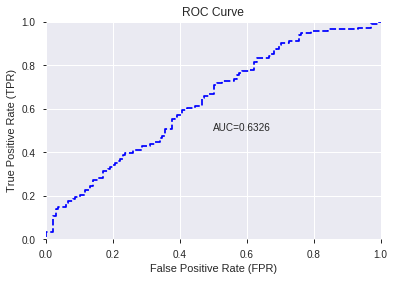

This function is available for GLM models only


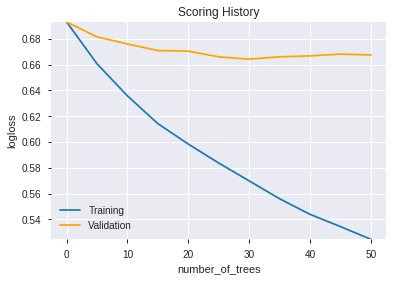

--2019-08-25 12:41:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_124131_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_124131_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_80ff',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['STOCHF_fastk',
 'ADX_12',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'NATR_8',
 'MFI_8',
 'MFI_12',
 'CORREL_8',
 'HT_PHASOR_quadrature',
 'STOCH_slowd',
 'MOM_14',
 'PLUS_DM_8',
 'NATR_30',
 'STOCH_slowk',
 'LINEARREG_SLOPE_12',
 'ROCP_14',
 'ROCR_24',
 'WILLR_14',
 'ROCP_20',
 'WILLR_12',
 'ROC_8',
 'aroonup_8',
 'HT_PHASOR_inphase',
 'WILLR_30',
 'OBV',
 'CMO_12',
 'CCI_20',
 'LINEARREG_SLOPE_8',
 'MACDFIX_hist_8',
 'BBANDS_upperband_20_5_5',
 'ROC_12',
 'ROC_30',
 'MOM_12',
 'PLUS_DI_30',
 'AROONOSC_8',
 'BBANDS_lowerband_20_7_2',
 'PLUS_DI_8',
 'MACDFIX_hist_14',
 'PLUS_DI_24',
 'CCI_14',
 'TRIX_14',
 'MINUS_DI_12',
 'MFI_30',
 'AROONOSC_20',
 'CMO_8',
 'CMO_20',
 'MINUS_DI_14',
 'aroonup_14',
 'PLUS_DI_20',
 'AROONOSC_12',
 'AROONOSC_14',
 'aroonup_20',
 'ROCP_30',
 'ROCR_8',
 'ROCP_12',
 'ROCR100_24']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.655
GLM             0.655
XGBoost         0.643
dtype: float64

DeepLearning    GLM  XGBoost
All          0.602  0.578    0.639
DLF          0.651  0.651    0.643
Fwe          0.631  0.655    0.622
RFE          0.610  0.631    0.594
XGBF         0.655  0.651    0.643





F1


DeepLearning    0.679
GLM             0.673
XGBoost         0.679
dtype: float64

DeepLearning    GLM  XGBoost
All          0.640  0.633    0.673
DLF          0.675  0.660    0.679
Fwe          0.679  0.673    0.673
RFE          0.675  0.667    0.665
XGBF         0.664  0.660    0.679





auc


DeepLearning    0.680
GLM             0.672
XGBoost         0.669
dtype: float64

DeepLearning    GLM  XGBoost
All          0.603  0.557    0.665
DLF          0.680  0.656    0.669
Fwe          0.673  0.672    0.656
RFE          0.635  0.629    0.633
XGBF         0.680  0.656    0.669





logloss


DeepLearning    1.476
GLM             0.709
XGBoost         0.663
dtype: float64

DeepLearning    GLM  XGBoost
All          1.476  0.703    0.659
DLF          0.661  0.709    0.652
Fwe          0.664  0.653    0.656
RFE          0.659  0.662    0.663
XGBF         0.651  0.709    0.652





mean_per_class_error


DeepLearning    0.409
GLM             0.445
XGBoost         0.396
dtype: float64

DeepLearning    GLM  XGBoost
All          0.409  0.445    0.366
DLF          0.352  0.349    0.354
Fwe          0.370  0.349    0.381
RFE          0.383  0.391    0.396
XGBF         0.347  0.349    0.354





rmse


DeepLearning    0.627
GLM             0.504
XGBoost         0.485
dtype: float64

DeepLearning    GLM  XGBoost
All          0.627  0.503    0.483
DLF          0.481  0.504    0.480
Fwe          0.481  0.480    0.482
RFE          0.483  0.485    0.485
XGBF         0.480  0.504    0.480





mse


DeepLearning    0.393
GLM             0.254
XGBoost         0.235
dtype: float64

DeepLearning    GLM  XGBoost
All          0.393  0.253    0.233
DLF          0.231  0.254    0.231
Fwe          0.231  0.230    0.232
RFE          0.233  0.236    0.235
XGBF         0.230  0.254    0.231

{'F1':       DeepLearning    GLM  XGBoost
 All          0.640    NaN      NaN
 DLF          0.675    NaN      NaN
 DLF            NaN  0.660      NaN
 DLF            NaN    NaN    0.679
 All            NaN  0.633      NaN
 All            NaN    NaN    0.673
 XGBF         0.664    NaN      NaN
 XGBF           NaN  0.660      NaN
 XGBF           NaN    NaN    0.679
 Fwe          0.679    NaN      NaN
 Fwe            NaN  0.673      NaN
 Fwe            NaN    NaN    0.673
 RFE          0.675    NaN      NaN
 RFE            NaN  0.667      NaN
 RFE            NaN    NaN    0.665,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.602    NaN      NaN
 DLF          0.651    NaN      NaN
 DLF            NaN  0.651      NaN
 DLF            NaN    NaN    0.643
 All            NaN  0.578      NaN
 All            NaN    NaN    0.639
 XGBF         0.655    NaN      NaN
 XGBF           NaN  0.651      NaN
 XGBF           NaN    NaN    0.643
 Fwe          0.631    NaN      NaN
 Fwe     